# 05_LargeScale_Maps
Relation to large-scale patterns of atm. forcing

In [104]:
%load_ext autoreload
%autoreload 2


import warnings

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
# from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FixedLocator

import matplotlib.dates as mdates


from scipy import stats


# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_nsidc.icedrift as icedrift
import data_unibremen.SIC as unisic


sys.path.append('../')
import functions as fn

plt.style.use('../jgr_oceans.mplstyle')

def SAVE(fig, filename):
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.05)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from pyproj import Geod
g = Geod(ellps='WGS84')

### Import constants

In [4]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

## Reference grids

In [5]:

# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))



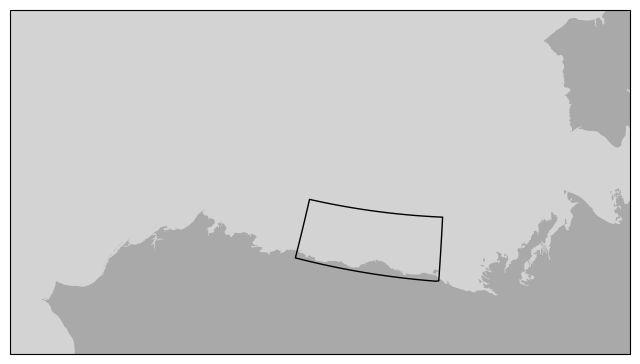

In [6]:

# initialize map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))
ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-800000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


# for key in ['era', 'ppd']:
#     ax.scatter(grids[key]['lon'][grids[key]['region']], grids[key]['lat'][grids[key]['region']], 
#                zorder=100, s = 10, transform=ccrs.PlateCarree())


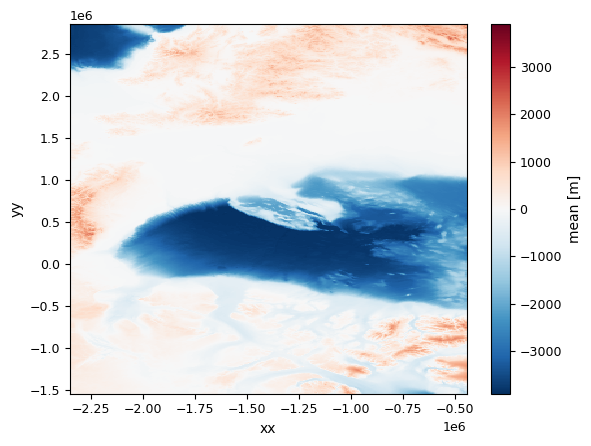

In [7]:
dsb = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/re-gridded/master_625kmASI_V1.nc')
dsb = dsb.sel(xx=slice(-2346875, -446875), yy=slice(-1546875, 2846875))

dsb.avg.plot()

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def create_map_box(proj, lon_range=(-165, -120), lat_range = (68, 78)):
    
    # Bounding box in degrees
    lon_min, lon_max = lon_range[0], lon_range[1]
    lat_min, lat_max = lat_range[0], lat_range[1]
    
    # Sample points along each edge
    npts = 100
    # Sample border points:
    # Bottom edge: latitude fixed at lat_min, lon varies left to right
    bottom = [(lon, lat_min) for lon in np.linspace(lon_min, lon_max, npts)]
    # Right edge: longitude fixed at lon_max, lat varies bottom to top
    right = [(lon_max, lat) for lat in np.linspace(lat_min, lat_max, npts)]
    # Top edge: latitude fixed at lat_max, lon varies right to left
    top = [(lon, lat_max) for lon in np.linspace(lon_max, lon_min, npts)]
    # Left edge: longitude fixed at lon_min, lat varies top to bottom
    left = [(lon_min, lat) for lat in np.linspace(lat_max, lat_min, npts)]
    
    # Combine in order to make a closed polygon
    all_coords = bottom + right + top + left

    # Transform each point to map projection coordinates
    projected_coords = [proj.transform_point(lon, lat, ccrs.PlateCarree()) for lon, lat in all_coords]

    # Create a closed path
    clip_path = mpath.Path(projected_coords)
    
    return clip_path



In [9]:
moors = {}
for M in ['M1', 'M2', 'M3', 'M4']:
    moors[M] = {}
    path = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/'
    with xr.open_dataset(path+f'{M}/{M}_hourly_ocean_currents_2016_2017.nc') as ds:
        print(M, ds.attrs)
        
        moors[M] = ds.attrs
        
df2 = pd.read_csv('../data/start_points_v7.nc')

M1 {'lat': 69.7706, 'lon': -139.2548}
M2 {'lat': 69.908, 'lon': -138.9988}
M3 {'lat': 70.0485, 'lon': -138.7949}
M4 {'lat': 70.2517, 'lon': -138.7938}


In [10]:
dsb2 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/gebco_2023_n88.8988_s61.7506_w170.0_e250.0.nc')
dsb2 = dsb2.sel(lat=slice(68.5,73),lon=slice(200,235))
# dsb2

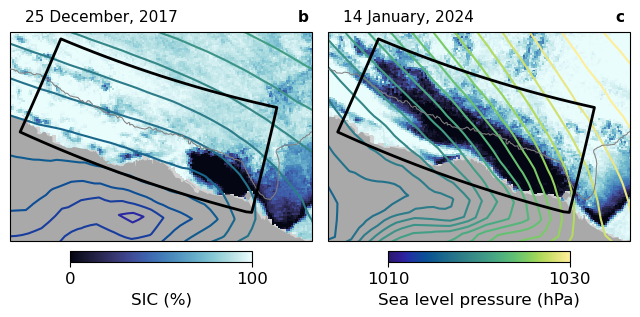

In [481]:
fig, axs = fn.makemap(view='wider_zoom3', contours = [-100], 
                      panels=(1,2), figsize=(8,4))

# fig, axs = fn.makemap(view='wider_zoom3', contours = [-100], 
#                       panels=(1,3), figsize=(8,4))

for ax in axs:
    ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


#     line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
#     for lat in [70]:
#         ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
#     for lon in [-140,]:
#         ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)

dates = [datetime(2017,12,25),  datetime(2024,1,14),]#datetime(2019,12,13),
RES = '3125'
crop=[1500, 2050, 480, 700]
sic_key = 'sic'
for ax, date in zip(axs, dates):
    sic1 = unisic.open_local_file(date, res=RES, hem='n', 
                                 main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                 crop=crop, coordinates=False, area=False, include_units=False, quiet=True)
    mesh = ax.pcolormesh(sic1['xx'], sic1['yy'], sic1['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=sic1['proj'])

# for key, ax in zip(era_map.keys(), axs):
    
#     u1 = era_map[key]['u10']
#     v1 = era_map[key]['v10']
#     # wind vectors
#     U,V =geomap.fix_cartopy_vectors(u1,v1, era_map[key]['lat'])

#     sp1, sp2 = 3,8
#     Q = ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], U[::sp1,::sp2], V[::sp1,::sp2], 
#               angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
#               scale=0.0003, width=0.0035, headwidth=4,headlength=4, headaxislength=4, 
#               color=[0.4,0.4,0.4], pivot='tail', zorder=1)
    
# for key, ax in zip(era_map.keys(), axs):  
#     ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'],
#                   map_sic[key]['sic_mean'], cmap=cmocean.cm.ice, vmin=0, vmax=100, transform=dsic['proj'])
    
for key, ax in zip(['17','24'], axs):
    
    u1 = era_map[key]['u10']
    v1 = era_map[key]['v10']
    # wind vectors
    U,V =geomap.fix_cartopy_vectors(u1,v1, era_map[key]['lat'])

#     sp1, sp2 = 5,12
#     Q = ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], U[::sp1,::sp2], V[::sp1,::sp2], 
#               angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
#               scale=0.0003, width=0.0035, headwidth=4,headlength=4, headaxislength=4, 
#               color=[0.4,0.4,0.4], pivot='tail', zorder=1)
    
    mesh2 = ax.contour(era_map[key]['lon'], era_map[key]['lat'], 
                   era_map[key]['msl']/100, 
                   levels=np.arange(1000,1040,1), vmin=1010,vmax=1030,
               cmap=cmocean.cm.haline,  transform=ccrs.PlateCarree(),)

    
# for key, ax in zip(['17','24'], axs):  
#     ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'],
#                   map_sic[key]['sic_mean'], cmap=cmocean.cm.ice, vmin=0, vmax=100, zorder=-1, transform=dsic['proj'])
    
plt.subplots_adjust(wspace=0.05)

plotter.add_colorbar(fig, axs[0], [mesh], cb_placement='bottom',
             cb_orientation='auto', cb_width='auto', cb_length_fraction=[0.2, 0.8], 
             cb_pad=0.025, cb_ticks=[0,100], cb_ticklabels='auto', cb_extend='neither', 
             cb_label='SIC (%)', labelpad='auto', cb_label_placement='auto', cb_tick_placement='auto', 
             tick_kwargs=None, cb_labelsize=12, draw_edges=False, edge_params=['k', 2])

norm = mpl.colors.Normalize(vmin=1010, vmax=1030, )
plotter.add_colorbar(fig, ax, [cmocean.cm.haline, norm], cb_placement='bottom',
             cb_orientation='auto', cb_width='auto', cb_length_fraction=[0.2, 0.8], 
             cb_pad=0.025, cb_ticks=[1010,1030], cb_ticklabels='auto', cb_extend='neither', 
             cb_label='Sea level pressure (hPa)', labelpad='auto', cb_label_placement='auto', cb_tick_placement='auto', 
             tick_kwargs=None, cb_labelsize=12, draw_edges=False, edge_params=['k', 2])


# ax.text()

Y = 1.05
axs[0].text(0.05,Y, '25 December, 2017', weight='normal', size=11, transform=axs[0].transAxes)
axs[1].text(0.05,Y, '14 January, 2024', weight='normal', size=11, transform=axs[1].transAxes)

axs[0].text(0.95,Y, 'b', weight='bold', size=11, transform=axs[0].transAxes)
axs[1].text(0.95,Y, 'c', weight='bold', size=11, transform=axs[1].transAxes)

fig.savefig('../figures/results/example_events_v0.png', dpi=400, bbox_inches='tight', pad_inches=0)

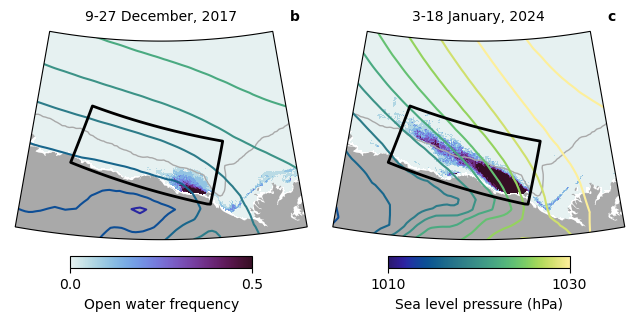

In [497]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-152.5, -132.5)
lat_range = (68.5, 73.5)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, axs = plt.subplots(1,2,figsize=(8,5), subplot_kw={'projection': proj})

for ax in axs:
    ax.set_boundary(clip_path, transform=proj)
    ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
    ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())

    geomap.land(ax, color='darkgray', scale='10m')
    ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])

    
    
for key, ax in zip(['17','24'], axs):
    
    u1 = era_map[key]['u10']
    v1 = era_map[key]['v10']
    # wind vectors
    U,V =geomap.fix_cartopy_vectors(u1,v1, era_map[key]['lat'])

#     sp1, sp2 = 5,12
#     Q = ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], U[::sp1,::sp2], V[::sp1,::sp2], 
#               angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
#               scale=0.0003, width=0.0035, headwidth=4,headlength=4, headaxislength=4, 
#               color=[0.4,0.4,0.4], pivot='tail', zorder=1)
    
    ax.contour(era_map[key]['lon'], era_map[key]['lat'], 
                   era_map[key]['msl']/100, 
                   levels=np.arange(1000,1040,2), vmin=1010,vmax=1030,
               cmap=cmocean.cm.haline,  transform=ccrs.PlateCarree(),)

    
for key, ax in zip(['17','24'], axs):  
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'],
#                   map_sic[key]['sic_mean'], cmap=cmocean.cm.ice, vmin=0, vmax=100, zorder=-1, transform=dsic['proj'])
    mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'],
                  map_sic[key]['open_freq'], cmap=cmocean.cm.dense, vmin=0, vmax=0.5, zorder=-1, transform=dsic['proj'])
    
# dates = [datetime(2017,12,25),  datetime(2024,1,14),]#datetime(2019,12,13),
# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'
# for ax, date in zip(axs, dates):
#     sic1 = unisic.open_local_file(date, res=RES, hem='n', 
#                                  main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
#                                  crop=crop, coordinates=False, area=False, include_units=False, quiet=True)
#     mesh = ax.pcolormesh(sic1['xx'], sic1['yy'], sic1['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=sic1['proj'])

    
plt.subplots_adjust(wspace=0.05)


plotter.add_colorbar(fig, axs[0], [mesh], cb_placement='bottom',
             cb_orientation='auto', cb_width='auto', cb_length_fraction=[0.1, 0.9], 
             cb_pad=0.0, cb_ticks=[0,0.5], cb_ticklabels='auto', cb_extend='neither', 
             cb_label='Open water frequency', labelpad='auto', cb_label_placement='auto', cb_tick_placement='auto', 
             tick_kwargs=None, cb_labelsize=10, draw_edges=False, edge_params=['k', 2])

norm = mpl.colors.Normalize(vmin=1010, vmax=1030, )
plotter.add_colorbar(fig, ax, [cmocean.cm.haline, norm], cb_placement='bottom',
             cb_orientation='auto', cb_width='auto', cb_length_fraction=[0.1, 0.9], 
             cb_pad=0.0, cb_ticks=[1010,1030], cb_ticklabels='auto', cb_extend='neither', 
             cb_label='Sea level pressure (hPa)', labelpad='auto', cb_label_placement='auto', cb_tick_placement='auto', 
             tick_kwargs=None, cb_labelsize=10, draw_edges=False, edge_params=['k', 2])


Y = 1.05
axs[0].text(0.5,Y, '9-27 December, 2017',ha='center', weight='normal', size=10, transform=axs[0].transAxes)
axs[1].text(0.5,Y, '3-18 January, 2024', ha='center',weight='normal', size=10, transform=axs[1].transAxes)

axs[0].text(0.925,Y, 'b', weight='bold', size=10, transform=axs[0].transAxes)
axs[1].text(0.925,Y, 'c', weight='bold', size=10, transform=axs[1].transAxes)

fig.savefig('../figures/results/example_events.png', dpi=400, bbox_inches='tight', pad_inches=0)

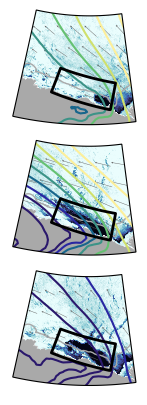

In [443]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-155, -135)
lat_range = (68.5, 75)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, axs = plt.subplots(3,1,figsize=(6,5), subplot_kw={'projection': proj})

for ax in axs:
    ax.set_boundary(clip_path, transform=proj)
    ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
    ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())

    geomap.land(ax, color='darkgray', scale='10m')
    ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])

    
for key, ax in zip(era_map.keys(), axs):
    
    u1 = era_map[key]['u10']
    v1 = era_map[key]['v10']
    # wind vectors
    U,V =geomap.fix_cartopy_vectors(u1,v1, era_map[key]['lat'])

    sp1, sp2 = 5,12
    Q = ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], U[::sp1,::sp2], V[::sp1,::sp2], 
              angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
              scale=0.0001, width=0.0035, headwidth=4,headlength=4, headaxislength=4, 
              color=[0.4,0.4,0.4], pivot='tail', zorder=1)
    
    ax.contour(era_map[key]['lon'], era_map[key]['lat'], 
                   era_map[key]['msl']/100, 
                   levels=np.arange(1000,1040,4), vmin=1010,vmax=1030,
               
               cmap=cmocean.cm.haline,  transform=ccrs.PlateCarree(),)

    
for key, ax in zip(era_map.keys(), axs):  
    ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'],
                  map_sic[key]['sic_mean'], cmap=cmocean.cm.ice, vmin=0, vmax=100, zorder=-1, transform=dsic['proj'])
    
    
plt.subplots_adjust(hspace=0.05)



In [402]:
map_sic[key].keys()

dict_keys(['xx', 'yy', 'sic_mean', 'open_freq', 'missing_dates'])

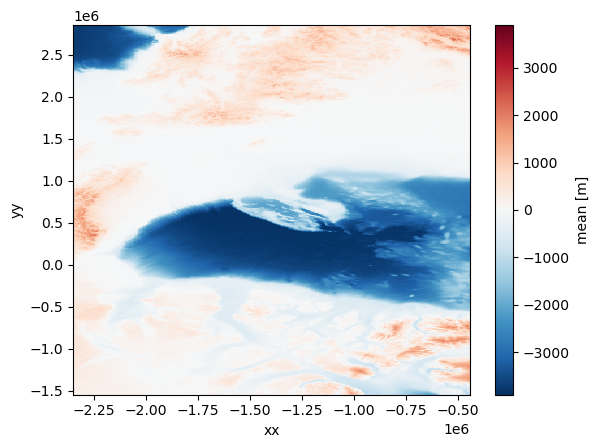

In [22]:
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Define multiple colors for subtle gradients
colors = [
    (0.2, 0.3, 0.5),    # darkest blue
    (0.3, 0.45, 0.65),  # medium blue
    (0.5, 0.65, 0.8),   # lighter blue
    (0.75, 0.83, 0.9),  # pale blue-gray
    (0.95, 0.97, 0.98)  # very pale, almost white (sea level)
]

cmap = LinearSegmentedColormap.from_list("gray_to_deep_blue", colors, N=256)
# newcmap = cmocean.tools.crop_by_percent(cmocean.cm.deep_r, 20, which='min', N=None)

norm = TwoSlopeNorm(vmin=-3000, vcenter=-400, vmax=0)


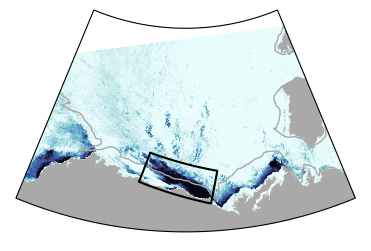

In [59]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-165, -120)
lat_range = (68, 78)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, ax = plt.subplots(figsize=(7,3), subplot_kw={'projection': proj})

ax.set_boundary(clip_path, transform=proj)
ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)
ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())

ax.pcolormesh(dsic['xx'], dsic['yy'], dsic['sic'], transform=dsic['proj'], 
              cmap=cmocean.cm.ice)

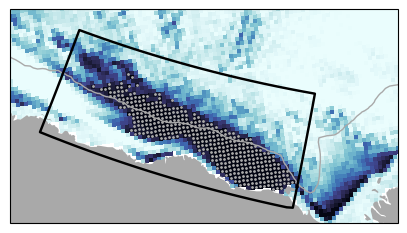

In [66]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-150, -135)
lat_range = (69, 72)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, ax = plt.subplots(figsize=(5,3), subplot_kw={'projection': proj})

# ax.set_boundary(clip_path, transform=proj)
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)
ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
ax.add_geometries ([reg_poly], ls='solid', lw=1.75, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


ax.pcolormesh(dsic['xx'], dsic['yy'], dsic['sic'], transform=dsic['proj'], 
              cmap=cmocean.cm.ice)

ax.scatter(xx_poly, yy_poly, s=1, c='darkgray', transform=dsic['proj'], )

In [23]:
colors = [
    (-3000, (0.35, 0.45, 0.65)),  # lighter deep blue
    (-2000, (0.55, 0.70, 0.85)),  # light blue
    (-1000,  (0.75, 0.85, 0.92)),  # very light blue
    (-400,   (0.88, 0.92, 0.95)),  # pale blue-gray
    (-100,     (0.98, 0.98, 0.99))   # near-white at sea level
]
# Normalize depth values to 0–1
depths, rgb = zip(*colors)
depths = np.array(depths)
rgb = np.array(rgb)
norm_depths = (depths - depths.min()) / (depths.max() - depths.min())

# Create colormap with nonuniform spacing
cmap = LinearSegmentedColormap.from_list("stretched_near_surface", list(zip(norm_depths, rgb)))

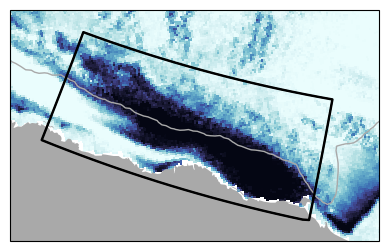

In [237]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-150, -136.5)
lat_range = (69, 72)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, ax = plt.subplots(figsize=(5,3), subplot_kw={'projection': proj})

# ax.set_boundary(clip_path, transform=proj)
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)
ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
ax.add_geometries ([reg_poly], ls='solid', lw=1.75, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


# ax.pcolormesh(dsic['xx'], dsic['yy'], dsic['sic'], transform=dsic['proj'], 
#               cmap=cmocean.cm.ice)

# ax.scatter(xx_poly, yy_poly, s=1, c='darkgray', transform=dsic['proj'], )


sp = 5
# norm=norm,
# mesh =  ax.pcolormesh(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
#                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# # mesh =  ax.pcolormesh(dsb['xx'], dsb['yy'], dsb['avg'], cmap=cmap, norm=norm,  transform=dsic['proj'])
# ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
#            colors=['gray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])

# geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)


# for m in moors.keys():
#     ax.scatter(moors[m]['lon'], moors[m]['lat'], transform=ccrs.PlateCarree(), s=15, c='k')
    
    
# plotter.add_colorbar(fig, ax, [mesh], cb_placement='left',
#              cb_orientation='auto', cb_width='auto', cb_length_fraction=[0, 1], 
#              cb_pad=0, cb_ticks=[-3000,-100,0], cb_ticklabels='auto', cb_extend='min', 
#              cb_label=' ', labelpad='auto', cb_label_placement='auto', cb_tick_placement='auto', 
#              tick_kwargs=None, cb_labelsize=12, draw_edges=False, edge_params=['k', 2])


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())

ax.pcolormesh(dsic['xx'], dsic['yy'], dsic['sic'], transform=dsic['proj'], 
              cmap=cmocean.cm.ice)

# ax.scatter(xx_poly, yy_poly, s=1, c='darkgray', transform=dsic['proj'], )


fig.savefig('../figures/overview/regional_zoom_sic.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [24]:
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from matplotlib.patches import Circle

NameError: name 'dsic' is not defined

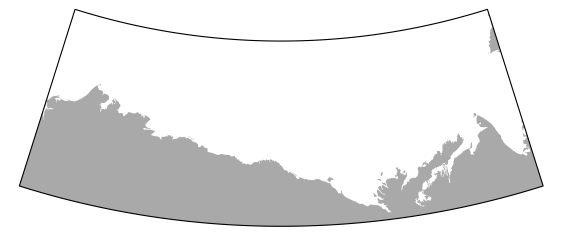

In [26]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-160, -125)
lat_range = (68.5, 73)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, ax = plt.subplots(figsize=(7,5), subplot_kw={'projection': proj})

ax.set_boundary(clip_path, transform=proj)
ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)

ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
# ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())



sp = 20
# norm=norm,
# mesh =  ax.pcolormesh(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
#                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax.contour(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
                   levels=[-500,-400,-300,-200,],
                   linewidths=0.5, linestyles='solid', colors=['darkgray'], transform=ccrs.PlateCarree())


mesh = ax.pcolormesh(dsb['xx'], dsb['yy'], dsb['avg'],
           cmap=cmap, norm=norm, transform=dsic['proj'])


# Optional: Gridlines



gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
                  linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
gl.xlocator = FixedLocator([-160, -150, -140, -130])
gl.ylocator = FixedLocator([70,72,])
gl.bottom_labels = False
gl.right_labels = False
for lat in [70,72,]:
    ax.text(-124.5, lat, f"{lat}°N",
            transform=ccrs.PlateCarree(),
            ha='left', va='center', clip_on=False, rotation=15)
for lon in [-160, -150, -140, -130]:
    rot = lon-(-142.5)
    ax.text(lon, 68.4, f"{-lon}°W",
            transform=ccrs.PlateCarree(),
            ha='center', va='top',rotation=rot, clip_on=False)

COLOR = [0.3,0.3,0.3]


ax.text(-149,69.25, 'Alaska', rotation=0,c=COLOR, transform=ccrs.PlateCarree())

ax.text(-148,72.45, 'Canada Basin', rotation=0,c=COLOR, transform=ccrs.PlateCarree())

ax.text(-150,70., 'Beaufort Shelf', rotation=-21,c=COLOR, transform=ccrs.PlateCarree())
ax.text(-137,69.75, 'Mackenzie Shelf', rotation=35, c=COLOR,transform=ccrs.PlateCarree())
ax.text(-153, 72.1, 'Barrow\nCanyon', rotation=0, ha='center', c=COLOR,transform=ccrs.PlateCarree())
ax.text(-139, 70.7, 'Mackenzie\nCanyon', rotation=0,ha='center', c=COLOR,transform=ccrs.PlateCarree())

# ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())
# ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())

plotter.add_colorbar(fig, ax, [mesh], cb_placement='left', 
                     cb_orientation='auto', cb_width=0.02, 
                     cb_length_fraction=[0.2, 1], 
                     cb_pad=0, cb_ticks=[-3000,-1000,-100], cb_ticklabels='auto', 
                     cb_extend='both', cb_label='Depth\n(m)', 
                     labelpad=10, cb_label_placement='auto', 
                     cb_tick_placement='auto', tick_kwargs=None, cb_labelsize=10, draw_edges=False, edge_params=['k', 2])

ax.text(0.91,0.95,'a', weight='bold', transform=ax.transAxes)


# fig.savefig('../figures/overview/bath_map.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [ ]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-160, -125)
lat_range = (68.5, 73)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, ax = plt.subplots(figsize=(7,5), subplot_kw={'projection': proj})

ax.set_boundary(clip_path, transform=proj)
ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)

ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
ax.add_geometries ([reg_poly], lw=1.75, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())



sp = 20
# norm=norm,
# mesh =  ax.pcolormesh(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
#                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# ax.pcolormesh(dsb['xx'], dsb['yy'], dsb['avg'],
#            cmap=cmap, norm=norm, transform=dsic['proj'])


# # Optional: Gridlines



# gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
#                   linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
# gl.xlocator = FixedLocator([-160, -150, -140, -130])
# gl.ylocator = FixedLocator([70,72,])
# gl.bottom_labels = False
# gl.right_labels = False
# for lat in [70,72,]:
#     ax.text(-124.5, lat, f"{lat}°N",
#             transform=ccrs.PlateCarree(),
#             ha='left', va='center', clip_on=False, rotation=15)
# for lon in [-160, -150, -140, -130]:
#     ax.text(lon, 68.35, f"{-lon}°W",
#             transform=ccrs.PlateCarree(),
#             ha='center', va='top', clip_on=False, rotation=0)

# COLOR = [0.2,0.2,0.2]


# ax.text(-150,70., 'Beaufort Shelf', rotation=-21,c=COLOR, transform=ccrs.PlateCarree())
# ax.text(-137,69.75, 'Mackenzie Shelf', rotation=35, c=COLOR,transform=ccrs.PlateCarree())
# ax.text(-153, 72.1, 'Barrow\nCanyon', rotation=0, ha='center', c=COLOR,transform=ccrs.PlateCarree())
# ax.text(-139, 70.5, 'Mackenzie\nCanyon', rotation=0,ha='center', c=COLOR,transform=ccrs.PlateCarree())

RES = '3125'
crop=[1500, 2050, 480, 700]
sic_key = 'sic'
dsic = unisic.open_local_file(datetime(2024,1,14), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)
mesh = ax.pcolormesh(dsic['xx'], dsic['yy'], dsic['sic'], cmap=cmocean.cm.ice, transform=dsic['proj'])



RES = '6250'
crop=[700, 1150, 200, 400]
sic_key = 'sic'
open_thresh = 10
dsic = unisic.open_local_file(datetime(2024,1,14), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)
# ax.contour(dsic['xx'], dsic['yy'], dsic['sic'], levels=[10], colors=['gold'], linewdiths=[0.5], transform=dsic['proj'])

ax.contour(dsic['xx'], dsic['yy'], poly_points, levels=[0.75], colors=['gold'],
           linewidths=[1], linestyles='solid', transform=dsic['proj'])

# ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())
# ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())

plotter.add_colorbar(fig, ax, [mesh], cb_placement='left', 
                     cb_orientation='auto', cb_width=0.02, 
                     cb_length_fraction=[0.2, 1], 
                     cb_pad=0, cb_ticks='auto', cb_ticklabels='auto', 
                     cb_extend='neither', cb_label='SIC\n(%)', 
                     labelpad=10, cb_label_placement='auto', 
                     cb_tick_placement='auto', tick_kwargs=None, cb_labelsize=10, draw_edges=False, edge_params=['k', 2])

ax.text(0.9,0.95,'b', weight='bold', transform=ax.transAxes)

ax.text(-145,68.8, 'Beaufort Shelf\nregion',
        ha='center', weight='bold', rotation=0,c='k', transform=ccrs.PlateCarree())

# ax.text(-140,71.5, 'Beaufort Shelf\nregion',
#         ha='center', weight='bold', rotation=0,c='k', transform=ccrs.PlateCarree())

# ax.text(0.45,0.075, 'Mackenzie\nCoastal\nPolynya',
#         ha='center', weight='normal', rotation=0,c='k', transform=ax.transAxes)


ax.text(0.025,-0.05, '14 January, 2024',
        ha='left', weight='normal', rotation=0,c='k', transform=ax.transAxes)

# fig.savefig('../figures/overview/bath_sic.png', dpi=400, bbox_inches='tight', pad_inches=0)

### By date

In [ ]:

DATE = datetime(2024,1,14)


dss = xr.open_dataset('../data/polynya_size/daily_polynya_2024_sic10_v7.4_radius25km.nc')
dss = dss.sel(time=DATE)

xx_poly = np.array([float(XX) for XX in dss.poly_interior_xx.values.item().split('_')[1:]])
yy_poly = np.array([float(YY) for YY in dss.poly_interior_yy.values.item().split('_')[1:]])

xx_edge = np.array([float(XX) for XX in dss.ice_edge_xx.values.item().split('_')[1:]])
yy_edge = np.array([float(YY) for YY in dss.ice_edge_yy.values.item().split('_')[1:]])


poly_points = np.full(dsic['xx'].shape, 0.0)

for xx, yy  in zip(xx_poly, yy_poly):
    
    dist = (dsic['xx'] - xx)**2 + (dsic['yy'] - yy)**2
    
    poly_points[np.where(dist == 0)] =1.0
    
for xx, yy  in zip(xx_edge, yy_edge):
    
    dist = (dsic['xx'] - xx)**2 + (dsic['yy'] - yy)**2
    
    poly_points[np.where(dist == 0)] =0.5

In [ ]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-160, -125)
lat_range = (68.5, 73)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, ax = plt.subplots(figsize=(7,5), subplot_kw={'projection': proj})

ax.set_boundary(clip_path, transform=proj)
ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)

ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
ax.add_geometries ([reg_poly], lw=1.75, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())



sp = 20
# norm=norm,
# mesh =  ax.pcolormesh(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
#                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# ax.pcolormesh(dsb['xx'], dsb['yy'], dsb['avg'],
#            cmap=cmap, norm=norm, transform=dsic['proj'])


# # Optional: Gridlines



# gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
#                   linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
# gl.xlocator = FixedLocator([-160, -150, -140, -130])
# gl.ylocator = FixedLocator([70,72,])
# gl.bottom_labels = False
# gl.right_labels = False
# for lat in [70,72,]:
#     ax.text(-124.5, lat, f"{lat}°N",
#             transform=ccrs.PlateCarree(),
#             ha='left', va='center', clip_on=False, rotation=15)
# for lon in [-160, -150, -140, -130]:
#     ax.text(lon, 68.35, f"{-lon}°W",
#             transform=ccrs.PlateCarree(),
#             ha='center', va='top', clip_on=False, rotation=0)

# COLOR = [0.2,0.2,0.2]


# ax.text(-150,70., 'Beaufort Shelf', rotation=-21,c=COLOR, transform=ccrs.PlateCarree())
# ax.text(-137,69.75, 'Mackenzie Shelf', rotation=35, c=COLOR,transform=ccrs.PlateCarree())
# ax.text(-153, 72.1, 'Barrow\nCanyon', rotation=0, ha='center', c=COLOR,transform=ccrs.PlateCarree())
# ax.text(-139, 70.5, 'Mackenzie\nCanyon', rotation=0,ha='center', c=COLOR,transform=ccrs.PlateCarree())

RES = '3125'
crop=[1500, 2050, 480, 700]
sic_key = 'sic'
dsic = unisic.open_local_file(datetime(2024,1,14), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)
mesh = ax.pcolormesh(dsic['xx'], dsic['yy'], dsic['sic'], cmap=cmocean.cm.ice, transform=dsic['proj'])



RES = '6250'
crop=[700, 1150, 200, 400]
sic_key = 'sic'
open_thresh = 10
dsic = unisic.open_local_file(datetime(2024,1,14), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)
# ax.contour(dsic['xx'], dsic['yy'], dsic['sic'], levels=[10], colors=['gold'], linewdiths=[0.5], transform=dsic['proj'])

ax.contour(dsic['xx'], dsic['yy'], poly_points, levels=[0.75], colors=['gold'],
           linewidths=[1], linestyles='solid', transform=dsic['proj'])

# ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())
# ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())

plotter.add_colorbar(fig, ax, [mesh], cb_placement='left', 
                     cb_orientation='auto', cb_width=0.02, 
                     cb_length_fraction=[0.2, 1], 
                     cb_pad=0, cb_ticks='auto', cb_ticklabels='auto', 
                     cb_extend='neither', cb_label='SIC\n(%)', 
                     labelpad=10, cb_label_placement='auto', 
                     cb_tick_placement='auto', tick_kwargs=None, cb_labelsize=10, draw_edges=False, edge_params=['k', 2])

ax.text(0.9,0.95,'b', weight='bold', transform=ax.transAxes)

ax.text(-145,68.8, 'Beaufort Shelf\nregion',
        ha='center', weight='bold', rotation=0,c='k', transform=ccrs.PlateCarree())

# ax.text(-140,71.5, 'Beaufort Shelf\nregion',
#         ha='center', weight='bold', rotation=0,c='k', transform=ccrs.PlateCarree())

# ax.text(0.45,0.075, 'Mackenzie\nCoastal\nPolynya',
#         ha='center', weight='normal', rotation=0,c='k', transform=ax.transAxes)


ax.text(0.025,-0.05, '14 January, 2024',
        ha='left', weight='normal', rotation=0,c='k', transform=ax.transAxes)

# fig.savefig('../figures/overview/bath_sic.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [ ]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-141.1, -137.4)
lat_range = (69.25, 70.5)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, ax = plt.subplots(figsize=(3,3), subplot_kw={'projection': proj})

# ax.set_boundary(clip_path, transform=proj)
# ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)

ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1.25],linestyles=['solid'], transform=dsic['proj'])
# ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())



sp = 5
# norm=norm,
mesh =  ax.pcolormesh(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
                      cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

mesh =  ax.contour(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
                   levels=[-500,-400,-300,-200,],
                   linewidths=0.5, linestyles='solid', colors=['darkgray'], transform=ccrs.PlateCarree())


gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
                  linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
gl.xlocator = FixedLocator([-160, -150, -140, -130])
gl.ylocator = FixedLocator([70,72,])
gl.bottom_labels = False
gl.right_labels = False
# for lat in [70,72,]:
#     ax.text(-124.5, lat, f"{lat}°N",
#             transform=ccrs.PlateCarree(),
#             ha='left', va='center', clip_on=False, rotation=15)
# for lon in [-160, -150, -140, -130]:
#     ax.text(lon, 68.35, f"{-lon}°W",
#             transform=ccrs.PlateCarree(),
#             ha='center', va='top', clip_on=False, rotation=0)

COLOR = [0.3,0.3,0.3]

for m in moors.keys():
    ax.scatter(moors[m]['lon'], moors[m]['lat'], transform=ccrs.PlateCarree(), c='k', zorder=100)
    ax.text(moors[m]['lon'], moors[m]['lat'], f'  {m}', va='center', transform=ccrs.PlateCarree(), c='k', zorder=100)
    

# ax.text(-150,70., 'Beaufort Shelf', rotation=-21,c=COLOR, transform=ccrs.PlateCarree())
# ax.text(-137,69.75, 'Mackenzie Shelf', rotation=35, c=COLOR,transform=ccrs.PlateCarree())
# ax.text(-153, 72, 'Barrow\nCanyon', rotation=0, ha='center', c=COLOR,transform=ccrs.PlateCarree())
# ax.text(-138, 70.5, 'Mackenzie\nCanyon', rotation=0,ha='center', c=COLOR,transform=ccrs.PlateCarree())

# ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())
# ax.plot([-156,-154], [71.6,72], c=COLOR,transform=ccrs.PlateCarree())


ax.text(0.3, 0.1, 'Qikiqtaruk\n(Herschel Island)', weight='normal', rotation=0, ha='center', c=COLOR,transform=ax.transAxes)

ax.scatter(-139.15, 69.595, marker='*', s=50, c=COLOR, zorder=100, transform=ccrs.PlateCarree())


ax.text(0.05, 0.675, '100 m', c='darkgray', rotation = -15, transform=ax.transAxes)

# fig.savefig('../figures/overview/bath_map_extrazoom.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [ ]:
# ax.pcolormesh(dsb['xx'], dsb['yy'], dsb['avg'],
#            cmap=cmap, norm=norm, transform=dsic['proj'])


# Optional: Gridlines




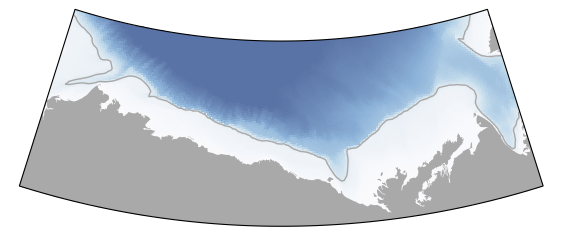

In [188]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
lon_range = (-160, -125)
lat_range = (68.5, 73)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, ax = plt.subplots(figsize=(7,5), subplot_kw={'projection': proj})

ax.set_boundary(clip_path, transform=proj)
ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)

ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['darkgray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
# ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())



sp = 20
# norm=norm,
# mesh =  ax.pcolormesh(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
#                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

ax.pcolormesh(dsb['xx'], dsb['yy'], dsb['avg'],
           cmap=cmap, norm=norm, transform=dsic['proj'])


In [254]:
dss

<xarray.Dataset>
Dimensions:               ()
Coordinates:
    time                  datetime64[ns] 2024-01-14
Data variables: (12/40)
    N                     float64 ...
    extent                float64 ...
    max_length            float64 ...
    max_length_direction  float64 ...
    com_length            float64 ...
    com_direction         float64 ...
    ...                    ...
    land_extent           float64 ...
    ice_extent            float64 ...
    ocean_extent          float64 ...
    other_polynya_extent  float64 ...
    polynya_extent        float64 ...
    miss_flag             bool ...

In [261]:
dss = xr.open_dataset('../data/polynya_size/daily_polynya_2024_sic10_v7.4_radius25km.nc')
dss = dss.sel(time=datetime(2024,1,14))

xx_poly = np.array([float(XX) for XX in dss.poly_interior_xx.values.item().split('_')[1:]])
yy_poly = np.array([float(YY) for YY in dss.poly_interior_yy.values.item().split('_')[1:]])

xx_edge = np.array([float(XX) for XX in dss.ice_edge_xx.values.item().split('_')[1:]])
yy_edge = np.array([float(YY) for YY in dss.ice_edge_yy.values.item().split('_')[1:]])


poly_points = np.full(dsic['xx'].shape, 0.0)

for xx, yy  in zip(xx_poly, yy_poly):
    
    dist = (dsic['xx'] - xx)**2 + (dsic['yy'] - yy)**2
    
    poly_points[np.where(dist == 0)] =1.0
    
for xx, yy  in zip(xx_edge, yy_edge):
    
    dist = (dsic['xx'] - xx)**2 + (dsic['yy'] - yy)**2
    
    poly_points[np.where(dist == 0)] =0.5

Text(0.1, 0.8, 'Mackenzie\nCanyon')

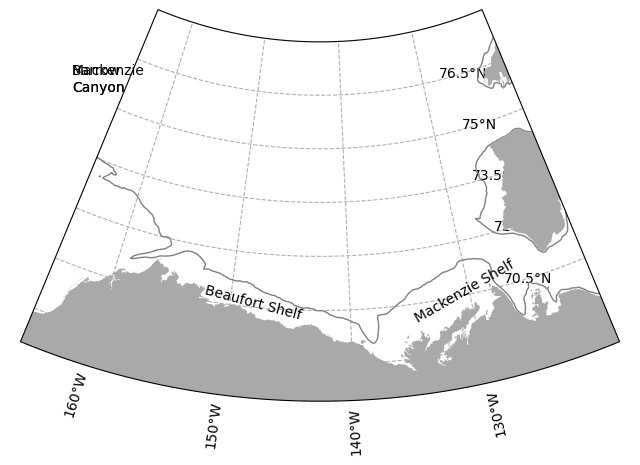

In [211]:


# Optional: Gridlines
gl = ax.gridlines(crs=pc, draw_labels=True, linestyle='--')
gl.top_labels = False



# ax.pcolormesh(dsb['xx'], dsb['yy'], dsb['avg'], cmap=cmap, norm=norm,  transform=dsic['proj'])
ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['gray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])

geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)
# geomap.coast(ax, )


ax.text(-152,70, 'Beaufort Shelf', rotation=-15, transform=ccrs.PlateCarree())
ax.text(-135,70, 'Mackenzie Shelf', rotation=30, transform=ccrs.PlateCarree())
ax.text(0.1,0.8, 'Barrow\nCanyon', rotation=0, transform=ax.transAxes)
ax.text(0.1,0.8, 'Mackenzie\nCanyon', rotation=0, transform=ax.transAxes)

# ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
#

In [173]:
360-160

200

In [258]:

# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-143)
pc = ccrs.PlateCarree()

# Bounding box in degrees
lon_min, lon_max = -150, -135
lat_min, lat_max = 69, 72

# Sample points along each edge
npts = 100
# Sample border points:
# Bottom edge: latitude fixed at lat_min, lon varies left to right
bottom = [(lon, lat_min) for lon in np.linspace(lon_min, lon_max, npts)]
# Right edge: longitude fixed at lon_max, lat varies bottom to top
right = [(lon_max, lat) for lat in np.linspace(lat_min, lat_max, npts)]
# Top edge: latitude fixed at lat_max, lon varies right to left
top = [(lon, lat_max) for lon in np.linspace(lon_max, lon_min, npts)]
# Left edge: longitude fixed at lon_min, lat varies top to bottom
left = [(lon_min, lat) for lat in np.linspace(lat_max, lat_min, npts)]

# Combine in order to make a closed polygon
all_coords = bottom + right + top + left

# Transform each point to map projection coordinates
projected_coords = [proj.transform_point(lon, lat, pc) for lon, lat in all_coords]

# Create a closed path
clip_path = mpath.Path(projected_coords)

# Plotting
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': proj})

# Apply clipping path
ax.set_boundary(clip_path, transform=proj)

# Optional zoom
ax.set_extent([lon_min, lon_max, lat_min-0.75, lat_max], crs=pc)

# Optional: Gridlines
gl = ax.gridlines(crs=pc, draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False

norm = TwoSlopeNorm(vmin=-3000, vcenter=-500, vmax=0)


sp = 5
mesh =  ax.pcolormesh(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp], cmap=cmap, norm=norm,  transform=ccrs.PlateCarree())

# mesh =  ax.pcolormesh(dsb['xx'], dsb['yy'], dsb['avg'], cmap=cmap, norm=norm,  transform=dsic['proj'])
ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['gray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])

geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)

ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


for m in moors.keys():
    ax.scatter(moors[m]['lon'], moors[m]['lat'], transform=ccrs.PlateCarree(), c='k')
    
    
# plotter.add_colorbar(fig, ax, [mesh], cb_placement='left', 
#                      cb_orientation='auto', cb_width='auto', 
#                      cb_length_fraction=[0, 1], 
#                      cb_pad=0, cb_ticks='auto', cb_ticklabels='auto', 
#                      cb_extend='neither', cb_label=' ', labelpad='auto', cb_label_placement='auto', 
#                      cb_tick_placement='auto', tick_kwargs=None, cb_labelsize=12, draw_edges=False, edge_params=['k', 2])


# ax.scatter(df2.x_pts, df2.y_pts, transform=dsic['proj'], s=5)

Error in callback <function _draw_all_if_interactive at 0x110a568e0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x13521e2a0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [201]:
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

M1 {'lat': 69.7706, 'lon': -139.2548}
M2 {'lat': 69.908, 'lon': -138.9988}
M3 {'lat': 70.0485, 'lon': -138.7949}
M4 {'lat': 70.2517, 'lon': -138.7938}


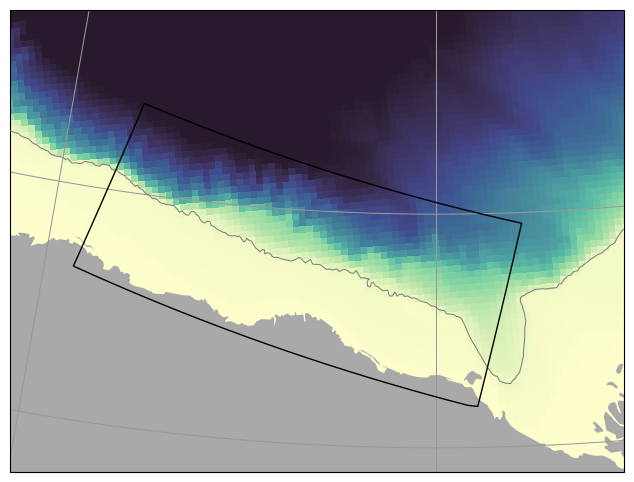

In [27]:
fig, ax = fn.makemap(view='tall_zoom', contours = [-100])

# ax.pcolormesh(ds.xx, ds.yy, ma.masked_where(np.isnan(ds.sic10), ds.sic70), 
#               vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=sic['proj'])
ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69,71,73]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-160,-150,-140,-130]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
    
# ax.pcolormesh(dsic['xx'], dsic['yy'], dsic['sic'], transform=dsic['proj'])

# ax.contour(dsic['xx'], dsic['yy'], dsic['sic'], levels=[10], colors=['r'], transform=dsic['proj'])

ax.pcolormesh(dsb['xx'], dsb['yy'], dsb['avg'], vmin=-3000,vmax=0, cmap=cmocean.cm.deep_r, transform=dsic['proj'])

In [13]:

RES = '3125'
crop=[1500, 2050, 480, 700]
sic_key = 'sic'

RES = '6250'
crop=[700, 1150, 200, 400]
sic_key = 'sic'
open_thresh = 10
# sicsic = unisic.open_local_file(datetime(2019,1,16), res='1000ma2', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                             crop=[2100, 3400, 340, 800], coordinates=False, area=False, include_units=False, quiet=True)


RES = '3125'
crop=[1500, 2050, 480, 700]
sic_key = 'sic'
dsic = unisic.open_local_file(datetime(2024,1,14), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)
ax.pcolormesh(dsic['xx'], dsic['yy'], dsic['sic'], transform=dsic['proj'])

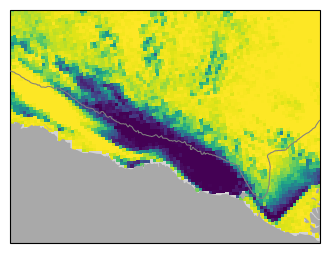

In [13]:
fig, ax = fn.makemap(view='tall_zoom', contours = [-100], 
                      panels=(1,1), figsize=(4,6))

ax.pcolormesh(dsic['xx'], dsic['yy'], dsic['sic'], transform=dsic['proj'])

In [191]:
# # time_range = slice(datetime(2003, 12, 15), datetime(2004, 1, 30,23))
# # time_range = slice(datetime(2013, 12, 15), datetime(2014, 1, 30,23))
# # time_range = slice(datetime(2023, 12, 15), datetime(2024, 1, 30,23))
# # time_range = slice(datetime(2016, 12, 1,1), datetime(2017, 4, 30,23))

# # time_range = slice(datetime(2018, 12, 30), datetime(2019, 1, 22,23))

# # time_range = slice(datetime(2017, 12, 15), datetime(2018, 4, 30,23))
# # time_range = slice(datetime(2019,1,13,12), datetime(2019,1,21))

# time_range = slice(datetime(2017,12,22,0), datetime(2017,12,26,0))

# dh = pd.read_csv('/Volumes/Seagate_Jewell/KenzieStuff/met_data/HIYT/herschel-island-yt_fed4_1534_1033.csv')
# dh = pd.DataFrame(dh).set_index('time')
# ti = time_range.start.strftime('%Y-%m-%dT%H:%M:%SZ')
# tf = time_range.stop.strftime('%Y-%m-%dT%H:%M:%SZ')
# date_time_range_df = dh.loc[ti:tf]
# Tar = np.array([float(val) for val in date_time_range_df.air_temperature.values]) * units('degC')

# # if time_range.stop.year == 2004:
# #     Tar = date_time_range_df.air_temperature.values * units('degC')

# times = np.array([datetime.strptime(tstr, '%Y-%m-%dT%H:%M:%SZ') for tstr in date_time_range_df.index.values])
# # times = np.array([datetime.strptime(tstr, '%Y-%m-%dT%H:%M:%SZ') for tstr in dh.time.values[1:]])
# # dti = np.array([abs((time - time_range.start).total_seconds()) for time in times])

# # interpolate over missing data
# # Ta, _ = tseries.linear_interpolate(data['time'], times, 
# #                                    Tar.magnitude.astype(np.float64), max_dt=6*units('hours'))


# dd = xr.open_dataset(f'../data/forcing/regional_hourly_era_{time_range.stop.year}_v6.nc')
# dd = dd.sel(time=slice(time_range.start, time_range.stop))

# # di = xr.open_dataset(f'../data/forcing/regional_daily_ppd_{time_range.stop.year}_v6.nc')
# # di = di.sel(time=slice(time_range.start, time_range.stop))

# ws = date_time_range_df.wind_speed.values.astype(float)
# wd = date_time_range_df.wind_from_direction.values.astype(float) * 10


In [6]:
ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/SBSpolynya_data/open_freqs_2002-2025_M4.nc')
sic = unisic.open_local_file(datetime(2020,1,1), res='6250', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', crop=[0, None, 0, None], coordinates=False, area=False, include_units=False, quiet=True)


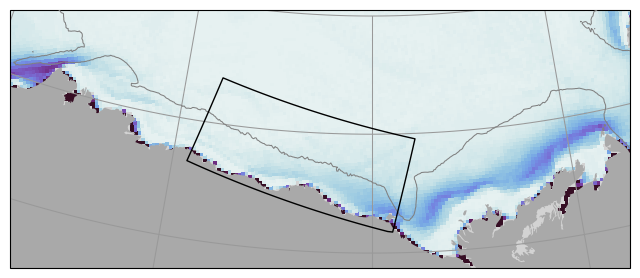

In [7]:
fig, ax = fn.makemap(view='wide', contours = [-100])

ax.pcolormesh(ds.xx, ds.yy, ma.masked_where(np.isnan(ds.sic10), ds.sic70), 
              vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=sic['proj'])
ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69,71,73]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-160,-150,-140,-130]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    


In [7]:

# key = 'era'
# mainpath = '../data/forcing/'
# filename = f"dailymaps_{key}_v0.nc"
# ds = xr.open_dataset(mainpath+filename)

## Identify continuous polynya sequences

In [151]:
df = pd.read_csv('../data/compiled_stats.csv')

df['esei'] = vectors.comp_along_theta(df['ui'], df['vi'], 165*units('degree')) * units('cm/s').to('km/day')
df['ese10'] = 0.02*vectors.comp_along_theta(df['u10'], df['v10'], 180*units('degree'))* units('m/s').to('km/day')

for cat in ['a10', 'ai', 'centermass_direction', 'max_length_direction']:
    df[f'{cat}_r'] = 90-df[f'{cat}']
    df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
    
well_after = (df['day_after_event']>1) + (df['day_after_event']==-999)
well_before = (df['day_before_event']<-1) + (df['day_before_event']==-999)
outside = ((df['extent'] == 0) & (well_after & well_before))
df['outside_event'] = outside

# identify base period
dfb = df[df['2003_2023']]

dfr = df[df.year >= 2003]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21663/983662188.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21663/983662188.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21663/983662188.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [152]:
np.sum(dfb.outside_event)

2295

In [16]:

#===============
DF = dfr
#===============

strong_winds_whole_time = np.full(len(DF), False)
all_ss = list(set(DF.sequence[DF.sequence!=-999].values))

for ss in all_ss:
    during = (DF.sequence.values==ss)
    if np.sum(DF.s10[during].values > 5) == np.sum(during):
        strong_winds_whole_time[during] = True

### Specify event days for Pease model run

In [31]:
#===============
DF = dfb
#===============

shoulder = (DF['season_start_flag'] + DF['season_end_flag'])

not_last_day = (DF.final_day == False)
not_last_day[DF.single_day == True] = True

LLMAX = 10

last_seqs = list(set(DF.sequence.values))

event_dates = {}

for ll in np.arange(1,LLMAX+1):
    
    if ll == LLMAX:
        key = f'd{ll}+'
    else:
        key = f'd{ll}'
        
    event_dates[key] = np.array([], dtype=np.datetime64)
    
    within_last = np.array([True if seq in last_seqs else False for seq in DF.sequence.values])
    
    if ll < LLMAX:
        cond = ((DF.event_day == ll) & (shoulder==False))
        cond = (cond &within_last)&(DF.s10>6.5)# (dir_conds(DF, 'wind')&(DF.s10>7))#(not_last_day)
    else:
        print(ll)
        cond = ((DF.event_day >= ll) & (shoulder==False))#&(DF['season_start_flag']==False))#
        cond = (cond &within_last)&(DF.s10>6.5)# (dir_conds
        
    last_seqs = list(set(DF.sequence[cond].values))
    
    llday_ind = np.where(cond)[0]
   
    if len(llday_ind) >= 1:
        
        for ll_ind in llday_ind:
            
            event_dates[key] = np.append(event_dates[key], pd.to_datetime(DF.time.values)[ll_ind])

10


In [32]:
for key in event_dates.keys():
    
    print(key, len(event_dates[key]))

d1 107
d2 61
d3 39
d4 23
d5 16
d6 10
d7 6
d8 6
d9 5
d10+ 11


In [162]:

#===============
DF = dfr
#===============

shoulder = (DF['season_start_flag'] + DF['season_end_flag'])

event_dates = {}
event_sizes = {}

# shoulder = (DF['season_start_flag'] + DF['season_end_flag'])
# cond = ((DF.event_day == ll) & (shoulder==False)) #& (DF.event_length == ll)
#     cond = cond & (DF.s10>7)# (dir_conds(DF, 'wind')&(DF.s10>7))#(not_last_day)
    
# not_last_day = (DF.final_day == False)
# not_last_day[DF.single_day == True] = True


for dict_, cat_ in zip([event_dates, event_sizes], ['time', 'extent']):
    
    dict_['all'] = DF[cat_][(DF.extent>0)].values
#     dict_['b1'] = DF[cat_][(DF.day_before_event==-1)].values
#     dict_['a1'] = DF[cat_][(DF.day_after_event==1)].values
    dict_['comp'] = DF[cat_][DF.outside_event].values
    
#     dict_['clim'] = DF[cat_].values
#     dict_['q1'] = DF[cat_][(DF.extent <= 155)&(DF.extent > 0)].values
#     dict_['q2'] = DF[cat_][(DF.extent <= 545)&(DF.extent > 155)].values
#     dict_['q3'] = DF[cat_][(DF.extent <= 1715)&(DF.extent > 545)].values
#     dict_['q4'] = DF[cat_][DF.extent>1715].values
    # event_dates['peak'] = DF['time'][DF['peak_day']&(DF['event_day']!=1)].values
    
#     for day in [1,2,3,4,5,6]:
        
#         cond = (((DF.event_day==day)&(shoulder==False)) & (DF.missing_sic==False)) & (DF.s10>6.5)
        
#         dict_[f'd{day}'] = DF[cat_][cond].values
        
#         print(day, np.sum(cond))
        
#     cond = ((DF.event_day>=7)&(shoulder==False)) & (DF.missing_sic==False) & (DF.s10>6.5)
#     dict_[f'd7+'] = DF[cat_][cond].values
#     print(10, np.sum(cond))


# for dict_, cat_ in zip([event_dates, event_sizes], ['time', 'extent']):
    
#     dict_['all'] = DF[cat_][((DF.extent>0)) & ((DF.year > 2016) & (DF.year < 2019))].values
#     dict_['comp'] = DF[cat_][((DF.extent==0)) & ((DF.year > 2016) & (DF.year < 2019))].values




#     dict_['peak'] = DF[cat_][DF['peak_day']].values

# for mm in [12,1,2,3,4]:
#     NAME = calendar.month_name[mm][:3]
#     event_dates[NAME] = DF['time'][(DF.month ==mm)&(DF.extent > 0)].values
#     event_sizes[NAME] = DF['extent'][(DF.month ==mm)&(DF.extent > 0)].values

In [54]:
event_dates = {}

event_dates['17'] = pd.to_datetime(df[df.sequence==99].time.values)
# event_dates['19'] = pd.to_datetime(df[df.sequence==117].time.values)
event_dates['24'] = pd.to_datetime(df[df.sequence==150].time.values)


# event_dates['17'] = np.array([datetime(2017,12,25)])
# event_dates['24'] = np.array([datetime(2024,1,14)])
# event_dates['19'] = np.array([datetime(2019,12,13)])


# [datetime(2017,12,25), datetime(2024,1,14), datetime(2019,12,13)]

In [33]:
event_dates = {}

# event_dates['huge'] = pd.to_datetime(df[df.sequence==96].time.values)
event_dates['huge'] = pd.to_datetime(df[df.sequence==117].time.values)
event_dates['huge'] = np.append(event_dates['huge'], pd.to_datetime(df[df.sequence==148].time.values))


event_dates['small'] = pd.to_datetime(df[df.sequence==12].time.values)
for other in [60,79,82,85,96, 117]:
    event_dates['small'] = np.append(event_dates['small'], pd.to_datetime(df[df.sequence==other].time.values))

In [121]:
event_dates = {}

for dict_, cat_ in zip([event_dates, event_sizes], ['time', 'extent']):
    
#     dict_['all'] = DF[cat_][(DF.extent>0)].values

#     dict_['all'] = DF[cat_][(DF.extent>0)].values
    
#     dict_['all'] = DF[cat_][(DF.extent>0)].values
    dict_['b1'] = DF[cat_][(DF.day_before_event==-1)].values
    dict_['d1'] = DF[cat_][(DF.event_day==1)].values
    dict_['d2'] = DF[cat_][(DF.event_day==2)].values
    dict_['a1'] = DF[cat_][(DF.day_after_event==1)].values
#     dict_['comp'] = DF[cat_][DF.extent==0].values
    
#     dict_['clim'] = DF[cat_].values

In [127]:
len(event_dates['comp'])

2085

In [129]:
len(event_dates['comp']) / np.sum(df.extent==0)

0.7441113490364025

In [128]:
len(event_dates['all'])

459

In [58]:
event_durations = []
exclude = (DF.season_end_flag == True) + (DF.season_start_flag == True)
for ss in list(set(DF.sequence[(DF.sequence!=-999)&(exclude==False)])):
    event_durations.append(DF.event_day[DF.sequence == ss].values.max())
event_durations = np.array(event_durations)
    
print(np.nanpercentile(event_durations, 0))
print(np.nanpercentile(event_durations, 25))
print(np.nanpercentile(event_durations, 50))
print(np.nanpercentile(event_durations, 75))
print(np.nanpercentile(event_durations, 100))

1.0
1.0
2.0
4.0
19.0


In [14]:
np.sum(event_durations>7)/len(event_durations)

0.07352941176470588

In [15]:
event_dates

{'all': array(['2002-12-01', '2002-12-10', '2002-12-11', '2002-12-22',
        '2002-12-23', '2002-12-24', '2003-01-10', '2003-01-11',
        '2003-01-12', '2003-01-13', '2003-01-19', '2003-01-20',
        '2003-01-21', '2003-01-24', '2003-01-25', '2003-01-26',
        '2003-01-27', '2003-01-28', '2003-02-07', '2003-02-28',
        '2003-03-04', '2003-04-15', '2003-04-16', '2003-12-07',
        '2003-12-11', '2003-12-12', '2003-12-13', '2003-12-14',
        '2003-12-15', '2003-12-16', '2003-12-17', '2003-12-18',
        '2003-12-19', '2003-12-20', '2003-12-21', '2003-12-22',
        '2003-12-25', '2003-12-29', '2003-12-30', '2003-12-31',
        '2004-01-01', '2004-01-11', '2004-01-12', '2004-01-13',
        '2004-01-17', '2004-12-01', '2004-12-02', '2004-12-03',
        '2004-12-04', '2004-12-05', '2004-12-17', '2004-12-18',
        '2004-12-19', '2004-12-20', '2004-12-21', '2005-01-23',
        '2005-02-10', '2005-04-29', '2005-04-30', '2006-02-13',
        '2006-03-15', '2006-03-16

<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_35497/3018492605.py:41: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Polynya extent ($\mathrm{km^2}$)')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_35497/3018492605.py:45: SyntaxWarning: invalid escape sequence '\m'
  ax.text(30, bot2, '$\mathrm{Q_{0}}$', ha='center', size=FS, clip_on=False)
/var/

KeyError: 'all'

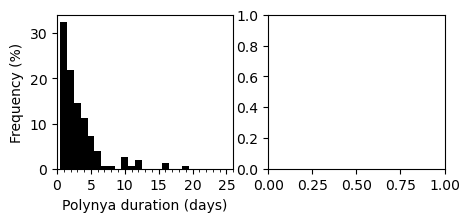

In [178]:
fig, axs = plt.subplots(1,2,figsize=(5,2))

bins = np.arange(0.5,30,1)
x = event_durations
h = plotter.quick_hist(x, bin_edges = bins)
ax = axs[0]
ax.bar(h['centers'], 100*(h['counts']/np.sum(h['counts'])), align='center', width = np.diff(bins), 
       color='k')
# ax.set_xticks([1,5,10,15,20])
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xlabel('Polynya duration (days)')
ax.set_xlim(0,26)
ax.set_ylabel('Frequency (%)')

bins = np.logspace(1.5, 12, num=70)
x = event_sizes['all']
h = plotter.quick_hist(x, bin_edges = bins)
ax = axs[1]
ax.bar(h['centers'], 100*h['counts']/np.sum(h['counts']), align='center', width = np.diff(bins), 
       color='k')
ax.set_xscale('log')
ax.set_xlim(0,50000)
# ax.set_xticks([10,100,1000,10000])

c1 = [140/255,210/255,245/255]
c2 = [110/255,170/255,215/255]
c3 = [80/255,130/255,185/255]
c4 = [50/255,100/255,145/255]

YY = 12
ax.plot([30,155],[YY,YY], c=c1, lw=5, clip_on=False)
ax.plot([155,545],[YY,YY], c=c2, lw=5, clip_on=False)
ax.plot([545,1700],[YY,YY], c=c3, lw=5, clip_on=False)
ax.plot([1700,26500],[YY,YY], c=c4, lw=5, clip_on=False)
ax.set_ylim(0,11)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
# plt.axvline(39, c='k', ls='dashed')
# plt.axvline(2*39, c='k', ls='dashed')
ax.set_xlabel('Polynya extent ($\mathrm{km^2}$)')

bot2 = YY+0.5
FS = plt.rcParams['font.size'] -0.5
ax.text(30, bot2, '$\mathrm{Q_{0}}$', ha='center', size=FS, clip_on=False)
ax.text(155, bot2, '$\mathrm{Q_{1}}$', ha='center', size=FS, clip_on=False)
ax.text(545, bot2, '$\mathrm{Q_{2}}$', ha='center', size=FS, clip_on=False)
ax.text(1700, bot2, '$\mathrm{Q_{3}}$', ha='center', size=FS, clip_on=False)
ax.text(26500, bot2, '$\mathrm{Q_{4}}$', ha='center', size=FS, clip_on=False)

# fig.savefig('../figures/results/poly_dist.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [148]:
RES = '6250'
crop=[700, 1150, 200, 400]
sic_key = 'sic'
open_thresh = 10

# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'

# sicsic = unisic.open_local_file(datetime(2019,1,16), res='1000ma2', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                             crop=[2100, 3400, 340, 800], coordinates=False, area=False, include_units=False, quiet=True)


out = unisic.calc_meansic_openfreq([datetime(2024,1,1), datetime(2024,1,2)], crop=crop, 
                                            open_thresh=open_thresh, res=RES, hem='n', sic_key = sic_key, 
                                            main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                            coordinates=False, area=False, quiet=True)

### Grab SIC maps

In [163]:

# RES = '1000ma2'
# crop = [2100, 3400, 340, 800]
# sic_key = 'sic_merged'

RES = '6250'
# crop=[500, 1300, 100, 500]
crop=[700, 1150, 200, 400]
sic_key = 'sic'

# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'

# sicsic = unisic.open_local_file(datetime(2019,1,16), res='1000ma2', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                             crop=[2100, 3400, 340, 800], coordinates=False, area=False, include_units=False, quiet=True)



dsic = unisic.open_local_file(datetime(2020,1,1), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)

# open_thresh=10

map_sic = {}

for key in ['all']:#event_dates.keys():

    print(key)
    map_sic[key] = unisic.calc_meansic_openfreq(pd.to_datetime(event_dates[key]), crop=crop, nan_frac = 0.05,
                                            open_thresh=open_thresh, res=RES, hem='n', sic_key = sic_key, 
                                            main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                            coordinates=False, area=False, quiet=True)


all


In [111]:
def dir_conds(dff, cat):
    
    if cat == 'wind':
        dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 305)
#         dir_cond = (dff['a10_r'] > 255) & (dff['a10_r'] < 305)
        
    elif cat == 'ice':
        
        dir_cond = (dff['ai_r'] > 270) & (dff['ai_r'] < 315)
    return dir_cond

def speed_conds(dff, cat):
    
    if cat == 'wind':
        speed_cond = (dff['s10'] > 7)
    elif cat == 'ice':
        speed_cond = (dff['si_km'] > 20.5)
    return speed_cond

In [40]:
dfb = df[(df.year >= 2003)&(df.year <= 2023)]
dfr = df[(df.year >= 2003)]

DF = dfb
# DF = dfr

closed = (DF.extent == 0) & (DF.day_before_event<-1)
polyny = ((DF.extent > 0) + (DF.day_before_event>=-1)) & (DF.final_day==False)
polyny[DF.single_day] = True



wind_events = dir_conds(DF, 'wind') & speed_conds(DF, 'wind')

wind_events

np.sum(wind_events&(closed))/np.sum(wind_events)

# np.sum(wind_events&polyny)/np.sum(polyny)

NameError: name 'dir_conds' is not defined

### Grab drift maps

In [154]:
# drift_map = {}

# for key in event_dates.keys():
#     print(key, len(event_dates[key]))
#     drift_map[key] = fn.drift_map_over_time(event_dates[key], map_proj, crop = False, include_times = True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    

    drift_map = {}

    for key in event_dates.keys():

        print(key, len(event_dates[key]))

        main_path = "/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/"

        ds_list = []

        yrs = pd.to_datetime(event_dates[key]).year
        for yr in list(set(yrs)):
            with xr.open_dataset(main_path+f"icemotion_daily_nh_25km_{yr}0101_{yr}1231_v4.1.nc") as ds:
                    ds['time'] = ds.indexes['time'].to_datetimeindex()
                    ds_list.append(ds.sel(time = event_dates[key][yrs==yr]))

        drift_map[key] = xr.concat(ds_list, dim='time')
#         e,n = icedrift.convert_vectors(lon=ds_ice.longitude, u_EASE=ds_ice.u, v_EASE=ds_ice.v)
#         ds_ice['e'] = e
#         ds_ice['n'] = n
#         drift_map[key] = ds_ice

all 459
comp 2295


### Open ERA maps

In [155]:
# era_map = {}

# for key in event_dates.keys():

#     print(key)
    
#     era_map[key] = fn.wind_map_over_time(event_dates[key][::15], map_proj, 
#                                          era_lat = slice(90, 60), era_lon = slice(-360,360), include_times= False)


era_map = {}

for key in event_dates.keys():

    print(key, len(event_dates[key]))

    main_path = "/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily/"

    ds_list = []

    yrs = pd.to_datetime(event_dates[key]).year
    for yr in list(set(yrs)):
        if yr%3==0:
            print(yr)
        with xr.open_dataset(main_path+f"u10-v10/era5_daily_u10-v10_{yr}.nc") as ds:
                ds = ds.sel(latitude=slice(80,66), longitude=slice(-180,-105),
                           time = event_dates[key][yrs==yr])
                ds_list.append(ds)
        with xr.open_dataset(main_path+f"msl/era5_daily_msl_{yr}.nc") as ds:
                ds = ds.sel(latitude=slice(80,66), longitude=slice(-180,-105),
                           time = event_dates[key][yrs==yr])
                ds_list.append(ds)

    era_map[key] = xr.concat(ds_list, dim='time')
#         e,n = icedrift.convert_vectors(lon=ds_ice.longitude, u_EASE=ds_ice.u, v_EASE=ds_ice.v)
#         ds_ice['e'] = e
#         ds_ice['n'] = n


all 459
2004
2007
2010
2013
2016
2019
2022
comp 2295
2004
2007
2010
2013
2016
2019
2022


In [66]:
# t2m_map = {}

# for key in event_dates.keys():

#     print(key)
    
#     t2m_map[key] = fn.t2m_map_over_time(event_dates[key][::10], map_proj, 
#                                          era_lat = slice(90, 60), era_lon = slice(-360,360), include_times= False)

all
comp


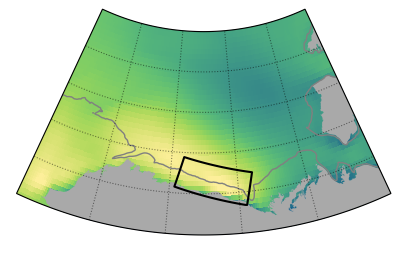

In [128]:
# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-145)

lon_range = (-170, -120)
lat_range = (68, 78)

# lon_range = (-154, -136)
# lat_range = (69, 72)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)

# Plotting
fig, ax = plt.subplots(1,1,figsize=(5,5), subplot_kw={'projection': proj})


ax.set_boundary(clip_path, transform=proj)
ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())


geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)
ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
           colors=['gray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
                      linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
gl.xlocator = FixedLocator([-170,-160, -150, -140, -130, -120])
gl.ylocator = FixedLocator([70,72,74,76,78])
gl.bottom_labels = False
gl.right_labels = False
        
# mesh = ax.pcolormesh(t2m_map['comp']['lon'], t2m_map['comp']['lat'], t2m_map['all']['t2m']-t2m_map['comp']['t2m'], 
#                vmin=-10, vmax=10, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


mesh = ax.pcolormesh(era_map['b1']['lon'], era_map['b1']['lat'], era_map['d1']['s10'], 
               vmin=0, vmax=10, cmap=cmocean.cm.haline, transform=ccrs.PlateCarree())

# mesh = ax.contourf(era_map['comp']['lon'], era_map['comp']['lat'], era_map['comp']['msl']/100, 
#                vmin=1012, vmax=1028,levels=np.arange(1012,1028+1,1), extend='both', cmap=cmocean.cm.haline, transform=ccrs.PlateCarree())


In [102]:
for year in np.arange(2002,2025):

    with xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc') as ds:

        print(year, ds.longitude.values.min(), ds.latitude.values.min())

2002 -180.0 55.0
2003 -180.0 55.0
2004 -180.0 55.0
2005 -180.0 55.0
2006 -180.0 55.0
2007 -180.0 55.0
2008 -180.0 55.0
2009 -180.0 55.0
2010 -180.0 55.0
2011 -180.0 55.0
2012 -180.0 55.0
2013 -180.0 55.0
2014 -180.0 55.0
2015 -180.0 55.0
2016 -180.0 55.0
2017 -180.0 55.0
2018 -180.0 55.0
2019 -180.0 55.0
2020 -180.0 55.0
2021 -180.0 55.0
2022 -180.0 55.0
2023 -180.0 50.0
2024 -180.0 50.0


TypeError: scalebar() got an unexpected keyword argument 'label'

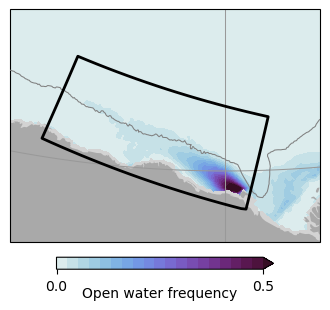

In [164]:
fig, ax = fn.makemap(view='tall_zoom', contours = [-100], 
                      panels=(1,1), figsize=(4,6))


# fig, ax = fn.makemap(view='wider_zoom2', contours = [], 
#                       panels=(1,1), figsize=(4,4))

ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [70]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-140,]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
    
FS = 10
    
    
key = 'all'
# mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 

mesh = ax.contourf(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
          vmin=0, vmax=0.5, levels = np.arange(0,0.5,0.025), 
                   extend='max', cmap=cmocean.cm.dense, transform=dsic['proj'])
    
plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.02, cb_length_fraction=[0.15, 0.85], cb_pad=0.025, cb_ticks=[0,0.5], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Open water frequency', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

# sp = 2
# u1 = 1*np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
# v1 = 1*np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
# Q = ax.quiver(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], u1[::sp,::sp], v1[::sp,::sp], 
#           angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
#           scale=1, width=0.0035, headwidth=4,headlength=4, headaxislength=4, color=[0.2,0.2,0.2], pivot='tail', zorder=100)

geomap.scalebar(ax, loc=(0.05, 0.1), steps=[50,100,150,200],unit='km', 
                label=None, colors=['k', 'w'], edgecolor=None, textsize=8, lw=1, 
                bar_width=0.025, labelpad=0.015, ticklabelpad=0.01, zorder=100, clip_on=True)

ax.text(0.85,0.415,'100 m',size = FS-2, color='gray', rotation=35,
        transform=ax.transAxes)

# qk = ax.quiverkey(Q, X=0.5, Y=0.1, U=20*1000, label='Ice drift', labelpos='E', coordinates='axes')
# \n10 $\mathrm{km\;d^{-1}}$

ax.text(0.975,1.025,'c',color='k', size=FS, weight='bold', ha='right', va='bottom', clip_on=False, transform=ax.transAxes)


# fig.savefig('../figures/results/comsposite_zoom_nocanyon.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [47]:
map_sic.keys()

dict_keys(['17', '24', 'all', 'comp'])

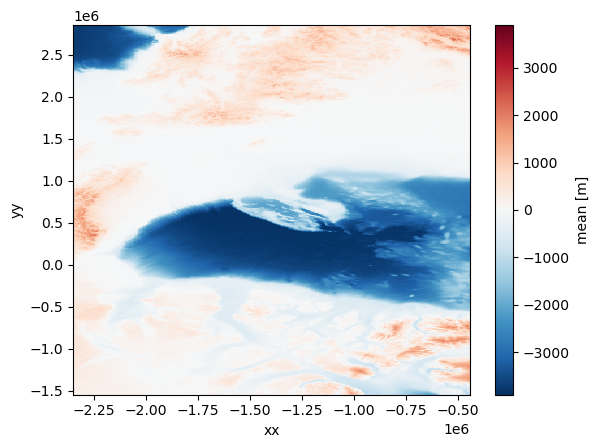

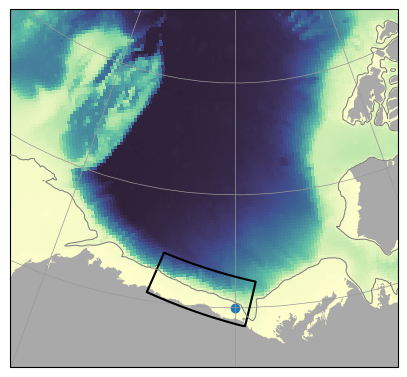

In [685]:
fig, ax = fn.makemap(view='large_view', contours = [], 
                      panels=(1,1), figsize=(5,5))
ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
FS = 12


line_kwargs = {'lw':0.5, 'c':[0.6,0.6,0.6]}
for lat in np.arange(66,90,4):
    ax.plot(np.linspace(0,359,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in np.arange(0,360,20):
    ax.plot(np.full(100,lon), np.linspace(65,90,100), transform=ccrs.PlateCarree(), **line_kwargs)

sp = 2
ax.pcolormesh(dsb.xx[::sp], dsb.yy[::sp], dsb.avg[::sp,::sp], vmin=-4000,vmax=0, cmap=cmocean.cm.deep_r,
           transform=dsic['proj'], zorder=-100)    
    
ax.scatter(-140,70, transform=ccrs.PlateCarree())

ax.contour(dsb.xx, dsb.yy, dsb.avg, levels=[-100], 
           colors=['gray'],linewidths=[0.75],linestyles='solid', transform=dsic['proj'], zorder=100)    
    

<>:109: SyntaxWarning: invalid escape sequence '\m'
<>:109: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21663/4252583918.py:109: SyntaxWarning: invalid escape sequence '\m'
  qk = ax.quiverkey(Q, X=1.025, Y=0.6, U=5, label='$\mathrm{5\;m\;s^{-1}}$\nwind', labelpos='N', coordinates='axes')


all
comp
all
comp


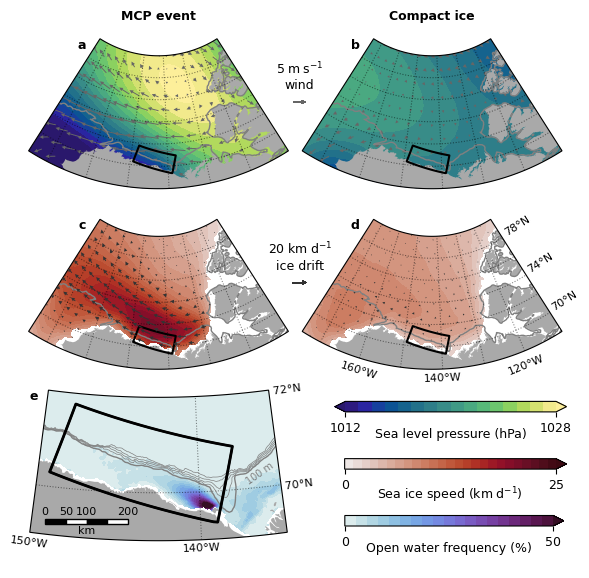

In [161]:

# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
# lon_range = (-165, -120)
# lat_range = (68, 78)


lon_range = (-175, -110)
lat_range = (68, 80)

lon_range_small = (-150, -135)
lat_range_small = (69, 72)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)
clip_path_small = create_map_box(proj, lon_range=lon_range_small, lat_range = lat_range_small)

# Plotting
fig, axs = plt.subplots(3,2,figsize=(7,7), subplot_kw={'projection': proj})

for aa, ax in enumerate(axs.ravel()[:-1]):
    
    if aa <= 3:
        ax.set_boundary(clip_path, transform=proj)
        ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
    else:
        ax.set_boundary(clip_path_small, transform=proj)
        ax.set_extent([lon_range_small[0], lon_range_small[1], 
                       lat_range_small[0]-0.75, lat_range_small[1]], crs=ccrs.PlateCarree())
        
    geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)
    ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
               colors=['gray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
    ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())

    if aa <= 4:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
                      linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
        gl.xlocator = FixedLocator([-170,-160, -150, -140, -130, -120])
        gl.ylocator = FixedLocator([70,72,74,76,78,80])
        gl.bottom_labels = False
        gl.right_labels = False

    if aa == 3: 
        for lat in [70,74,78]:
            rot = -110-(-142.5)
            ax.text(-110, lat, f"{lat}°N",
                    transform=ccrs.PlateCarree(),
                    ha='left', va='bottom', clip_on=False, rotation=rot, size=plt.rcParams['font.size']-1)
        for lon in [-160, -140, -120]:
            rot = lon-(-142.5)
            ax.text(lon, 67.75, f"{-lon}°W",
                    transform=ccrs.PlateCarree(),
                    ha='center', va='top',rotation=rot, clip_on=False, size=plt.rcParams['font.size']-1)
    elif aa == 4: 
        for lat in [70,72]:
            rot = -135-(-142.5)
            ax.text(-135, lat, f" {lat}°N",
                    transform=ccrs.PlateCarree(),
                    ha='left', va='center', clip_on=False, rotation=rot, size=plt.rcParams['font.size']-1)
        for lon in [-150,-140]:
            rot = lon-(-142.5)
            ax.text(lon, 68.95, f"{-lon}°W",
                    transform=ccrs.PlateCarree(),
                    ha='center', va='top',rotation=rot, clip_on=False, size=plt.rcParams['font.size']-1)

sp = 5

for ax, label in zip(axs[0,:], ['MCP event', 'Compact ice']):
    ax.text(0.5,1.1,label, weight='bold', ha='center', va='bottom', transform=ax.transAxes)



# atmosphere
#-----------
for ax, key, pan in zip(axs[0,:], ['all', 'comp'], ['a', 'b']):

    print(key)
    
    # sea level press
    #----------------
#     mesh = ax.pcolormesh(era_map[key]['lon'][::sp,::sp], era_map[key]['lat'][::sp,::sp],
#                        era_map[key]['msl'][::sp,::sp]/100, 
#                        vmin=1012,vmax=1028, 
#                        cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)
    mesh = ax.contourf(era_map[key]['longitude'], era_map[key]['latitude'],
                       era_map[key]['msl'].mean('time')/100, 
                       vmin=1012,vmax=1028, levels=np.arange(1012,1029,1), extend='both',
                       cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)

    # winds
    #----------------
    longrid, latgrid = np.meshgrid(era_map[key]['longitude'], era_map[key]['latitude'])
    u1 = era_map[key]['u10'].mean('time').values
    v1 = era_map[key]['v10'].mean('time').values
    U,V = geomap.fix_cartopy_vectors(u1,v1, latgrid)
    sp1, sp2 = 5,15
    Q = ax.quiver(longrid[::sp1,::sp2], latgrid[::sp1,::sp2], 
                  U[::sp1,::sp2], V[::sp1,::sp2], 
              angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
              scale=0.00004, width=0.0035, headwidth=4,headlength=4, headaxislength=4, 
                  color=[0.4,0.4,0.4], pivot='tail', zorder=1)
    
    if pan == 'a':
        qk = ax.quiverkey(Q, X=1.025, Y=0.6, U=5, label='$\mathrm{5\;m\;s^{-1}}$\nwind', labelpos='N', coordinates='axes')
        qk.set_zorder(100)
        
        plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.015, cb_length_fraction=[1.25+0.05-0.04, 2.15+0.05], cb_pad=0.315, cb_ticks=[1012, 1028], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Sea level pressure (hPa)', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

    ax.text(0.23,1.0, pan, weight='bold', ha='right', va='top', transform=ax.transAxes)

# sea ice
#-----------
for ax, key, pan in zip(axs[1,:], ['all', 'comp'], ['c', 'd']):
    
    print(key)
    
    sp=1
#     mesh = ax.pcolormesh(drift_map[key]['lon'][::sp,::sp], drift_map[key]['lat'][::sp,::sp],
#                    np.nanmean(np.sqrt(drift_map[key]['e']**2+drift_map[key]['n']**2),axis=0)[::sp,::sp], 
#                    vmin=0,vmax=25, 
#                    cmap=cmocean.cm.amp, transform=ccrs.PlateCarree(), zorder=-1)

    l1, l2 = 100, -100
    m1, m2 = 180, -80
    LON = np.copy(drift_map[key]['longitude'].mean('time').values[m1:m2,l1:l2])
    LON[LON<0]+=360
    mesh = ax.contourf(LON, drift_map[key]['latitude'].mean('time').values[m1:m2,l1:l2],
                       np.sqrt(drift_map[key]['u']**2+drift_map[key]['v']**2).mean('time').values[m1:m2,l1:l2], 
                   vmin=0,vmax=25, levels=np.arange(0,26,1), extend='max', 
                   cmap=cmocean.cm.amp, transform=ccrs.PlateCarree(), zorder=-1)

    sp = 4
    u1 = 7*drift_map[key]['u'].mean('time').values*units('cm/s').to('m/day').magnitude
    v1 = 7*drift_map[key]['v'].mean('time').values*units('cm/s').to('m/day').magnitude
    drift_proj = icedrift.grab_projection(drift_map[key])
    Q = ax.quiver(drift_map[key]['x'][::sp,], drift_map[key]['y'][::sp], u1[::sp,::sp], v1[::sp,::sp], 
              angles='xy', scale_units='xy', transform=drift_proj,
              scale=1, width=0.0035, headwidth=4,headlength=4, headaxislength=4, color=[0.2,0.2,0.2], pivot='tail', zorder=100)

#     qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=7*20000, label='$\mathrm{20\;km\;d^{-1}}$ ice drift', labelpos='E', coordinates='axes')

    if pan == 'c':
        qk = ax.quiverkey(Q, X=1.025, Y=0.6, U=7*20000, label=r"$\mathrm{20\;km\;d^{-1}}$"+"\nice drift", labelpos='N', coordinates='axes')
        qk.set_zorder(100)
        
        plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.015, cb_length_fraction=[1.25+0.05, 2.15+0.05], cb_pad=0.125, cb_ticks=[0,25], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label=r'Sea ice speed ($\mathrm{km\;d^{-1}}$)', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])
        
    ax.text(0.23,1.0, pan, weight='bold', ha='right', va='top', transform=ax.transAxes)
        
        
# polynya
for ax, key, pan in zip([axs[2,0]], ['all'], ['e']):
    
    mesh = ax.contourf(map_sic[key]['xx'], map_sic[key]['yy'], 100*map_sic[key]['open_freq'], 
                       vmin=0, vmax=50, levels = np.arange(0,50,2.5), 
               extend='max', cmap=cmocean.cm.dense, transform=dsic['proj'])

    sp = 20
    ax.contour(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
                   levels=[-500,-400,-300,-200,],
                   linewidths=0.5, linestyles='solid', colors=['gray'], transform=ccrs.PlateCarree())
    
    ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    ax.text(0.05,1.0, pan, weight='bold', ha='right', va='top', transform=ax.transAxes)
    
    geomap.scalebar(ax, loc=(0.075, 0.25), steps=[50,100,150,200,], 
                    custom_tick_labels=[0,50,100,'', 200,], tick_side='top',
                    unit='km', 
                unit_label=None, unit_label_side='bottom', colors=['k', 'w'], edgecolor=None, textsize=8, lw=1, 
                bar_width=0.025, labelpad=0.015, ticklabelpad=0.01, zorder=1000, clip_on=False)

    ax.text(0.82,0.47,'100 m',size = plt.rcParams['font.size']-2, color='gray', rotation=35,
            transform=ax.transAxes)
    
    plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.015, cb_length_fraction=[1.25+0.03+0.05, 2.15+0.1], cb_pad=-0.075, cb_ticks=[0,50], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Open water frequency (%)', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])


plt.subplots_adjust(hspace=0.015, wspace=0.0175)



axs[2,1].set_frame_on(False) 


SAVE(fig, '../figures/results/forcing_maps/Fig03.png')

# SAVE(fig, '/Users/mackenziejewell/Desktop/Fig03.png')

# plt.show()

<>:109: SyntaxWarning: invalid escape sequence '\m'
<>:149: SyntaxWarning: invalid escape sequence '\m'
<>:154: SyntaxWarning: invalid escape sequence '\m'
<>:109: SyntaxWarning: invalid escape sequence '\m'
<>:149: SyntaxWarning: invalid escape sequence '\m'
<>:154: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21663/2762609182.py:109: SyntaxWarning: invalid escape sequence '\m'
  qk = ax.quiverkey(Q, X=1.025, Y=0.6, U=5, label='$\mathrm{5\;m\;s^{-1}}$\nwind', labelpos='N', coordinates='axes')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21663/2762609182.py:149: SyntaxWarning: invalid escape sequence '\m'
  qk = ax.quiverkey(Q, X=1.025, Y=0.6, U=7*20000, label='$\mathrm{20\;km\;d^{-1}}$\nice drift', labelpos='N', coordinates='axes')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21663/2762609182.py:154: SyntaxWarning: invalid escape sequence '\m'
  cb_ticklabels='auto', cb_extend='neither', cb_label='Se

all


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21663/2762609182.py:109: SyntaxWarning: invalid escape sequence '\m'
  qk = ax.quiverkey(Q, X=1.025, Y=0.6, U=5, label='$\mathrm{5\;m\;s^{-1}}$\nwind', labelpos='N', coordinates='axes')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21663/2762609182.py:149: SyntaxWarning: invalid escape sequence '\m'
  qk = ax.quiverkey(Q, X=1.025, Y=0.6, U=7*20000, label='$\mathrm{20\;km\;d^{-1}}$\nice drift', labelpos='N', coordinates='axes')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_21663/2762609182.py:154: SyntaxWarning: invalid escape sequence '\m'
  cb_ticklabels='auto', cb_extend='neither', cb_label='Sea ice speed ($\mathrm{km\;d^{-1}}$)', labelpad=-5,


KeyError: 'lon'

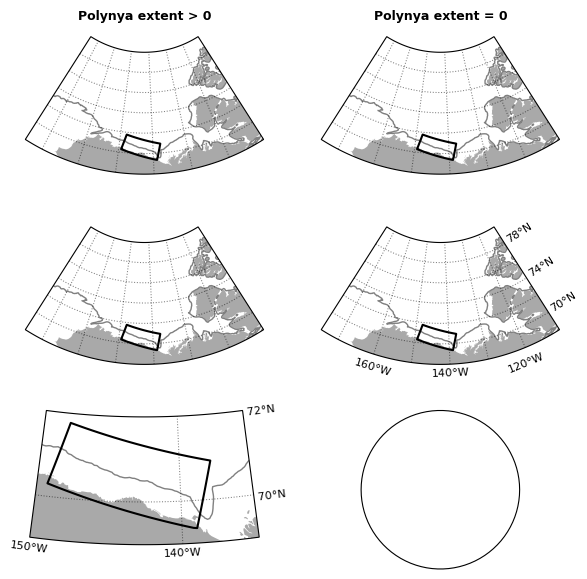

In [159]:

# Define projections
proj = ccrs.NorthPolarStereo(central_longitude=-142.5)

# map bound
# lon_range = (-165, -120)
# lat_range = (68, 78)


lon_range = (-175, -110)
lat_range = (68, 80)

lon_range_small = (-150, -135)
lat_range_small = (69, 72)


FS = 9

# grab box border
clip_path = create_map_box(proj, lon_range=lon_range, lat_range = lat_range)
clip_path_small = create_map_box(proj, lon_range=lon_range_small, lat_range = lat_range_small)

# Plotting
fig, axs = plt.subplots(3,2,figsize=(7,7), subplot_kw={'projection': proj})

for aa, ax in enumerate(axs.ravel()[:-1]):
    
    if aa <= 3:
        ax.set_boundary(clip_path, transform=proj)
        ax.set_extent([lon_range[0], lon_range[1], lat_range[0]-0.75, lat_range[1]], crs=ccrs.PlateCarree())
    else:
        ax.set_boundary(clip_path_small, transform=proj)
        ax.set_extent([lon_range_small[0], lon_range_small[1], 
                       lat_range_small[0]-0.75, lat_range_small[1]], crs=ccrs.PlateCarree())
        
    geomap.land(ax, scale='10m', color='darkgray', alpha=1, fill_dateline_gap=True, zorder=2)
    ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
               colors=['gray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])
    ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())

    if aa <= 4:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), #draw_labels=True,
                      linewidth=0.75, color='k', alpha=0.5, linestyle='dotted')
        gl.xlocator = FixedLocator([-170,-160, -150, -140, -130, -120])
        gl.ylocator = FixedLocator([70,72,74,76,78,80])
        gl.bottom_labels = False
        gl.right_labels = False

    if aa == 3: 
        for lat in [70,74,78]:
            rot = -110-(-142.5)
            ax.text(-110, lat, f"{lat}°N",
                    transform=ccrs.PlateCarree(),
                    ha='left', va='bottom', clip_on=False, rotation=rot, size=plt.rcParams['font.size']-1)
        for lon in [-160, -140, -120]:
            rot = lon-(-142.5)
            ax.text(lon, 67.75, f"{-lon}°W",
                    transform=ccrs.PlateCarree(),
                    ha='center', va='top',rotation=rot, clip_on=False, size=plt.rcParams['font.size']-1)
    elif aa == 4: 
        for lat in [70,72]:
            rot = -135-(-142.5)
            ax.text(-135, lat, f" {lat}°N",
                    transform=ccrs.PlateCarree(),
                    ha='left', va='center', clip_on=False, rotation=rot, size=plt.rcParams['font.size']-1)
        for lon in [-150,-140]:
            rot = lon-(-142.5)
            ax.text(lon, 68.95, f"{-lon}°W",
                    transform=ccrs.PlateCarree(),
                    ha='center', va='top',rotation=rot, clip_on=False, size=plt.rcParams['font.size']-1)

sp = 5

for ax, label in zip(axs[0,:], ['Polynya extent > 0', 'Polynya extent = 0']):
    ax.text(0.5,1.1,label, weight='bold', ha='center', va='bottom', transform=ax.transAxes)



# atmosphere
#-----------
for ax, key, pan in zip(axs[0,:], ['all', 'comp'], ['a', 'b']):

    print(key)
    
    # sea level press
    #----------------
    sp=1
#     mesh = ax.pcolormesh(era_map[key]['lon'][::sp,::sp], era_map[key]['lat'][::sp,::sp],
#                        era_map[key]['msl'][::sp,::sp]/100, 
#                        vmin=1012,vmax=1028, 
#                        cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)
    mesh = ax.contourf(era_map[key]['lon'][::sp,::sp], era_map[key]['lat'][::sp,::sp],
                       era_map[key]['msl'][::sp,::sp]/100, 
                       vmin=1012,vmax=1028, levels=np.arange(1012,1029,1), extend='both',
                       cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)

    # winds
    #----------------
    u1 = era_map[key]['u10']
    v1 = era_map[key]['v10']
    U,V = geomap.fix_cartopy_vectors(u1,v1, era_map[key]['lat'])
    sp1, sp2 = 5,15
    Q = ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], 
                  U[::sp1,::sp2], V[::sp1,::sp2], 
              angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
              scale=0.00004, width=0.0035, headwidth=4,headlength=4, headaxislength=4, 
                  color=[0.4,0.4,0.4], pivot='tail', zorder=1)
    
    if pan == 'a':
        qk = ax.quiverkey(Q, X=1.025, Y=0.6, U=5, label='$\mathrm{5\;m\;s^{-1}}$\nwind', labelpos='N', coordinates='axes')
        qk.set_zorder(100)
        
        plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.015, cb_length_fraction=[1.25+0.05-0.04, 2.15+0.05], cb_pad=0.315, cb_ticks=[1012, 1028], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Sea level pressure (hPa)', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

    ax.text(0.23,1.0, pan, weight='bold', ha='right', va='top', transform=ax.transAxes)

# sea ice
#-----------
for ax, key, pan in zip(axs[1,:], ['all', 'comp'], ['c', 'd']):
    
    print(key)
    
    sp=1
#     mesh = ax.pcolormesh(drift_map[key]['lon'][::sp,::sp], drift_map[key]['lat'][::sp,::sp],
#                    np.nanmean(np.sqrt(drift_map[key]['e']**2+drift_map[key]['n']**2),axis=0)[::sp,::sp], 
#                    vmin=0,vmax=25, 
#                    cmap=cmocean.cm.amp, transform=ccrs.PlateCarree(), zorder=-1)

    l1, l2 = 100, -100
    m1, m2 = 180, -80
    mesh = ax.contourf(drift_map[key]['lon'][m1:m2,l1:l2], drift_map[key]['lat'][m1:m2,l1:l2],
                   np.nanmean(np.sqrt(drift_map[key]['e']**2+drift_map[key]['n']**2),axis=0)[m1:m2,l1:l2], 
                   vmin=0,vmax=25, levels=np.arange(0,26,1), extend='max', 
                   cmap=cmocean.cm.amp, transform=ccrs.PlateCarree(), zorder=-1)

    sp = 4
    u1 = 7*np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
    v1 = 7*np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
    Q = ax.quiver(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], u1[::sp,::sp], v1[::sp,::sp], 
              angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
              scale=1, width=0.0035, headwidth=4,headlength=4, headaxislength=4, color=[0.2,0.2,0.2], pivot='tail', zorder=100)

#     qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=7*20000, label='$\mathrm{20\;km\;d^{-1}}$ ice drift', labelpos='E', coordinates='axes')

    if pan == 'c':
        qk = ax.quiverkey(Q, X=1.025, Y=0.6, U=7*20000, label='$\mathrm{20\;km\;d^{-1}}$\nice drift', labelpos='N', coordinates='axes')
        qk.set_zorder(100)
        
        plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.015, cb_length_fraction=[1.25+0.05, 2.15+0.05], cb_pad=0.125, cb_ticks=[0,25], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Sea ice speed ($\mathrm{km\;d^{-1}}$)', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])
        
    ax.text(0.23,1.0, pan, weight='bold', ha='right', va='top', transform=ax.transAxes)
        
        
# polynya
for ax, key, pan in zip([axs[2,0]], ['all'], ['e']):
    
    mesh = ax.contourf(map_sic[key]['xx'], map_sic[key]['yy'], 100*map_sic[key]['open_freq'], 
                       vmin=0, vmax=50, levels = np.arange(0,50,2.5), 
               extend='max', cmap=cmocean.cm.dense, transform=dsic['proj'])

    sp = 20
    ax.contour(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
                   levels=[-500,-400,-300,-200,],
                   linewidths=0.5, linestyles='solid', colors=['gray'], transform=ccrs.PlateCarree())
    
    ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    ax.text(0.05,1.0, pan, weight='bold', ha='right', va='top', transform=ax.transAxes)
    
    geomap.scalebar(ax, loc=(0.075, 0.25), steps=[50,100,150,200,], 
                    custom_tick_labels=[0,50,100,'', 200,], tick_side='top',
                    unit='km', 
                unit_label=None, unit_label_side='bottom', colors=['k', 'w'], edgecolor=None, textsize=8, lw=1, 
                bar_width=0.025, labelpad=0.015, ticklabelpad=0.01, zorder=1000, clip_on=False)

    ax.text(0.82,0.47,'100 m',size = plt.rcParams['font.size']-2, color='gray', rotation=35,
            transform=ax.transAxes)
    
    plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.015, cb_length_fraction=[1.25+0.03+0.05, 2.15+0.1], cb_pad=-0.075, cb_ticks=[0,50], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Open water frequency (%)', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])


plt.subplots_adjust(hspace=0.015, wspace=0.0175)



axs[2,1].set_frame_on(False) 


SAVE(fig, '../figures/results/forcing_maps/Fig03.png')

# plt.show()

In [ ]:

# ax.contour(dsb['xx'], dsb['yy'], dsb['avg'], levels=[-100], 
#            colors=['darkgray'], linewidths=[1],linestyles=['solid'], transform=dsic['proj'])

# sp = 20
# ax.contour(dsb2.lon[::sp], dsb2.lat[::sp], dsb2.elevation[::sp,::sp],
#                    levels=[-500,-400,-300,-200,],
#                    linewidths=0.5, linestyles='solid', colors=['darkgray'], transform=ccrs.PlateCarree())



# ax = axs[1,0]
# key = 'clim'
# mesh = ax.pcolormesh(era_map[key]['lon'][::sp,::sp], era_map[key]['lat'][::sp,::sp],
#                    era_map[key]['msl'][::sp,::sp]/100, 
#                    vmin=1010,vmax=1030, 
#                    cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)

# sp = 5
# ax = axs[0,1]
# key = 'all'
# mesh = ax.pcolormesh(drift_map[key]['lon'][::sp,::sp], drift_map[key]['lat'][::sp,::sp],
#                    np.nanmean(np.sqrt(drift_map[key]['e']**2+drift_map[key]['n']**2),axis=0)[::sp,::sp], 
#                    vmin=0,vmax=30, 
#                    cmap=cmocean.cm.speed, transform=ccrs.PlateCarree(), zorder=-1)

# ax = axs[1,1]
# key = 'clim'
# mesh = ax.pcolormesh(drift_map[key]['lon'][::sp,::sp], drift_map[key]['lat'][::sp,::sp],
#                    np.nanmean(np.sqrt(drift_map[key]['e']**2+drift_map[key]['n']**2),axis=0)[::sp,::sp], 
#                    vmin=0,vmax=30, 
#                    cmap=cmocean.cm.speed, transform=ccrs.PlateCarree(), zorder=-1)

# plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
#                      cb_width=0.025, cb_length_fraction=[0.2, 0.8], cb_pad=0.05, cb_ticks=[1000, 1020,1030], 
#                      cb_ticklabels='auto', cb_extend='neither', cb_label='\nSea level pressure (hPa)', labelpad=-5, 
#                      cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
#                      cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

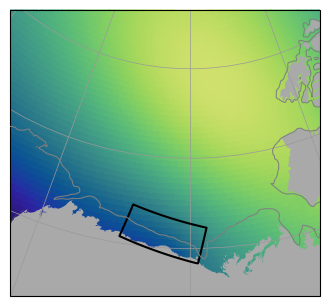

In [24]:
fig, ax = fn.makemap(view='large_view', contours = [], 
                      panels=(1,1), figsize=(4,4))
ax.add_geometries ([reg_poly], lw=1.5, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
FS = 12


line_kwargs = {'lw':0.5, 'c':[0.6,0.6,0.6]}
for lat in np.arange(66,90,4):
    ax.plot(np.linspace(0,359,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in np.arange(0,360,20):
    ax.plot(np.full(100,lon), np.linspace(65,90,100), transform=ccrs.PlateCarree(), **line_kwargs)
ax.contour(dsb.xx, dsb.yy, dsb.avg, levels=[-100], 
           colors=['gray'],linewidths=[0.75],linestyles='solid', transform=dsic['proj'], zorder=100)    
    
    
sp = 1
mesh = ax.pcolormesh(era_map[key]['lon'][::sp,::sp], era_map[key]['lat'][::sp,::sp],
                   np.nanmean(era_map[key]['msl'], axis=0)[::sp,::sp]/100, 
                   vmin=1010,vmax=1030, 
                   cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)

# mesh = ax.contourf(era_map[key]['lon'], era_map[key]['lat'],
#                    np.nanmean(era_map[key]['msl'], axis=0)/100, 
#                    vmin=1010,vmax=1030, extend='both', levels=np.arange(1010,1030,1),
#                    cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)

<>:82: SyntaxWarning: invalid escape sequence '\m'
<>:82: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48279/392412944.py:82: SyntaxWarning: invalid escape sequence '\m'
  qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=5, label='$\mathrm{5\;m\;s^{-1}}$ wind', labelpos='E', coordinates='axes')


(<matplotlib.colorbar.Colorbar at 0x14ea2fa70>,
 <Axes: xlabel='\nSea level pressure (hPa)'>)

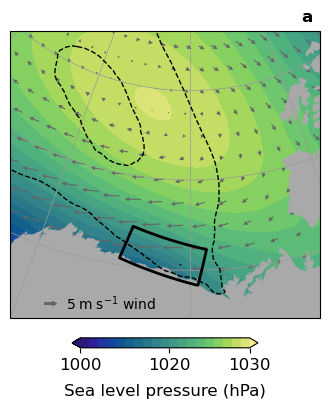

In [177]:
fig, ax = fn.makemap(view='large_view', contours = [], 
                      panels=(1,1), figsize=(4,4))


# fig, ax = fn.makemap(view='wider_zoom2', contours = [], 
#                       panels=(1,1), figsize=(4,4))


FS = 12

ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.5, 'c':[0.6,0.6,0.6]}
for lat in np.arange(66,90,4):
    ax.plot(np.linspace(0,359,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in np.arange(0,360,20):
    ax.plot(np.full(100,lon), np.linspace(65,90,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
key = 'close_wind'
u1 = np.nanmean(era_map[key]['u10'], axis=0)
v1 = np.nanmean(era_map[key]['v10'], axis=0)
s1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)

key2 = 'open_wind'
u2 = np.nanmean(era_map[key2]['u10'], axis=0)
v2 = np.nanmean(era_map[key2]['v10'], axis=0)
s2 = np.nanmean(np.sqrt(era_map[key2]['u10']**2+era_map[key2]['v10']**2), axis=0)

vec_diff = np.sqrt((u1-u2)**2+(v1-v2)**2)

dc1 = np.sqrt(u1**2+v1**2)/s1

all_u = np.concatenate((era_map[key]['u10'], era_map[key2]['u10']), axis=0)
all_v = np.concatenate((era_map[key]['v10'], era_map[key2]['v10']), axis=0)
all_s = np.nanmean(np.sqrt(all_u**2 + all_v**2), axis=0)
dc_all = np.sqrt(np.nanmean(all_u, axis=0)**2+np.nanmean(all_v, axis=0)**2) / all_s



norm_vec_diff = vec_diff  / all_s
    
ax.text(0.975,1.025,'a',color='k', size=FS, weight='bold', ha='right', va='bottom', clip_on=False,transform=ax.transAxes)


# sp = 5
# mesh = ax.pcolormesh(era_map[key]['lon'][::sp,::sp], era_map[key]['lat'][::sp,::sp],
#            np.nanmean(era_map[key]['msl'][:,::sp,::sp], axis=0)/100, 
#               vmin=1010,vmax=1030, extend='both', levels=np.arange(1010,1030,1),
#               cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)




mesh = ax.contourf(era_map[key]['lon'], era_map[key]['lat'],
           np.nanmean(era_map[key]['msl'], axis=0)/100, 
              vmin=1010,vmax=1030, extend='both', levels=np.arange(1010,1030,1),
              cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)


# ax.contourf(era_map[key]['lon'], era_map[key]['lat'], vec_diff, 
#                  levels=[6,20], colors=['k'], alpha=0.1, linestyles='dashed', linewidths=1, transform=ccrs.PlateCarree())
ax.contour(era_map[key]['lon'], era_map[key]['lat'], vec_diff, 
                 levels=[2,3,], colors=['k'], linestyles='dashed', linewidths=1, transform=ccrs.PlateCarree())

# ax.contour(era_map[key]['lon'], era_map[key]['lat'], dc1-dc_all, 
#                  levels=[0.65], colors=['k'], linestyles='dashed', linewidths=1, transform=ccrs.PlateCarree())


# sp1, sp2 = 1,3
# ax.scatter(era_map[key]['lon'][::sp1,::sp2][vec_diff[::sp1,::sp2]>7], 
#            era_map[key]['lat'][::sp1,::sp2][vec_diff[::sp1,::sp2]>7],
#            c='k', s=1, transform=ccrs.PlateCarree())

# wind vectors
U,V =geomap.fix_cartopy_vectors(u1,v1, era_map[key]['lat'])
sp1, sp2 = 4,13
Q = ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], U[::sp1,::sp2], V[::sp1,::sp2], 
          angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
          scale=0.00008, width=0.0035, headwidth=4,headlength=4, headaxislength=4, 
              color=[0.4,0.4,0.4], pivot='tail', zorder=1)
qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=5, label='$\mathrm{5\;m\;s^{-1}}$ wind', labelpos='E', coordinates='axes')
qk.set_zorder(100)

# ax.contour(dsb.xx, dsb.yy, dsb.avg, levels=[-100], 
#            colors=['gray'],linewidths=[0.75],linestyles='solid', transform=dsic['proj'])

plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.025, cb_length_fraction=[0.2, 0.8], cb_pad=0.05, cb_ticks=[1000, 1020,1030], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='\nSea level pressure (hPa)', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

# fig.savefig('../figures/results/composite_wide_atm.png', dpi=400, bbox_inches='tight', pad_inches=0)


<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48279/2384386400.py:58: SyntaxWarning: invalid escape sequence '\m'
  qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=7*20000, label='$\mathrm{20\;km\;d^{-1}}$ ice drift', labelpos='E', coordinates='axes')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48279/2384386400.py:63: SyntaxWarning: invalid escape sequence '\m'
  cb_ticklabels='auto', cb_extend='neither', cb_label='\nSea ice speed ($\mathrm{km\;d^{-1}}$)', labelpad=-5,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48279/2384386400.py:26: RuntimeWarning: Mean of empty slice
  u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('km/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48279/2384386400.py:27: RuntimeWarning: M

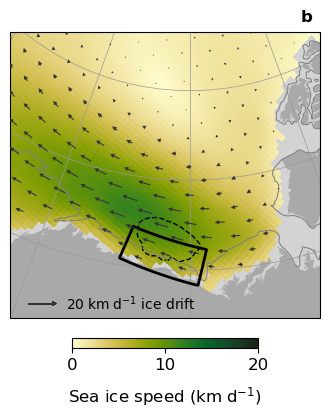

In [181]:
fig, ax = fn.makemap(view='large_view', contours = [], 
                      panels=(1,1), figsize=(4,4))


# fig, ax = fn.makemap(view='wider_zoom2', contours = [], 
#                       panels=(1,1), figsize=(4,4))


FS = 12

ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.5, 'c':[0.6,0.6,0.6]}
for lat in np.arange(66,90,4):
    ax.plot(np.linspace(0,359,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in np.arange(0,360,20):
    ax.plot(np.full(100,lon), np.linspace(65,90,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
    
ax.text(0.975,1.025,'b',color='k', size=FS, weight='bold', ha='right', va='bottom', clip_on=False,transform=ax.transAxes)


key = 'close_wind'
sp = 1
u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('km/day').magnitude
v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('km/day').magnitude
s1 = np.nanmean(np.sqrt(drift_map[key]['u']**2+drift_map[key]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
sm = np.sqrt(u1**2+v1**2)
mesh = ax.pcolormesh(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], sm[::sp,::sp], 
             vmin=0, vmax=20, transform=drift_map[key]['proj'], cmap=cmocean.cm.speed)

# vector difference
key2 = 'open_wind'
u2 = np.nanmean(drift_map[key2]['u'], axis=0)*units('cm/s').to('km/day').magnitude
v2 = np.nanmean(drift_map[key2]['v'], axis=0)*units('cm/s').to('km/day').magnitude
vec_diff = np.sqrt((u1-u2)**2+(v1-v2)**2)
# ax.contourf(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], vec_diff[::sp,::sp], 
#                  levels=[10,100], colors=['k'], linestyles='dashed', alpha=0.05, linewidths=1, transform=drift_map[key]['proj'])
ax.contour(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], vec_diff[::sp,::sp], 
                 levels=[9,11,13], colors=['k'], linestyles='dashed', linewidths=1, transform=drift_map[key]['proj'])


# sp = 1
# ax.scatter(drift_map[key]['xx'][::sp,::sp][vec_diff[::sp,::sp]>11], 
#            drift_map[key]['yy'][::sp,::sp][vec_diff[::sp,::sp]>11],
#            c='k', s=1, transform=drift_map[key]['proj'])



sp = 4
u1 = 7*np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
v1 = 7*np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
Q = ax.quiver(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], u1[::sp,::sp], v1[::sp,::sp], 
          angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
          scale=1, width=0.0035, headwidth=4,headlength=4, headaxislength=4, color=[0.2,0.2,0.2], pivot='tail', zorder=100)

qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=7*20000, label='$\mathrm{20\;km\;d^{-1}}$ ice drift', labelpos='E', coordinates='axes')


plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.025, cb_length_fraction=[0.2, 0.8], cb_pad=0.05, cb_ticks=[0,10,20], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='\nSea ice speed ($\mathrm{km\;d^{-1}}$)', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

# plotter.add_colorbar(fig, ax, [mesh], cb_placement='top', cb_orientation='auto', 
#                      cb_width=0.025, cb_length_fraction=[0.2, 0.8], cb_pad=0.05, cb_ticks=[1000, 1020,1030], 
#                      cb_ticklabels='auto', cb_extend='neither', cb_label='Sea level pressure (hPa)\n', labelpad=-5, 
#                      cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
#                      cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])


ax.contour(dsb.xx, dsb.yy, dsb.avg, levels=[-100], 
           colors=['gray'],linewidths=[0.75],linestyles='solid', transform=dsic['proj'])


In [210]:
key = 'all'
u1 = np.nanmean(era_map[key]['u10'], axis=0)
v1 = np.nanmean(era_map[key]['v10'], axis=0)
s1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)

key2 = 'comp'
u2 = np.nanmean(era_map[key2]['u10'], axis=0)
v2 = np.nanmean(era_map[key2]['v10'], axis=0)
s2 = np.nanmean(np.sqrt(era_map[key2]['u10']**2+era_map[key2]['v10']**2), axis=0)

vec_diff = np.sqrt((u1-u2)**2+(v1-v2)**2)

dc1 = np.sqrt(u1**2+v1**2)/s1

all_u = np.concatenate((era_map[key]['u10'], era_map[key2]['u10']), axis=0)
all_v = np.concatenate((era_map[key]['v10'], era_map[key2]['v10']), axis=0)
all_s = np.nanmean(np.sqrt(all_u**2 + all_v**2), axis=0)
dc_all = np.sqrt(np.nanmean(all_u, axis=0)**2+np.nanmean(all_v, axis=0)**2) / all_s



norm_vec_diff = vec_diff  / all_s


<>:70: SyntaxWarning: invalid escape sequence '\m'
<>:70: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60892/1671227203.py:70: SyntaxWarning: invalid escape sequence '\m'
  qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=5, label='$\mathrm{5\;m\;s^{-1}}$ wind', labelpos='E', coordinates='axes')


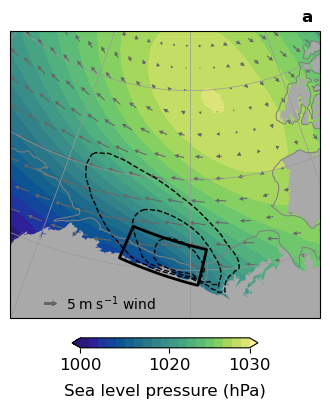

In [211]:
fig, ax = fn.makemap(view='large_view', contours = [], 
                      panels=(1,1), figsize=(4,4))


# fig, ax = fn.makemap(view='wider_zoom2', contours = [], 
#                       panels=(1,1), figsize=(4,4))


FS = 12

ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.5, 'c':[0.6,0.6,0.6]}
for lat in np.arange(66,90,4):
    ax.plot(np.linspace(0,359,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in np.arange(0,360,20):
    ax.plot(np.full(100,lon), np.linspace(65,90,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
    
# key = 'all'
# u1 = np.nanmean(era_map[key]['u10'], axis=0)
# v1 = np.nanmean(era_map[key]['v10'], axis=0)

# key2 = 'comp'
# u2 = np.nanmean(era_map[key2]['u10'], axis=0)
# v2 = np.nanmean(era_map[key2]['v10'], axis=0)

# vec_diff = np.sqrt((u1-u2)**2+(v1-v2)**2)
    
ax.text(0.975,1.025,'a',color='k', size=FS, weight='bold', ha='right', va='bottom', clip_on=False,transform=ax.transAxes)


# sp = 5
# mesh = ax.pcolormesh(era_map[key]['lon'][::sp,::sp], era_map[key]['lat'][::sp,::sp],
#            np.nanmean(era_map[key]['msl'][:,::sp,::sp], axis=0)/100, 
#               vmin=1010,vmax=1030, extend='both', levels=np.arange(1010,1030,1),
#               cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)




mesh = ax.contourf(era_map[key]['lon'], era_map[key]['lat'],
           np.nanmean(era_map[key]['msl'], axis=0)/100, 
              vmin=1010,vmax=1030, extend='both', levels=np.arange(1010,1030,1),
              cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-1)


# ax.contourf(era_map[key]['lon'], era_map[key]['lat'], vec_diff, 
#                  levels=[6,20], colors=['k'], alpha=0.1, linestyles='dashed', linewidths=1, transform=ccrs.PlateCarree())
ax.contour(era_map[key]['lon'], era_map[key]['lat'], vec_diff, 
                 levels=[6,7,8], colors=['k'], linestyles='dashed', linewidths=1, transform=ccrs.PlateCarree())

# ax.contour(era_map[key]['lon'], era_map[key]['lat'], dc1-dc_all, 
#                  levels=[0.65], colors=['k'], linestyles='dashed', linewidths=1, transform=ccrs.PlateCarree())


# sp1, sp2 = 1,3
# ax.scatter(era_map[key]['lon'][::sp1,::sp2][vec_diff[::sp1,::sp2]>7], 
#            era_map[key]['lat'][::sp1,::sp2][vec_diff[::sp1,::sp2]>7],
#            c='k', s=1, transform=ccrs.PlateCarree())

# wind vectors
U,V =geomap.fix_cartopy_vectors(u1,v1, era_map[key]['lat'])
sp1, sp2 = 4,13
Q = ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], U[::sp1,::sp2], V[::sp1,::sp2], 
          angles='xy', scale_units='xy', transform=ccrs.PlateCarree(),
          scale=0.00008, width=0.0035, headwidth=4,headlength=4, headaxislength=4, 
              color=[0.4,0.4,0.4], pivot='tail', zorder=1)
qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=5, label='$\mathrm{5\;m\;s^{-1}}$ wind', labelpos='E', coordinates='axes')
qk.set_zorder(100)

ax.contour(dsb.xx, dsb.yy, dsb.avg, levels=[-100], 
           colors=['gray'],linewidths=[0.75],linestyles='solid', transform=dsic['proj'])

plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.025, cb_length_fraction=[0.2, 0.8], cb_pad=0.05, cb_ticks=[1000, 1020,1030], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='\nSea level pressure (hPa)', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

fig.savefig('../figures/results/composite_wide_atm.png', dpi=400, bbox_inches='tight', pad_inches=0)


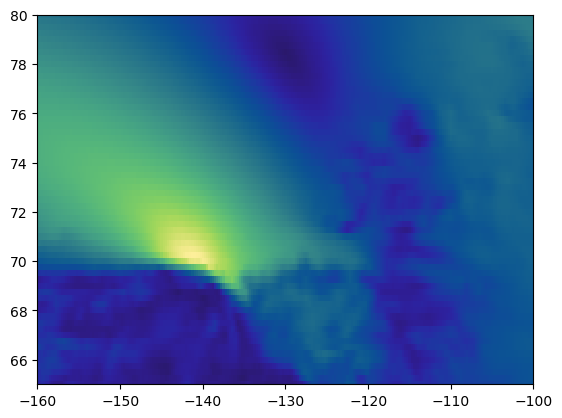

In [138]:
fig, ax = plt.subplots()
ax.set_xlim(-160,-100)
ax.set_ylim(65,80)

key = 'all'
u1 = np.nanmean(era_map[key]['u10'], axis=0)
v1 = np.nanmean(era_map[key]['v10'], axis=0)

key2 = 'comp'
u2 = np.nanmean(era_map[key2]['u10'], axis=0)
v2 = np.nanmean(era_map[key2]['v10'], axis=0)

vec_diff = np.sqrt((u1-u2)**2+(v1-v2)**2)

norm_bg = np.sqrt((u1-u2)**2+(v1-v2)**2)

# ax.contour(era_map[key]['lon'], era_map[key]['lat'], vec_diff, 
#                  levels=[6], colors=['k'], linestyles='dotted', linewidths=1.5)


ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'], vec_diff, 
              cmap=cmocean.cm.haline, )



In [98]:
0.02*6 * units('m/s').to('km/day')

<Quantity(10.368, 'kilometer / day')>

<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60892/226361541.py:58: SyntaxWarning: invalid escape sequence '\m'
  qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=7*20000, label='$\mathrm{20\;km\;d^{-1}}$ ice drift', labelpos='E', coordinates='axes')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60892/226361541.py:63: SyntaxWarning: invalid escape sequence '\m'
  cb_ticklabels='auto', cb_extend='neither', cb_label='\nSea ice speed ($\mathrm{km\;d^{-1}}$)', labelpad=-5,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60892/226361541.py:26: RuntimeWarning: Mean of empty slice
  u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('km/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_60892/226361541.py:27: RuntimeWarning: Mean 

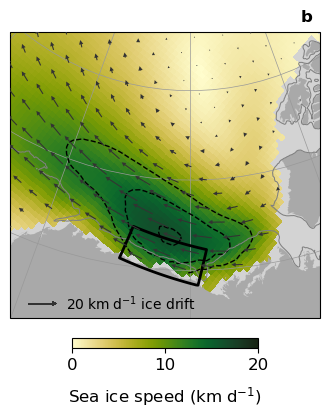

In [212]:
fig, ax = fn.makemap(view='large_view', contours = [], 
                      panels=(1,1), figsize=(4,4))


# fig, ax = fn.makemap(view='wider_zoom2', contours = [], 
#                       panels=(1,1), figsize=(4,4))


FS = 12

ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.5, 'c':[0.6,0.6,0.6]}
for lat in np.arange(66,90,4):
    ax.plot(np.linspace(0,359,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in np.arange(0,360,20):
    ax.plot(np.full(100,lon), np.linspace(65,90,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
    
ax.text(0.975,1.025,'b',color='k', size=FS, weight='bold', ha='right', va='bottom', clip_on=False,transform=ax.transAxes)


key = 'all'
sp = 1
u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('km/day').magnitude
v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('km/day').magnitude
s1 = np.nanmean(np.sqrt(drift_map[key]['u']**2+drift_map[key]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
sm = np.sqrt(u1**2+v1**2)
mesh = ax.pcolormesh(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], sm[::sp,::sp], 
             vmin=0, vmax=20, transform=drift_map[key]['proj'], cmap=cmocean.cm.speed)

# vector difference
key2 = 'comp'
u2 = np.nanmean(drift_map[key2]['u'], axis=0)*units('cm/s').to('km/day').magnitude
v2 = np.nanmean(drift_map[key2]['v'], axis=0)*units('cm/s').to('km/day').magnitude
vec_diff = np.sqrt((u1-u2)**2+(v1-v2)**2)
# ax.contourf(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], vec_diff[::sp,::sp], 
#                  levels=[10,100], colors=['k'], linestyles='dashed', alpha=0.05, linewidths=1, transform=drift_map[key]['proj'])
ax.contour(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], vec_diff[::sp,::sp], 
                 levels=[9,11,13], colors=['k'], linestyles='dashed', linewidths=1, transform=drift_map[key]['proj'])


# sp = 1
# ax.scatter(drift_map[key]['xx'][::sp,::sp][vec_diff[::sp,::sp]>11], 
#            drift_map[key]['yy'][::sp,::sp][vec_diff[::sp,::sp]>11],
#            c='k', s=1, transform=drift_map[key]['proj'])



sp = 4
u1 = 7*np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
v1 = 7*np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
Q = ax.quiver(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], u1[::sp,::sp], v1[::sp,::sp], 
          angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
          scale=1, width=0.0035, headwidth=4,headlength=4, headaxislength=4, color=[0.2,0.2,0.2], pivot='tail', zorder=100)

qk = ax.quiverkey(Q, X=0.15, Y=0.05, U=7*20000, label='$\mathrm{20\;km\;d^{-1}}$ ice drift', labelpos='E', coordinates='axes')


plotter.add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.025, cb_length_fraction=[0.2, 0.8], cb_pad=0.05, cb_ticks=[0,10,20], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='\nSea ice speed ($\mathrm{km\;d^{-1}}$)', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

# plotter.add_colorbar(fig, ax, [mesh], cb_placement='top', cb_orientation='auto', 
#                      cb_width=0.025, cb_length_fraction=[0.2, 0.8], cb_pad=0.05, cb_ticks=[1000, 1020,1030], 
#                      cb_ticklabels='auto', cb_extend='neither', cb_label='Sea level pressure (hPa)\n', labelpad=-5, 
#                      cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
#                      cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])


ax.contour(dsb.xx, dsb.yy, dsb.avg, levels=[-100], 
           colors=['gray'],linewidths=[0.75],linestyles='solid', transform=dsic['proj'])

fig.savefig('../figures/results/composite_wide_ice.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [492]:
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)

# ax.set_boundary(circle, transform=ax.transAxes)
    



(471, 361, 361)

In [458]:
import matplotlib.path as mpath

In [465]:
fig.savefig('../figures/results/composite_wide.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [293]:
drift_map[key]['xx'][a,b]

-1378713.875

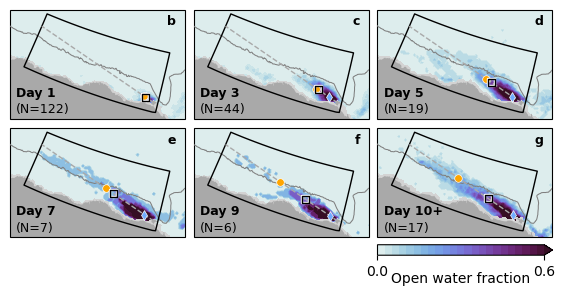

In [790]:
fig, axs = fn.makemap(view='wider_zoom2', contours = [-100], 
                      panels=(2,3), figsize=(7,3.))
plt.subplots_adjust(hspace=0.05, wspace=0.05)


from pyproj import Geod
g = Geod(ellps='WGS84')
# startlon, startlat = -139, 69.5
startlon, startlat = -139.1, 69.6
# dists = np.array([31,64,79, 101,117,134,144,150])+10
# iced = np.array([50.82842169,  68.58080734,  90.47338417,
#         98.24958483, 120.57204264, 128.47181612])
wind = np.array([35.50381821,  75.51196037, 125.48660916, 171.30080786,
       205.45987047, 226.16189264])
latt = np.array([29.89207331, 32.11730528, 33.0155933 , 35.32942831, 28.70799943,
       30.70865801])
obss = np.array([29.38230774,  68.75966641, 106.3567456 , 143.28681747,
       114.46666782, 118.17654774])

# wind = np.array([29.67029984, 81.62365485, 159.8473894, 174.82151541])
# latt = np.array([29.93782605, 33.22366475,  35.32942831, 33.74427032])
# obss = np.array([29.38230774, 76.14685572, 107.23015109, 83.90562419])

# for key, n, N in zip(['Dec', 'Jan', 'Feb', 'Mar',],
#                      [0,2,4,6], [1,3,5,7]):

FS = 9
for key, n in zip([f'd{m}' for m in [1,3,5,7,9]]+[f'd10+'],
                     range(6)):

    axs[n].text(0.95,0.95,f'{chr(97+n+1)}', weight='bold', 
                ha='right', va='top', size=FS, transform=axs[n].transAxes)
    
    ax = axs[n]
    
    ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    ax.text(0.035,0.175,f'Day {key[1:]}', weight='bold', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    ax.text(0.035,0.025,f'(N={len(event_dates[key])})', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#               vmin=0, vmax=0.6, cmap=cmocean.cm.dense, transform=dsic['proj'])
    
    mesh = ax.contourf(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
          vmin=0, vmax=0.6, levels = np.arange(0,0.6,0.025), extend='max', cmap=cmocean.cm.dense, transform=dsic['proj'])
    
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
#               vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=dsic['proj'])
    
#     ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#                   levels=[0.25, 0.5], colors=['gold'], linewidths=[0.5,], transform=dsic['proj'])
    
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
    ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
            c='darkgray', lw=1, zorder=100, ls='dashed')
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, latt[n]*1000)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=25, marker='d', facecolor=[111/255,171/255,255/255], edgecolor='white',lw=0.5, zorder=100)
    
    
#     endlon, endlat, backaz = g.fwd(startlon, startlat, -55, iced[n]*1000)
#     ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
#                s=30, marker='o', facecolor='r', edgecolor='white', lw=0.5, zorder=100)
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, wind[n]*1000)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=30, marker='o', facecolor='orange', edgecolor='white', lw=0.5, zorder=100)
    
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, obss[n]*1000)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=25, marker='s', edgecolor='white', facecolor='None',lw=1.75, 
               zorder=100)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=25, marker='s', edgecolor='k', facecolor='None', lw=1, zorder=100)

#     ax.scatter(startlon, startlat, transform=ccrs.PlateCarree())
    
plotter.add_colorbar(fig, axs[5], [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.035, cb_length_fraction=[0, 1], cb_pad=0.025, cb_ticks=[0,0.6], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Open water fraction', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS+1, draw_edges=False, edge_params=['k', 2])


# fig.savefig('../figures/results/dailyevent_maps.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [19]:

M = {}
for mooring in ['M1', 'M2', 'M3', 'M4']:  
    M[mooring] = {}
    
    open_years = '2017_2018'
    path = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/'
    with xr.open_dataset(path+f"{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc") as ds:
        M[mooring]['lat'] = ds.lat
        M[mooring]['lon'] = ds.lon

        
# # create false M0 mooring along shelf current
# M['M0'] = {}
# shelf_angle = 145
# # shelf_angle = 165
# shelf_az = 90-shelf_angle
# M['M0']['lon'], M['M0']['lat'], backaz = g.fwd(M['M1']['lon'], M['M1']['lat'], shelf_az, 80000)

In [92]:
all_u10 = dfb['u10'][dfb['sequence']!=-999]
all_v10 = dfb['v10'][dfb['sequence']!=-999]

all_ui = dfb['ui'][dfb['sequence']!=-999]
all_vi = dfb['vi'][dfb['sequence']!=-999]

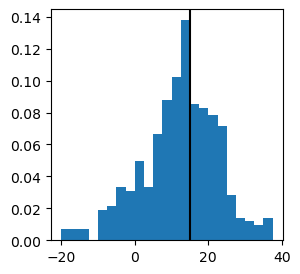

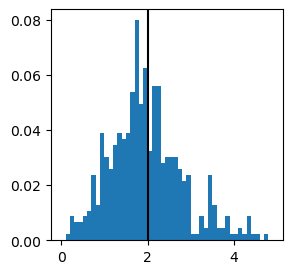

In [93]:

all_ta = np.array([])
all_wf = np.array([])
for U10,V10,UI,VI in zip(all_u10, all_v10, all_ui, all_vi):
    ta = vectors.turning_angle((U10,V10), (UI,VI)).magnitude
    all_ta = np.append(all_ta, ta)
        
    wf = np.sqrt(UI**2+VI**2)/np.sqrt(U10**2+V10**2)
    all_wf = np.append(all_wf, wf)
    
h=plotter.quick_hist(all_ta, bin_edges=np.arange(-20,40,2.5))
fig, ax = plt.subplots(figsize=(3,3))
plt.bar(h['centers'], h['prob'], width=h['w'])
plt.axvline(15, c='k')


h=plotter.quick_hist(all_wf, bin_edges=np.arange(0,5,0.1))
fig, ax = plt.subplots(figsize=(3,3))
plt.bar(h['centers'], h['prob'], width=h['w'])
plt.axvline(2, c='k')

4540    2017-12-03
4541    2017-12-04
4542    2017-12-05
4543    2017-12-06
4544    2017-12-07
4545    2017-12-08
4546    2017-12-09
4547    2017-12-10
4548    2017-12-11
4549    2017-12-12
4550    2017-12-13
4551    2017-12-14
4552    2017-12-15
4553    2017-12-16
4554    2017-12-17
4555    2017-12-18
4556    2017-12-19
4557    2017-12-20
4558    2017-12-21
4559    2017-12-22
4560    2017-12-23
4561    2017-12-24
4562    2017-12-25
4563    2017-12-26
4564    2017-12-27
Name: time, dtype: object
DatetimeIndex(['2017-12-03', '2017-12-04', '2017-12-05', '2017-12-06',
               '2017-12-07', '2017-12-08', '2017-12-09', '2017-12-10',
               '2017-12-11', '2017-12-12', '2017-12-13', '2017-12-14',
               '2017-12-15', '2017-12-16', '2017-12-17', '2017-12-18',
               '2017-12-19', '2017-12-20', '2017-12-21', '2017-12-22',
               '2017-12-23'],
              dtype='datetime64[ns]', freq=None)


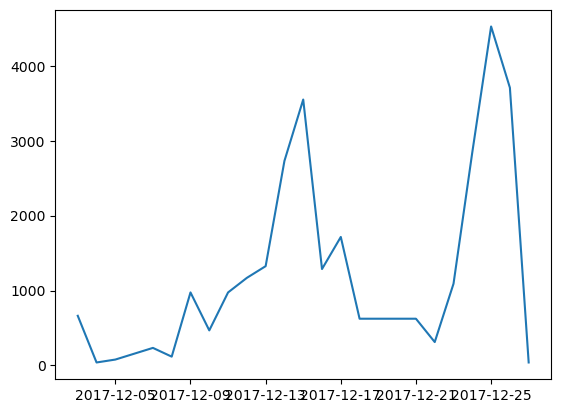

In [134]:
from pyproj import Geod
g = Geod(ellps='WGS84')



# 2024
# SS = 147




# Dec 2017
# SS = 95

#2019
# SS = 106
# SS = 116

# 2025
# SS = 157

# SS = 12

print(df['time'][df['sequence']==SS])

u10_during = df['ui'][df['sequence']==SS]
v10_during = df['vi'][df['sequence']==SS]
time_during = pd.to_datetime(df['time'][df['sequence']==SS].values)
extent_during = df['extent'][df['sequence']==SS]

plt.plot(time_during, extent_during)

print(time_during[:-4])

In [60]:
# average event
u10_during = dfr['u10'][dfr['sequence']==SS]
v10_during = dfr['v10'][dfr['sequence']==SS]
time_during = pd.to_datetime(dfr['time'][dfr['sequence']==SS].values)
extent_during = dfr['extent'][dfr['sequence']==SS]

In [773]:
# open daily drify data
# dl = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/ERA5/hourly_t2m/ERA5_T2m_hourly_2019.nc')
di = xr.open_dataset('/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/icemotion_daily_nh_25km_20170101_20171231_v4.1.nc')
# time_during = dd.time

points = {}

In [200]:
# time_range = slice(datetime(2017, 12, 22), datetime(2017, 12, 25,12))


# time_range = slice(datetime(2017, 12, 19, 12), datetime(2017, 12, 26,12))
# open_years = '2017_2018'

# time_range = slice(datetime(2019, 1, 13, 0), datetime(2019, 1, 18,12))
# open_years = '2018_2019'



time_range = slice(datetime(2024, 1, 2, 0), datetime(2024, 1, 14,12))
open_years = '2023_2024'



# time_range = slice(datetime(2016, 12, 15, 12), datetime(2016, 12, 19,12))
# open_years = '2016_2017'


times = pd.to_datetime(pd.date_range(time_range.start, time_range.stop, freq='1H'))

# open hourly data
# dl = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/ERA5/hourly_t2m/ERA5_T2m_hourly_2017.nc')
dw = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{time_range.stop.year}.nc').sel(time=time_range)
# time_during = dw.time



KeyError: "'time' is not a valid dimension or coordinate"

In [195]:
times

DatetimeIndex(['2024-01-04 00:00:00', '2024-01-04 01:00:00',
               '2024-01-04 02:00:00', '2024-01-04 03:00:00',
               '2024-01-04 04:00:00', '2024-01-04 05:00:00',
               '2024-01-04 06:00:00', '2024-01-04 07:00:00',
               '2024-01-04 08:00:00', '2024-01-04 09:00:00',
               ...
               '2024-01-14 03:00:00', '2024-01-14 04:00:00',
               '2024-01-14 05:00:00', '2024-01-14 06:00:00',
               '2024-01-14 07:00:00', '2024-01-14 08:00:00',
               '2024-01-14 09:00:00', '2024-01-14 10:00:00',
               '2024-01-14 11:00:00', '2024-01-14 12:00:00'],
              dtype='datetime64[ns]', length=253, freq='H')

In [201]:
# ppd = icedrift.open_local_file(times, main_path='/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/', 
#                          filenametype='icemotion_daily_nh_25km_{}0101_{}1231_v4.1.nc', 
#                          crop=[0, None, 0, None], include_units=False)
# ppd['lon'][ppd['lon']>180]-=360

# ppr = xr.open_dataset(f'../data/forcing/regional_daily_ppd_{open_years.split("_")[-1]}_v7.nc')

ppw = xr.open_dataset(f'../data/forcing/regional_daily_era_{open_years.split("_")[-1]}_v7.nc')


In [209]:
icetrack = {}
points = {}

# coords = [(69.9991, -142.2903), (69.9046, -141.7307), (69.7823, -141.3786), 
#           (69.7001, -140.9825), (69.6524, -140.4897), (69.6437, -139.9488),
#           (69.5991, -139.5487), (69.6232, -139.2316), (69.6142, -138.8635),
#           (69.4773, -138.6382), (69.3960, -138.4758), (69.3067, -138.1347), 
#           (69.2568, -137.8408), (69.2197, -137.5207), (69.2626, -137.2099), 
#           (69.3817, -136.9212), (69.4857, -136.6369), (69.5879, -136.2569),
#           (69.6946, -135.8771), (69.7883, -135.5007), (69.8165, -135.0666), 
#           (69.8542, -134.7344), (69.8911, -134.4010), (69.9086, -133.9909), 
#           (69.9057, -133.6826)
#          ]

coords = [(69.6232, -139.2316), 
         ]

initial_lons = np.array([coord[1] for coord in coords])
initial_lats = np.array([coord[0] for coord in coords])

initial_times = np.full(len(coords), time_range.start)


# initial_times = np.concatenate((np.full(5, datetime(2019,1,16)), np.full(len(coords)-5, datetime(2019,1,13,12)) ))
# initial_times = np.concatenate((np.full(5, datetime(2017,12,19)), np.full(len(coords)-5, datetime(2017,12,19)) ))
# initial_times = np.concatenate((np.full(5, datetime(2016,12,15)), np.full(len(coords)-5, datetime(2016,12,15)) ))


counter = 0
for lon, lat in zip(initial_lons, initial_lats):
    
    icetrack[counter] = {}
    icetrack[counter]['lons'] = np.array([lon])
    icetrack[counter]['lats'] = np.array([lat])
    
    icetrack[counter]['e'] = np.array([])
    icetrack[counter]['n'] = np.array([])
    
    
    points[counter] = {}
    points[counter]['lons'] = np.array([lon])
    points[counter]['lats'] = np.array([lat])
    
    points[counter]['u10'] = np.array([])
    points[counter]['v10'] = np.array([])
    
    
    for tt, time in enumerate(times):
        
        if time <= initial_times[counter]:

#             points[counter]['u10'] = np.append(points[counter]['u10'], 0)
#             points[counter]['v10'] = np.append(points[counter]['v10'], 0)
            
#             points[counter]['lons'] = np.append(points[counter]['lons'], points[counter]['lons'][-1])
#             points[counter]['lats'] = np.append(points[counter]['lats'], points[counter]['lats'][-1])
            
            
            icetrack[counter]['e'] = np.append(icetrack[counter]['e'], 0)
            icetrack[counter]['n'] = np.append(icetrack[counter]['n'], 0)
            
            icetrack[counter]['lons'] = np.append(icetrack[counter]['lons'], icetrack[counter]['lons'][-1])
            icetrack[counter]['lats'] = np.append(icetrack[counter]['lats'], icetrack[counter]['lats'][-1])

        else:
#             loc_u = dw.u10.sel(longitude=points[counter]['lons'][-1], 
#                                latitude=points[counter]['lats'][-1], 
#                                time = time_during[tt],
#                                 method="nearest").item() * units('m/s')

#             loc_v = dw.v10.sel(longitude=points[counter]['lons'][-1], 
#                                latitude=points[counter]['lats'][-1], 
#                                time = time_during[tt],
#                                 method="nearest").item() * units('m/s')

#             points[counter]['u10'] = np.append(points[counter]['u10'], loc_u)
#             points[counter]['v10'] = np.append(points[counter]['v10'], loc_v)

#             drift_angle = vectors.vector_angle(loc_u,loc_v) - 35 * units('degree')
#             drift_dist = 0.02 * np.sqrt(loc_u**2+loc_v**2).to('m/hour').magnitude

#             endlon, endlat, backaz = g.fwd(points[counter]['lons'][-1], 
#                                            points[counter]['lats'][-1], 
#                                            90-drift_angle.magnitude, drift_dist)

#             points[counter]['lons'] = np.append(points[counter]['lons'], endlon)
#             points[counter]['lats'] = np.append(points[counter]['lats'], endlat)


#             # find ice drift
            time_no_hour = time - timedelta(hours=time.hour)
#             ti = np.where(pd.to_datetime(ppd['ds'].time.values)==time_no_hour)[0][0]
            
#             cE = ppd['e'][ti,:,:]
#             cN = ppd['n'][ti,:,:]

#             # convert last point to drift projection
#             clon = icetrack[counter]['lons'][-1]
#             clat = icetrack[counter]['lats'][-1]
#             cxx, cyy = ppd['proj'].transform_point(clon, clat, ccrs.PlateCarree())

#             # grab nearest drift values
#             dist = np.sqrt((ppd['xx']-cxx)**2 + (ppd['yy']-cyy)**2)
#             finite = np.isfinite(cE)
#             dist[finite==False] = np.nan

#             E = cE[np.where(dist == np.nanmin(dist))][0]
#             N = cN[np.where(dist == np.nanmin(dist))][0]


#             E = ppr.sel(time = time_no_hour).e.values.item()*units('cm/s').to('m/hour').magnitude
#             N = ppr.sel(time = time_no_hour).n.values.item()*units('cm/s').to('m/hour').magnitude

            E = 0.025 * ppw.sel(time = time_no_hour).u10.values.item()*units('m/s').to('m/hour').magnitude 
            N = 0.025 * ppw.sel(time = time_no_hour).v10.values.item()*units('m/s').to('m/hour').magnitude 


            icetrack[counter]['e'] = np.append(icetrack[counter]['e'], E)
            icetrack[counter]['n'] = np.append(icetrack[counter]['n'], N)


            drift_angle = vectors.vector_angle(E,N) - 20 * units('degree')
            drift_dist = np.sqrt(E**2+N**2)

            endlon, endlat, backaz = g.fwd(icetrack[counter]['lons'][-1], 
                                           icetrack[counter]['lats'][-1], 
                                           90-drift_angle.magnitude, drift_dist)

            icetrack[counter]['lons'] = np.append(icetrack[counter]['lons'], endlon)
            icetrack[counter]['lats'] = np.append(icetrack[counter]['lats'], endlat)
        
    counter+=1

In [169]:
dsc = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_{open_years}.nc')
dsc.close()
dsc = dsc.sel(time=time_range)

m1_lons = np.array([-139.2582])
m1_lats = np.array([69.7718])

flow_angle = vectors.vector_angle(dsc.u.mean('depth').values,dsc.v.mean('depth').values)
flow_dist = np.sqrt(dsc.u.mean('depth')**2+dsc.v.mean('depth')**2).values * units('m/s').to('m/hour').magnitude

for ff in range(len(flow_angle)):
    endlon, endlat, backaz = g.fwd(m1_lons[-1], 
                                   m1_lats[-1], 
                                   90-flow_angle.magnitude[ff], flow_dist[ff])
    
    m1_lons = np.append(m1_lons, endlon)
    m1_lats = np.append(m1_lats, endlat)

In [214]:

# final flow rate to m/day
U = dsc.sel(time=time_range.stop - timedelta(hours=12)).u.mean('depth').values.item()
V = dsc.sel(time=time_range.stop - timedelta(hours=12)).v.mean('depth').values.item()
flow_angle = vectors.vector_angle(U,V)
flow_dist = np.sqrt(U**2+V**2) * units('m/s').to('m/day').magnitude

endlon, endlat, backaz = g.fwd(m1_lons[0], 
                               m1_lats[0], 
                               90-flow_angle.magnitude, flow_dist)


KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

In [207]:

# date = datetime(2017,12,27)
date = time_range.stop

RES = '3125'
crop=[1500, 2050, 480, 700]

sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, 
                            include_units=False, quiet=True)


In [244]:
dir_bins = np.array([115., 120., 125., 130., 135., 140., 145., 150., 155., 160., 165.,
       170.])

lens_95 = np.array([ 38.25523663,  55.51080706,  71.71114602, 119.51984847,
       141.88020872, 144.86527646, 203.61409144, 363.14614689,
       284.88229401, 111.02230219,  72.498526  ,  55.10222014])

lens_75 = np.array([ 38.25523663,  40.68988689,  63.12707851,  75.11826304,
        95.33143706,  78.48626059, 122.05656563, 150.79228158,
       128.8387282 ,  60.82560104,  58.66907933,  44.93006196])

edge_lons_95 = np.array([])
edge_lats_95 = np.array([])

edge_lons_75 = np.array([])
edge_lats_75 = np.array([])

for direction, length95, length75 in zip(dir_bins, lens_95, lens_75):

    shelf_endlon, shelf_endlat, backaz = g.fwd(-139.1, 69.6, 
                                   90-direction, length95*1000)
    
    edge_lons_95 = np.append(edge_lons_95, shelf_endlon)
    edge_lats_95 = np.append(edge_lats_95, shelf_endlat)
    
    
    shelf_endlon, shelf_endlat, backaz = g.fwd(-139.1, 69.6, 
                                   90-direction, length75*1000)
    
    edge_lons_75 = np.append(edge_lons_75, shelf_endlon)
    edge_lats_75 = np.append(edge_lats_75, shelf_endlat)

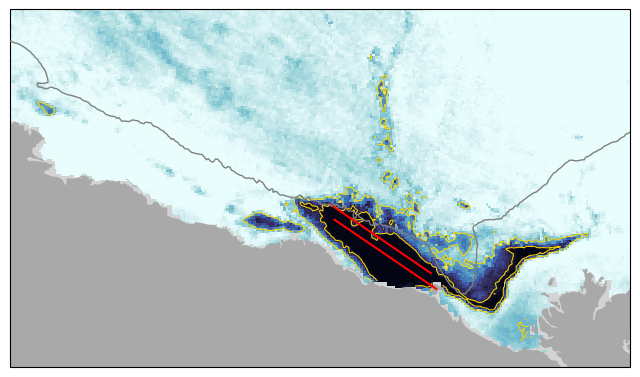

In [415]:
RES = '3125'
crop=[1500, 2050, 480, 700]

sic = unisic.open_local_file(datetime(2025,3,10), res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, 
                            include_units=False, quiet=True)
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))

    
ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)

ax.plot([m1_loc[0],m1_endlon], [m1_loc[1], m1_endlat], transform=ccrs.PlateCarree(), c='r')
ax.plot([HI_loc[0],HI_endlon], [HI_loc[1], HI_endlat], transform=ccrs.PlateCarree(), c='r')


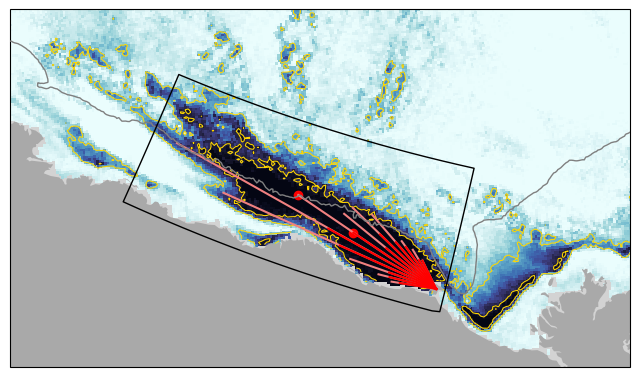

In [246]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))

    
ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)


# for key in icetrack.keys():
#     ax.plot(points[key]['lons'], 
#                points[key]['lats'], transform=ccrs.PlateCarree(), c='b')
    
#     ax.scatter(points[key]['lons'][-1], 
#                points[key]['lats'][-1], transform=ccrs.PlateCarree(), c='b')
#     ax.plot(icetrack[key]['lons'], 
#                icetrack[key]['lats'], transform=ccrs.PlateCarree(), c='r')
    
    
# # ax.plot(m1_lons, m1_lats, transform=ccrs.PlateCarree(), c='orange')

# ax.plot([m1_lons[0], endlon], 
#         [m1_lats[0], endlat], transform=ccrs.PlateCarree(), c='gold')

ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())

# ax.plot([-139.1,shelf_endlon], [69.6, shelf_endlat], transform=ccrs.PlateCarree())

for ee_lon, ee_lat in zip(edge_lons_95, edge_lats_95):
    ax.plot([-139.1,ee_lon], [69.6, ee_lat], c='lightcoral', transform=ccrs.PlateCarree())
    
for ee_lon, ee_lat in zip(edge_lons_75, edge_lats_75):
    ax.plot([-139.1,ee_lon], [69.6, ee_lat], c='red', transform=ccrs.PlateCarree())
    
    
ax.scatter([edge_lons_75[np.where(dir_bins == 145)], 
            edge_lons_95[np.where(dir_bins == 145)]], 
           [edge_lats_75[np.where(dir_bins == 145)], 
            edge_lats_95[np.where(dir_bins == 145)]], c='red', transform=ccrs.PlateCarree())

In [399]:
RES = '6250'
crop=[700, 1150, 200, 400]
sic_key = 'sic'
open_thresh = 10

RES = '3125'
crop=[1500, 2050, 480, 700]
sic_key = 'sic'

# RES = '1000ma2'
# crop=[2100, 3400, 340, 800]
# sic_key = 'sic_merged'


sic = unisic.open_local_file(datetime(2019,1,16), res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, include_units=False, quiet=True)


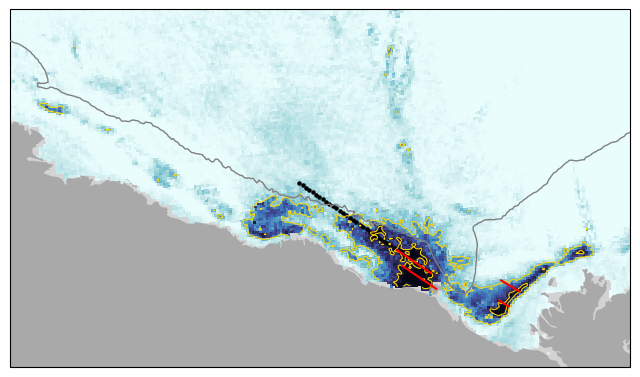

In [404]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))
ax.patch.set_facecolor('lightgray')
    
ax.pcolormesh(sic['xx'], sic['yy'], sic[sic_key], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic[sic_key], levels=[10,70], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)

ax.plot([m1_loc[0],m1_endlon], [m1_loc[1], m1_endlat], transform=ccrs.PlateCarree(), c='r')
ax.plot([HI_loc[0],HI_endlon], [HI_loc[1], HI_endlat], transform=ccrs.PlateCarree(), c='r')


# ax.scatter(track_lons, track_lats, s=5, c='r', transform=ccrs.PlateCarree())


ax.scatter(lon_track, lat_track, s=5, c='k', transform=ccrs.PlateCarree())

other_loc = (-136.8709, 69.3813)
oth_endlon, oth_endlat, backaz = g.fwd(*other_loc, 90-145, 13*1000)
ax.plot([other_loc[0], oth_endlon], [other_loc[1], oth_endlat], c='r', transform=ccrs.PlateCarree())

other_loc = (-136.5081, 69.5365)
oth_endlon, oth_endlat, backaz = g.fwd(*other_loc, 90-145,26*1000)
ax.plot([other_loc[0], oth_endlon], [other_loc[1], oth_endlat], c='r', transform=ccrs.PlateCarree())

In [349]:
az12,az21,dist = g.inv(m1_lons[0],m1_lats[0],m1_endlon,m1_endlat)
# find ten equally spaced points between m1 and final point.
npts = 39
del_s = dist/(npts+1)
print(del_s)
lon_track = np.array([m1_lons[0]])
lat_track = np.array([m1_lats[0]])
r = g.fwd_intermediate(m1_lons[0],m1_lats[0],90-145,npts=npts,del_s=del_s)
for lon,lat in zip(r.lons, r.lats):
    lon_track = np.append(lon_track, lon)
    lat_track = np.append(lat_track, lat)

4999.999999999996


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pyproj/geod.py:829: UserWarning: Back azimuth is being returned by default to be compatible with inv()This is a breaking change for pyproj 3.5+.To avoid this warning, set return_back_azimuth=True.Otherwise, to restore old behaviour, set return_back_azimuth=False.This warning will be removed in future version.
  warnings.warn(


In [411]:
m1_loc = (m1_lons[0], m1_lats[0])
HI_loc = (-139.1, 69.6)

m1_endlon, m1_endlat, backaz = g.fwd(*m1_loc, 90-145, 150*1000)
HI_endlon, HI_endlat, backaz = g.fwd(*HI_loc, 90-145, 150*1000)

In [294]:
stepsize = 5
N = 40

In [295]:
track_lons = np.array([m1_loc[0]])
track_lats = np.array([m1_loc[1]])

for n in range(N):
    last_loc = (track_lons[-1], track_lats[-1])
    out = g.fwd(*last_loc, 90-145, stepsize*1000)
    track_lons = np.append(track_lons, out[0])
    track_lats = np.append(track_lats, out[1])

In [296]:
lens_95[np.where(dir_bins == 145)]

array([203.61409144])

In [243]:
edge_lons_75

[-139.52156819709256,
 -139.63062343033903,
 -140.05100095923186,
 -140.3713102543238,
 -140.88218604427558,
 -140.67806279245497,
 -141.74544489486917,
 -142.56183124491835,
 -142.1681577913888,
 -140.58135282853095,
 -140.56523377189288,
 -140.24056570161247]

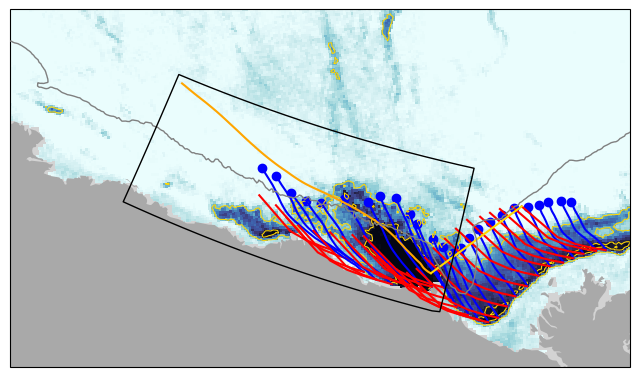

In [177]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))

    
ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)


for key in icetrack.keys():
    ax.plot(points[key]['lons'], 
               points[key]['lats'], transform=ccrs.PlateCarree(), c='b')
    
    ax.scatter(points[key]['lons'][-1], 
               points[key]['lats'][-1], transform=ccrs.PlateCarree(), c='b')
    ax.plot(icetrack[key]['lons'], 
               icetrack[key]['lats'], transform=ccrs.PlateCarree(), c='r')
    
    
ax.plot(m1_lons, m1_lats, transform=ccrs.PlateCarree(), c='orange')

ax.plot([m1_lons[0], endlon], 
        [m1_lats[0], endlat], transform=ccrs.PlateCarree(), c='gold')

ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


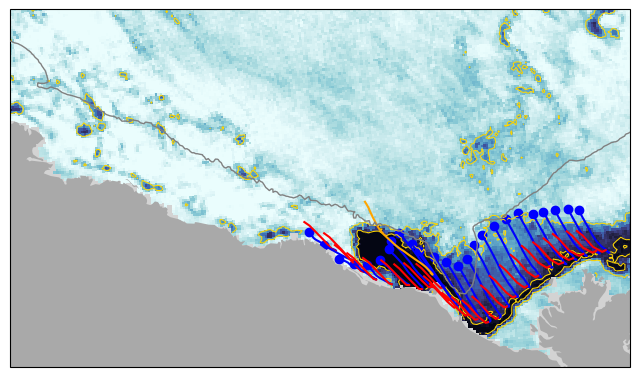

In [66]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))

    
ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)


for key in icetrack.keys():
    ax.plot(points[key]['lons'], 
               points[key]['lats'], transform=ccrs.PlateCarree(), c='b')
    
    ax.scatter(points[key]['lons'][-1], 
               points[key]['lats'][-1], transform=ccrs.PlateCarree(), c='b')
    ax.plot(icetrack[key]['lons'], 
               icetrack[key]['lats'], transform=ccrs.PlateCarree(), c='r')
    
    
ax.plot(m1_lons, m1_lats, transform=ccrs.PlateCarree(), c='orange')


In [ ]:

year = 2024
ds = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.1.nc')

ds.max_length.plot(marker='.')
# ds.max_length_direction.plot()
ds.l_max.plot(marker='.')

In [ ]:
# time_cond = (pd.to_datetime(df.time.values)>=datetime(2023,12,1)) & (pd.to_datetime(df.time.values)<=datetime(2024,4,30))
# time_cond

time_cond = (pd.to_datetime(df.time.values)>=datetime(year-1,12,1)) & (pd.to_datetime(df.time.values)<=datetime(year,4,30))
time_cond

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(ds.l_max * ds.w_max-ds.w_min, ds.extent)

plt.xlim(-500,5000)
plt.ylim(-500,5000)

In [1281]:
wa = vectors.vector_angle(df[time_cond].u10.values, df[time_cond].v10.values).magnitude
wa[wa<0]+=360

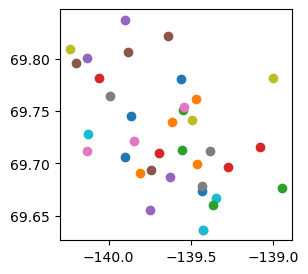

In [1282]:
poly_angles = []
fig, ax = plt.subplots(figsize=(3,3))

for time in ds.time[ds.max_length.values>0].values:
    
    all_xx = ds.poly_interior_xx.sel(time=time).values.item()
    all_yy = ds.poly_interior_yy.sel(time=time).values.item()
    
    xs = np.array(all_xx.split('_')[1:]).astype(float)
    ys = np.array(all_yy.split('_')[1:]).astype(float)
    
    lon, lat = ccrs.PlateCarree().transform_point(np.nanmean(xs), np.nanmean(ys), sic['proj'])
    az, _, dist = g.inv(-139.1, 69.6, lon, lat)
    poly_angles.append(90-az)
    ax.scatter(lon, lat)

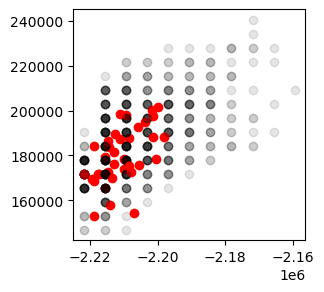

In [1283]:
fig, ax = plt.subplots(figsize=(3,3))
for time in ds.time[ds.max_length.values>0].values:
    
    all_xx = ds.poly_interior_xx.sel(time=time).values.item()
    all_yy = ds.poly_interior_yy.sel(time=time).values.item()
    
    xs = np.array(all_xx.split('_')[1:]).astype(float)
    ys = np.array(all_yy.split('_')[1:]).astype(float)
    
    plt.scatter(xs, ys, c='k', alpha=0.1)
    ax.scatter(np.nanmean(xs), np.nanmean(ys), c='r')

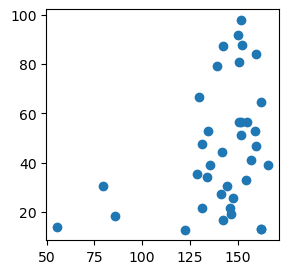

In [1284]:
fig, ax = plt.subplots(figsize=(3,3))
# plt.scatter(ds.max_length_direction.values[ds.max_length.values>0], poly_angles)

# plt.scatter(ds.max_length_direction.values[ds.max_length.values>0], ds.max_length.values[ds.max_length.values>0])
plt.scatter(poly_angles, ds.max_length.values[ds.max_length.values>0])
# plt.scatter(wa[ds.max_length.values>0], poly_angles)

# plt.xlim(80,200)
# plt.ylim(80,200)

# plt.plot([0,360], [0,360])

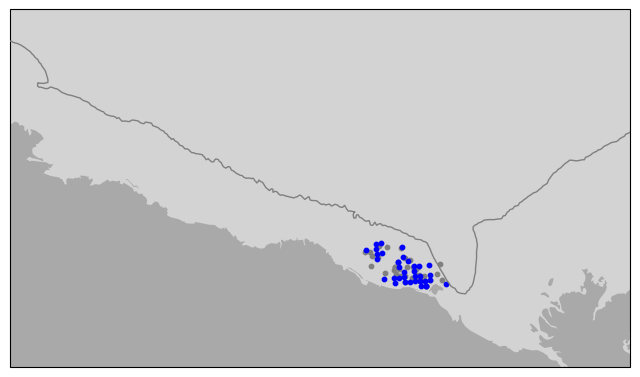

In [1285]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))

for angle, length in zip(poly_angles, ds.max_length.values[ds.max_length.values>0]):
    lon, lat, _ = g.fwd(-139.1, 69.6, 90-angle, length*1000)
    ax.scatter(lon, lat, transform=ccrs.PlateCarree(), c='gray', s=10)
    
for angle, length in zip(ds.max_length_direction.values[ds.max_length.values>0], 
                         ds.max_length.values[ds.max_length.values>0]):
    lon, lat, _ = g.fwd(-139.1, 69.6, 90-angle, length*1000)
    ax.scatter(lon, lat, transform=ccrs.PlateCarree(), c='b', s=10)
    
# ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

# ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
#            transform=sic['proj'], colors=['gold'], linewidths=0.75)


In [775]:
time_range = slice(datetime(2017, 12, 22), datetime(2017, 12, 27,12))

# time_range = slice(datetime(2019,1,14,0), datetime(2019,1,21))

# open hourly data
# dl = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/ERA5/hourly_t2m/ERA5_T2m_hourly_2017.nc')
dw = xr.open_dataset('/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2017.nc').sel(time=time_range)
time_during = dw.time

points = {}


points['HI'] = {}
points['HI']['itime'] = time_during[0]
points['HI']['ilat'] =   69.64
points['HI']['ilon'] =   -139.25




points['t1'] = {}
points['t1']['itime'] = time_during[0]
points['t1']['ilat'] =   69.4031
points['t1']['ilon'] =   -136.8446

points['t2'] = {}
points['t2']['itime'] = time_during[0]
points['t2']['ilat'] =   69.5569
points['t2']['ilon'] =   -136.4344


points['t3'] = {}
points['t3']['itime'] = time_during[0]
points['t3']['ilat'] =   69.8133
points['t3']['ilon'] =   -135.4092



points['t4'] = {}
points['t4']['itime'] = time_during[0]
points['t4']['ilat'] =  69.8790
points['t4']['ilon'] =  -133.2463


points['t5'] = {}
points['t5']['itime'] = time_during[0]
points['t5']['ilat'] =  69.4971
points['t5']['ilon'] =  -138.6215

points['t6'] = {}
points['t6']['itime'] = time_during[0]
points['t6']['ilat'] =  69.2833
points['t6']['ilon'] = -137.9395

points['t7'] = {}
points['t7']['itime'] = time_during[0]
points['t7']['ilat'] =  69.2917
points['t7']['ilon'] = -137.0471

points['t8'] = {}
points['t8']['itime'] = time_during[0]
points['t8']['ilat'] =  69.7003
points['t8']['ilon'] = -135.8720



points['t9'] = {}
points['t9']['itime'] = time_during[0]
points['t9']['ilat'] =  69.8940
points['t9']['ilon'] = -134.2445

points['t10'] = {}
points['t10']['itime'] = time_during[0]
points['t10']['ilat'] =  69.6258
points['t10']['ilon'] = -139.7044

points['t11'] = {}
points['t11']['itime'] = time_during[0]
points['t11']['ilat'] =  69.8230
points['t11']['ilon'] = -141.5017


points['t12'] = {}
points['t12']['itime'] = time_during[0]
points['t12']['ilat'] =  69.6970
points['t12']['ilon'] = -140.7146

points['t13'] = {}
points['t13']['itime'] = time_during[0]
points['t13']['ilat'] =  69.115
points['t13']['ilon'] = -137.4817





# points['t4'] = {}
# points['t4']['itime'] = time_during[0]
# points['t4']['ilat'] =   69.6295
# points['t4']['ilon'] =  -140.0593


for key in points.keys():

    points[key]['event_lons'] = np.array([points[key]['ilon']])
    points[key]['event_lats'] = np.array([points[key]['ilat']])
    
    points[key]['u10'] = np.array([])
    points[key]['v10'] = np.array([])
    
    
    points[key]['event_lons_d'] = np.array([points[key]['ilon']])
    points[key]['event_lats_d'] = np.array([points[key]['ilat']])
    
#     points[key]['t2m'] = np.array([])

In [776]:


for tt, time in enumerate(time_during):
    
    for key in points.keys():
    
#         loc_t2m = dl.t2m.sel(longitude=points[key]['event_lons'][tt], 
#                              latitude=points[key]['event_lats'][tt], 
#                              valid_time = time_during[tt],
#                              method="nearest").item() - 273.15

        loc_u = dw.u10.sel(longitude=points[key]['event_lons'][tt], 
                           latitude=points[key]['event_lats'][tt], 
                           time = time_during[tt],
                            method="nearest").item() * units('m/s')

        loc_v = dw.v10.sel(longitude=points[key]['event_lons'][tt], 
                           latitude=points[key]['event_lats'][tt], 
                           time = time_during[tt],
                            method="nearest").item() * units('m/s')
        
#         points[key]['t2m'] = np.append(points[key]['t2m'], loc_t2m)
        points[key]['u10'] = np.append(points[key]['u10'], loc_u)
        points[key]['v10'] = np.append(points[key]['v10'], loc_v)


        drift_angle = vectors.vector_angle(loc_u,loc_v) - 20 * units('degree')
        drift_dist = 0.02 * np.sqrt(loc_u**2+loc_v**2).to('m/hour').magnitude

    #     event_a = np.append(event_a, drift_angle.magnitude)
    #     event_d = np.append(event_d, drift_dist)

        endlon, endlat, backaz = g.fwd(points[key]['event_lons'][-1], 
                                       points[key]['event_lats'][-1], 
                                       90-drift_angle.magnitude, drift_dist)

        points[key]['event_lons'] = np.append(points[key]['event_lons'], endlon)
        points[key]['event_lats'] = np.append(points[key]['event_lats'], endlat)
        
        
        
        # ice velocity data
        time_stip_hour = pd.to_datetime(time.values) - timedelta(hours=pd.to_datetime(time.values).hour)
        time_ind = np.where(pd.to_datetime(df['time'].values) == time_stip_hour)[0][0]

        UI = df['ui'][time_ind] * units('cm/s').to('m/hour')
        VI = df['vi'][time_ind] * units('cm/s').to('m/hour')

        drift_angle = vectors.vector_angle(UI,VI) - 20 * units('degree')
        drift_dist = np.sqrt(UI**2+VI**2).to('m/hour').magnitude

        endlon, endlat, backaz = g.fwd(points[key]['event_lons_d'][-1], 
                                       points[key]['event_lats_d'][-1], 
                                       90-drift_angle.magnitude, drift_dist)
        
        points[key]['event_lons_d'] = np.append(points[key]['event_lons_d'], endlon)
        points[key]['event_lats_d'] = np.append(points[key]['event_lats_d'], endlat)
        
        
        
        df['time']

In [782]:

RES = '6250'
crop=[700, 1150, 200, 400]
# sic_key = 'sic'


RES = '3125'
crop=[1500, 2050, 480, 700]
# sic_key = 'sic'

# datetime(2025,3,11)


# date = datetime(2019,1,18,)

# date = datetime(2025,3,12)

date = datetime(2017,12,26)

sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, 
                            include_units=False, quiet=True)

tf = np.where(pd.to_datetime(time_during) == date)[0][0]

In [779]:
# sorted 
start_lons = np.array([points[key]['event_lons_d'][0] for key in points.keys()])
start_lats = np.array([points[key]['event_lats_d'][0] for key in points.keys()])

final_lons = np.array([points[key]['event_lons_d'][tf+12] for key in points.keys()])
final_lats = np.array([points[key]['event_lats_d'][tf+12] for key in points.keys()])

# sorted 
final_lats = final_lats[np.argsort(start_lons)]
final_lons = final_lons[np.argsort(start_lons)]

start_lats = start_lats[np.argsort(start_lons)]
start_lons = start_lons[np.argsort(start_lons)]

In [707]:
dsc = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_2018_2019.nc')
dsc.close()
dsc = dsc.sel(time=time_range)

In [753]:
dsc = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_2018_2019.nc')
dsc.close()
dsc = dsc.sel(time=time_range)

m1_lons = np.array([-139.2582])
m1_lats = np.array([69.7718])


flow_angle = vectors.vector_angle(dsc.u.mean('depth').values,dsc.v.mean('depth').values) #- 20 * units('degree')
flow_dist = np.sqrt(dsc.u.mean('depth')**2+dsc.v.mean('depth')**2).values * units('m/s').to('m/hour').magnitude

#     event_a = np.append(event_a, drift_angle.magnitude)
#     event_d = np.append(event_d, drift_dist)

for ff in range(len(flow_angle)):
    endlon, endlat, backaz = g.fwd(m1_lons[-1], 
                                   m1_lats[-1], 
                                   90-flow_angle.magnitude[ff], flow_dist[ff])
    
    m1_lons = np.append(m1_lons, endlon)
    m1_lats = np.append(m1_lats, endlat)

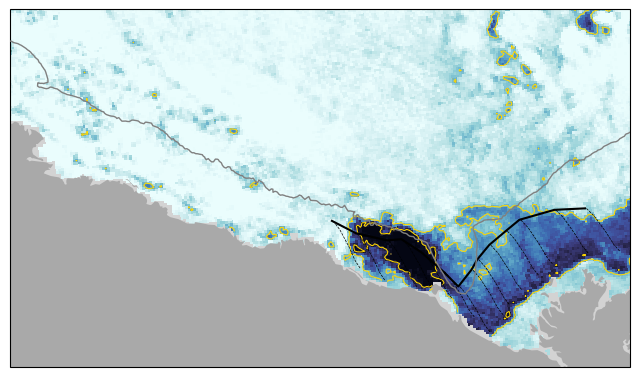

In [783]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))



ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)


# iter_dates = pd.date_range(datetime(2019,1,14), datetime(2019,1,18))
# iter_colors = ['b', 'dodgerblue', 'lightcoral', 'r', 'gold']


# for date, color in zip(iter_dates, iter_colors):

#     sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                                 crop=crop, coordinates=False, area=False, 
#                                 include_units=False, quiet=True)
    
# #     ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
# #            transform=sic['proj'], colors=['r', 'b'], linewidths=0.75)

#     ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10], 
#            transform=sic['proj'], colors=[color], linewidths=0.75)



for key in points.keys():
    ax.plot(points[key]['event_lons_d'][:tf+12], 
            points[key]['event_lats_d'][:tf+12], transform=ccrs.PlateCarree(), c='k', lw=0.5, ls='dashed')

# #     ax.scatter(points[key]['event_lons'][0], 
# #                 points[key]['event_lats'][0], transform=ccrs.PlateCarree(), c='r')
    
# #     ax.scatter(points[key]['event_lons'][tf+12], 
# #                 points[key]['event_lats'][tf+12], transform=ccrs.PlateCarree(), c='r')
    
    
# #     ax.scatter(points[key]['event_lons'][::24], 
# #             points[key]['event_lats'][::24], transform=ccrs.PlateCarree(), c='r')


# ax.scatter(m1_lons[::24], m1_lats[::24], transform=ccrs.PlateCarree(), c='b')


ax.plot(final_lons, final_lats, transform=ccrs.PlateCarree(), c='k')
# ax.plot(start_lons, start_lats, transform=ccrs.PlateCarree(), c='r')


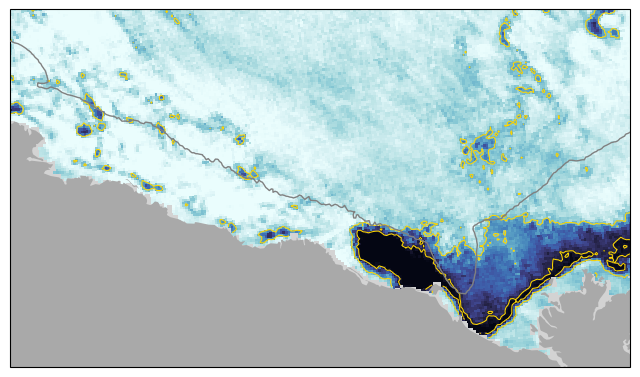

In [784]:
# date = datetime(2019,1,18,)

# date = datetime(2024,1, 14,)

# date = datetime(2025,3,12)

date = datetime(2017,12,25)

sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, 
                            include_units=False, quiet=True)


fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))
ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,70], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)

In [619]:
# time_range = slice(datetime(2018, 1, 1), datetime(2018, 1, 31,23))

time_range = slice(datetime(2017, 1, 1), datetime(2017, 1, 31,23))

# open hourly data
# dl = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/ERA5/hourly_t2m/ERA5_T2m_hourly_2017.nc')
dw = xr.open_dataset('/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2017.nc').sel(time=time_range)


In [494]:
# time_range = slice(datetime(2017,12,22,18), datetime(2017, 12, 26,20))

# time_range = slice(datetime(2017,12,22,18), datetime(2017, 12, 26,20))

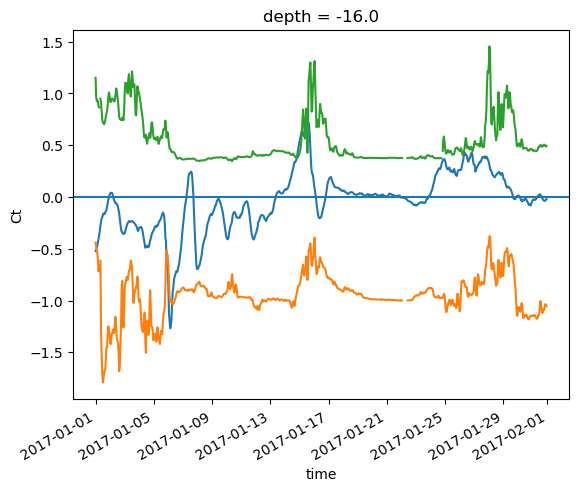

In [629]:
ds1 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_2016_2017.nc')
ds1 = ds1.sel(time = time_range)
ds1['ese'] = vectors.comp_along_theta(ds1.u, ds1.v, 145*units('degree'))

ds1o = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_2016_2017.nc')
ds1o = ds1o.sel(time = time_range)


(ds1.ese.mean('depth')).plot()
# ((ds1o.sig0.mean('depth')-26)/2).plot()
((ds1o.sig0.sel(depth=-16)-26)/2).plot()
# ((ds1o.Ct.mean('depth'))+2).plot()
((ds1o.Ct.sel(depth=-16))+2).plot()

plt.axhline(0)

In [631]:
tracks = {}

use_m = ['M1', 'M2', 'M3', 'M4']

for M in use_m:
    
    tracks[M] = {}
    
    ds1 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{M}/{M}_hourly_seaice_velocity_2016_2017.nc')
    ds1 = ds1.sel(time=time_range)
    ds1['ese'] = vectors.comp_along_theta(ds1.u, ds1.v, 145*units('degree'))
    tracks[M]['ds'] = ds1
    
    
    tracks[M]['lons'] = np.array([tracks[M]['ds'].attrs['lon']])
    tracks[M]['lats'] = np.array([tracks[M]['ds'].attrs['lat']])
    
    if M == 'M2':
        tracks[M]['lons'] = np.array([-136.7702])
        tracks[M]['lats'] = np.array([69.3152])
        
    if M == 'M3':
        tracks[M]['lons'] = np.array([-136.4361])
        tracks[M]['lats'] = np.array([69.4670])
        
    if M == 'M4':
        tracks[M]['lons'] = np.array([-135.6528])
        tracks[M]['lats'] = np.array([69.6423])
        
    
    all_u = tracks[M]['ds'].sel(depth=0).u.values
    all_v = tracks[M]['ds'].sel(depth=0).v.values
    times = pd.to_datetime(tracks[M]['ds'].time.values)

    # interpolate over missing data
    interp_u, _ = tseries.linear_interpolate(times, times, all_u, max_dt=6*units('hour'))
    interp_v, _ = tseries.linear_interpolate(times, times, all_v, max_dt=6*units('hour'))

    tracks[M]['u'] = interp_u
    tracks[M]['v'] = interp_v
    

    for tt, time in enumerate(times):
#         curr_ds = tracks[M]['ds'].sel(time=time, depth=0)
        drift_angle = vectors.vector_angle(interp_u[tt],interp_v[tt]) #- 20 * units('degree')
        drift_dist = np.sqrt(interp_u[tt]**2+interp_v[tt]**2)*units('m/s').to('m/hour').magnitude

        endlon, endlat, backaz = g.fwd(tracks[M]['lons'][-1], 
                                       tracks[M]['lats'][-1], 
                                       90-drift_angle.magnitude, drift_dist)

        tracks[M]['lons'] = np.append(tracks[M]['lons'], endlon)
        tracks[M]['lats'] = np.append(tracks[M]['lats'], endlat)

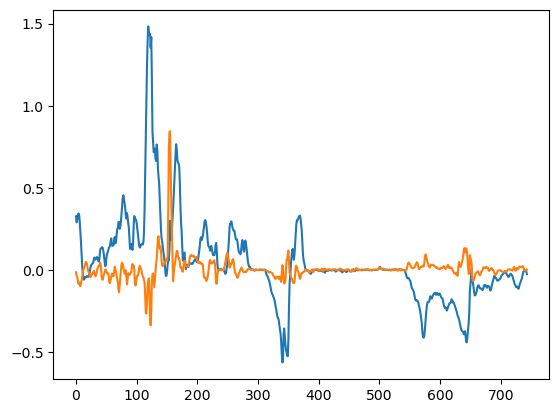

In [643]:
all_u = np.concatenate((tracks['M2']['u'], tracks['M3']['u'], tracks['M4']['u']))
all_v = np.concatenate((tracks['M2']['v'], tracks['M3']['v'], tracks['M4']['v']))

u_grid = np.reshape(all_u, (3,len(tracks['M2']['u'])))
v_grid = np.reshape(all_v, (3,len(tracks['M2']['v'])))

# regional_u = np.nanmean(u_grid, axis=0)
# regional_v = np.nanmean(v_grid, axis=0)

regional_u = u_grid[0,:]
regional_v = v_grid[0,:]

plt.plot(regional_u)
plt.plot(regional_v)


In [644]:
tracks2 = {}

initial_lons = np.array([-136.4080, -135.8647, -135.289])
initial_lats = np.array([69.4635, 69.5732, 69.7071])

counter = 0
for lon, lat in zip(initial_lons, initial_lats):
    
    tracks2[counter] = {}
    tracks2[counter]['lons'] = np.array([lon])
    tracks2[counter]['lats'] = np.array([lat])
    
    for tt, time in enumerate(times):
        drift_angle = vectors.vector_angle(regional_u[tt],regional_v[tt])
        drift_dist = np.sqrt(regional_u[tt]**2+regional_v[tt]**2)*units('m/s').to('m/hour').magnitude

        endlon, endlat, backaz = g.fwd(tracks2[counter]['lons'][-1], 
                                       tracks2[counter]['lats'][-1], 
                                       90-drift_angle.magnitude, drift_dist)
        
        tracks2[counter]['lons'] = np.append(tracks2[counter]['lons'], endlon)
        tracks2[counter]['lats'] = np.append(tracks2[counter]['lats'], endlat)
        
    counter+=1

In [645]:
dw_event = dw.sel(longitude=-138.75, latitude=69.75, time = time_range)

In [646]:
wind_speed = np.sqrt(dw_event.u10.values**2+dw_event.v10.values**2)
ice_speed = np.sqrt(regional_u**2+regional_v**2)

In [647]:
v1=(dw_event.u10.values, dw_event.v10.values) 
v2=(regional_u,regional_v)
ta = vectors.turning_angle(v1, v2)


wf = (ice_speed/wind_speed)[wind_speed>3]

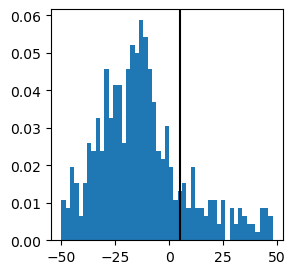

In [648]:
h = plotter.quick_hist(ta.magnitude, bin_edges=np.arange(-50,50,2))

fig, ax = plt.subplots(figsize=(3,3))
plt.bar(h['centers'], h['prob'], width=h['w'])
plt.axvline(5, c='k')

<BarContainer object of 39 artists>

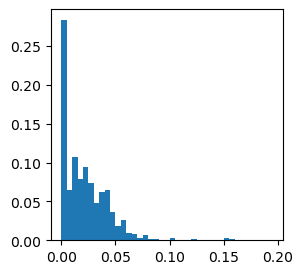

In [649]:
h = plotter.quick_hist(wf, bin_edges=np.arange(0,0.2,0.005))

fig, ax = plt.subplots(figsize=(3,3))
plt.bar(h['centers'], h['prob'], width=h['w'])
# plt.axvline(5, c='k')

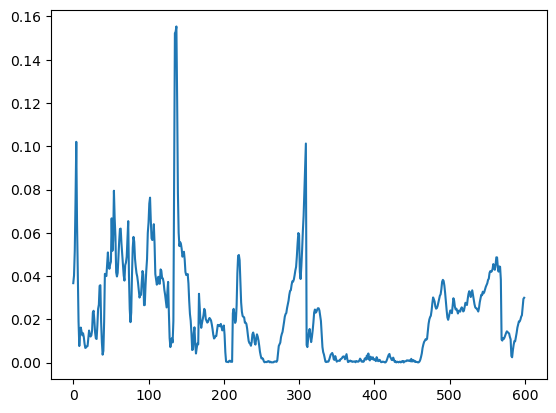

In [650]:
plt.plot(wf)

In [484]:
date = datetime(2017,12,26)

sic = unisic.open_local_file(date, res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                            crop=crop, coordinates=False, area=False, 
                            include_units=False, quiet=True)

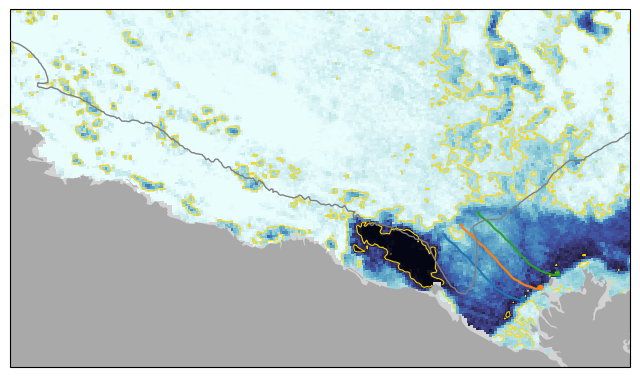

In [487]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))



ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)

ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10,90], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)




# for M in use_m:
#     ax.plot(tracks[M]['lons'], tracks[M]['lats'], transform=ccrs.PlateCarree())
#     ax.scatter(tracks[M]['lons'][0], tracks[M]['lats'][0], s=10, transform=ccrs.PlateCarree())


for c in tracks2.keys():
    ax.plot(tracks2[c]['lons'], tracks2[c]['lats'], transform=ccrs.PlateCarree())
    ax.scatter(tracks2[c]['lons'][0], tracks2[c]['lats'][0], s=10, transform=ccrs.PlateCarree())

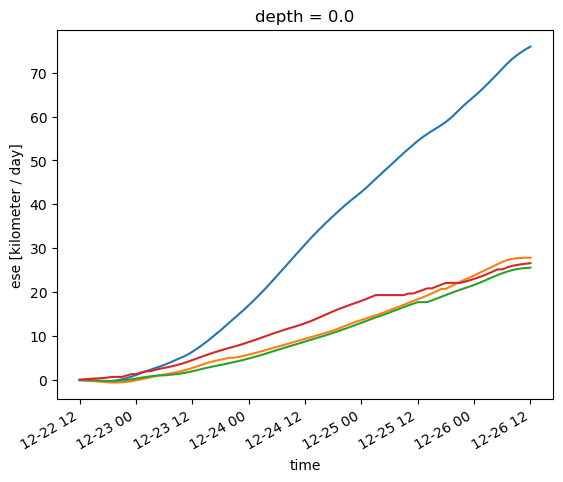

In [332]:
ds1 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_seaice_velocity_2017_2018.nc')
ds1 = ds1.sel(time=time_range)
ds1['ese'] = vectors.comp_along_theta(ds1.u, ds1.v, 145*units('degree'))

ds2 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_seaice_velocity_2017_2018.nc')
ds2 = ds2.sel(time=time_range)
ds2['ese'] = vectors.comp_along_theta(ds2.u, ds2.v, 145*units('degree'))

ds3 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_seaice_velocity_2017_2018.nc')
ds3 = ds3.sel(time=time_range)
ds3['ese'] = vectors.comp_along_theta(ds3.u, ds3.v, 145*units('degree'))

ds4 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_seaice_velocity_2017_2018.nc')
ds4 = ds4.sel(time=time_range)
ds4['ese'] = vectors.comp_along_theta(ds4.u, ds4.v, 145*units('degree'))


np.cumsum(ds1.ese*units('cm/s').to('km/day')).plot()
np.cumsum(ds2.ese*units('cm/s').to('km/day')).plot()
np.cumsum(ds3.ese*units('cm/s').to('km/day')).plot()
np.cumsum(ds4.ese*units('cm/s').to('km/day')).plot()



In [333]:
ds1

<xarray.Dataset>
Dimensions:  (depth: 1, time: 97)
Coordinates:
  * depth    (depth) float64 0.0
  * time     (time) datetime64[ns] 2017-12-22T12:00:00 ... 2017-12-26T12:00:00
Data variables:
    u        (depth, time) float64 0.04794 0.06613 0.09025 ... -0.4802 -0.4094
    v        (depth, time) float64 -0.03283 0.004581 0.0351 ... 0.691 0.6593
    ese      (depth, time) float64 -0.0581 -0.05154 -0.0538 ... 0.7897 0.7135
Attributes:
    lat:      69.7718
    lon:      -139.2582

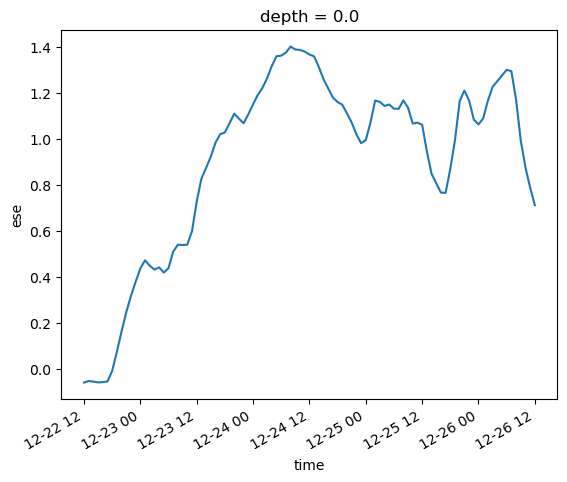

In [334]:
ds1.ese.plot()

In [166]:


# event_a = np.array([])
# event_d = np.array([])

# for uu,vv in zip(u10_during, v10_during):
#     drift_angle = vectors.vector_angle(uu,vv) - 20 * units('degree')
#     drift_dist = 0.02 * np.sqrt(uu**2+vv**2) * units('m/s').to('m/day').magnitude

# #     drift_angle = vectors.vector_angle(uu,vv)
# #     drift_dist = np.sqrt(uu**2+vv**2) * units('cm/s').to('m/day').magnitude
    
#     event_a = np.append(event_a, drift_angle.magnitude)
#     event_d = np.append(event_d, drift_dist)
    

# points = {}

# # points['HI'] = {}
# # points['HI']['itime'] = time_during[0]
# # points['HI']['ilat'] =   69.64
# # points['HI']['ilon'] =   -139.25

# # points['t1'] = {}
# # points['t1']['itime'] = time_during[3]
# # points['t1']['ilat'] =   69.37
# # points['t1']['ilon'] =   -136.89

# # points['t2'] = {}
# # points['t2']['itime'] = time_during[3]
# # points['t2']['ilat'] =   69.66
# # points['t2']['ilon'] =   -136.07

# points['HI'] = {}
# points['HI']['itime'] = time_during[0]
# points['HI']['ilat'] =   69.64
# points['HI']['ilon'] =   -139.25

# points['t1'] = {}
# points['t1']['itime'] = time_during[0]
# points['t1']['ilat'] =   69.2364
# points['t1']['ilon'] =   -137.6210

# points['t2'] = {}
# points['t2']['itime'] = time_during[0]
# points['t2']['ilat'] =   69.5569
# points['t2']['ilon'] =   -136.4344


# points['t3'] = {}
# points['t3']['itime'] = time_during[0]
# points['t3']['ilat'] =   69.8133
# points['t3']['ilon'] =   -135.4092


# points['t4'] = {}
# points['t4']['itime'] = time_during[0]
# points['t4']['ilat'] =   69.6295
# points['t4']['ilon'] =  -140.0593




# for key in points.keys():

#     event_lons = np.array([points[key]['ilon']])
#     event_lats = np.array([points[key]['ilat']])

#     for a, d, time in zip(event_a, event_d, time_during):
        
#         if time >= points[key]['itime']:
#             endlon, endlat, backaz = g.fwd(event_lons[-1], event_lats[-1], 90-a, d)
#         else:
#             endlon, endlat = event_lons[-1], event_lats[-1]
            
#         event_lons = np.append(event_lons, endlon)
#         event_lats = np.append(event_lats, endlat)
        
#     points[key]['event_lons'] = event_lons
#     points[key]['event_lats'] = event_lats

In [95]:
endlon, endlat, backaz = g.fwd(points['HI']['ilon'], points['HI']['ilat'], 90-(145), 100*1000)

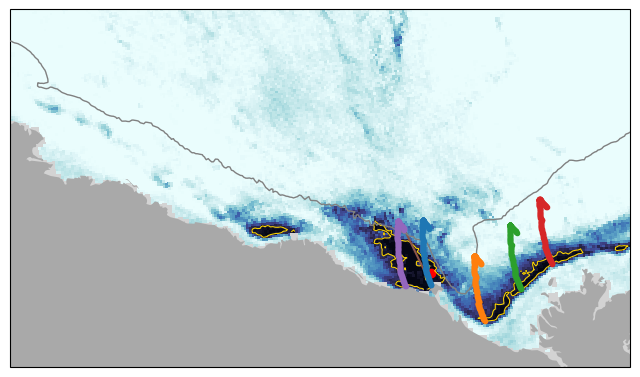

In [170]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-100], figsize=(8,10), panels=(1,1))



for key in points.keys():
    ax.plot(points[key]['event_lons'][:-1], 
               points[key]['event_lats'][:-1], 
               transform=ccrs.PlateCarree(), zorder=100, marker='.')

ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, transform=sic['proj'], cmap=cmocean.cm.ice)


ax.contour(sic['xx'], sic['yy'], sic['sic'], levels=[10], 
           transform=sic['proj'], colors=['gold'], linewidths=0.75)


ax.plot([points['HI']['ilon'], endlon], 
        [points['HI']['ilat'], endlat], 
           transform=ccrs.PlateCarree())



ax.scatter(-139.2582, 69.7718, c='r', transform=ccrs.PlateCarree())


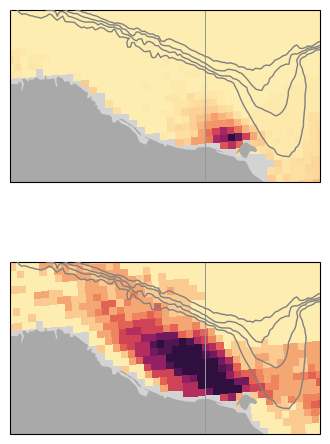

In [35]:
fig, axs = fn.makemap(view='narrowzoom', contours = [-400,-300,-200,-100], figsize=(4,6), panels=(2,1))

for ax in axs:
    line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
    for lat in [69,71,73]:
        ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
    for lon in [-160,-150,-140,-130]:
        ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)


    

key = 'd1'
axs[0].pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'])

key = 'd6'
axs[1].pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'])


NameError: name 'reg_poly' is not defined

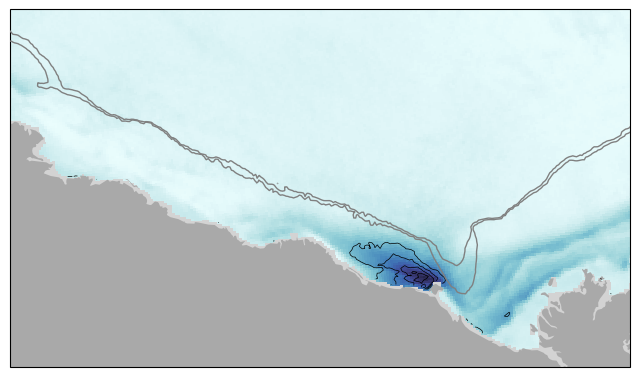

In [14]:
fig, ax = fn.makemap(view='wider_zoom', contours = [-200,-100])


key = 'all'
# key2='comp'

# ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#               vmin=0, vmax=0.5, cmap=cmocean.cm.haline_r, transform=dsic['proj'])

ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
              vmin=10, vmax=100, cmap=cmocean.cm.ice, transform=dsic['proj'])

ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
           levels=[0.1,0.2,0.3,0.4,0.5], colors=['k'], linewidths=0.5, transform=dsic['proj'])


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69,71,73]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-160,-150,-140,-130]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
    





# ax.quiver(drift_map_moor[key]['X_scaled'], drift_map_moor[key]['Y_scaled'], 
#           eS1, nS1, 
#           angles='xy', scale_units='xy', 
#           scale=1, width=0.0035, pivot='tail', zorder=100)

# u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
# v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
# ax.quiver(drift_map[key]['xx'], drift_map[key]['yy'], 
#           u1, v1, 
#           angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
#           scale=1, width=0.0035, color='gray', pivot='tail', zorder=100)

# u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
# v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
# s1 = np.nanmean(np.sqrt(drift_map[key]['u']**2+drift_map[key]['v']**2), axis=0)*units('cm/s').to('m/day').magnitude

# ax.quiver(drift_map[key]['xx'], drift_map[key]['yy'], 
#           u1, v1, 
#           angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
#           scale=1, width=0.0035, color='gray', pivot='tail', zorder=100)


# u2 = np.nanmean(drift_map[key2]['u'], axis=0)*units('cm/s').to('m/day').magnitude
# v2 = np.nanmean(drift_map[key2]['v'], axis=0)*units('cm/s').to('m/day').magnitude
# s2 = np.nanmean(np.sqrt(drift_map[key2]['u']**2+drift_map[key2]['v']**2), axis=0)*units('cm/s').to('m/day').magnitude
# vec_diff = np.sqrt((u1-u2)**2+(v1-v2)**2)
# speed_diff = s1-s2
# ax.pcolormesh(drift_map[key]['xx'], drift_map[key]['yy'], (vec_diff)/1000, 
#               vmin=0, vmax=13, cmap=cmocean.cm.haline, transform=drift_map[key]['proj'], zorder=0)

    
    
# uw1 = np.nanmean(era_map[key]['u10'], axis=0)
# vw1 = np.nanmean(era_map[key]['v10'], axis=0)
# sw1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)


# uw2 = np.nanmean(era_map[key2]['u10'], axis=0)
# vw2 = np.nanmean(era_map[key2]['v10'], axis=0)
# sw2 = np.nanmean(np.sqrt(era_map[key2]['u10']**2+era_map[key2]['v10']**2), axis=0)

# vec_diff = np.sqrt((uw1-uw2)**2+(vw1-vw2)**2)   

# # speed_diff = np.sqrt((uw1)**2+(vw1)**2) - np.sqrt((uw2)**2+(vw2)**2)   

# speed_diff = sw1-sw2 


# ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
#            np.nanmean(era_map[key]['msl'], axis=0)/100, 
#               vmin=1010,vmax=1030,
#               cmap=cmocean.cm.haline_r, transform=ccrs.PlateCarree())

# ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
#            (np.nanmean(era_map[key]['msl'], axis=0)-np.nanmean(era_map[key2]['msl'], axis=0))/100, 
#               vmin=-20,vmax=20,
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


# ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
#            (np.nanmean(era_map[key]['vort'], axis=0)), 
#               vmin=-0.001,vmax=0.001,
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


# ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
#            sw1-sw2, 
#               vmin=-5,vmax=5,
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

# ax.contour(era_map[key]['lon'], era_map[key]['lat'],
#            np.nanmean(era_map[key]['msl'], axis=0)/100,
#            levels=np.arange(980,1060,1), colors=['k'],
#            transform=ccrs.PlateCarree(), zorder=100)

    
# ax.contour(era_map[key]['lon'], era_map[key]['lat'], vec_diff, levels=[3,4,5,6,7,8],
#               vmin=0, vmax=8, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree(), zorder=0)

# ax.contourf(era_map[key]['lon'], era_map[key]['lat'], 
#               (np.nanmean(era_map[key]['msl'],axis=0))/100, 
#               vmin=1010, vmax=1030, levels=np.arange(1000,1044,1),
#             cmap=cmocean.cm.balance, transform=ccrs.PlateCarree(), zorder=0)


# sp1 = 2
# sp2 = 7
# ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], 
#          *geomap.fix_cartopy_vectors((uw2)[::sp1,::sp2], 
#                                      (vw2)[::sp1,::sp2], 
#                                      era_map[key]['lat'][::sp1,::sp2]), 
#           scale = 100, width = 0.0025,color='gray',
#           transform=ccrs.PlateCarree())

# sp1 = 2
# sp2 = 7
# ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], 
#          *geomap.fix_cartopy_vectors((uw1)[::sp1,::sp2], 
#                                      (vw1)[::sp1,::sp2], 
#                                      era_map[key]['lat'][::sp1,::sp2]), 
#           scale = 150, width = 0.0025,
#           transform=ccrs.PlateCarree())



# uwt = np.full(uw1.shape, 10*np.cos(165*np.pi/180))
# vwt = np.full(uw1.shape, 10*np.sin(165*np.pi/180))

# sp1 = 2
# sp2 = 7
# ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], 
#          *geomap.fix_cartopy_vectors((uwt)[::sp1,::sp2], 
#                                      (vwt)[::sp1,::sp2], 
#                                      era_map[key]['lat'][::sp1,::sp2]), 
#           scale = 150, width = 0.0025, color='red',
#           transform=ccrs.PlateCarree())


# ax.scatter(m1.attrs['lon'], m1.attrs['lat'], transform=ccrs.PlateCarree())
# ax.scatter(m2.attrs['lon'], m2.attrs['lat'], transform=ccrs.PlateCarree())
# ax.scatter(m3.attrs['lon'], m3.attrs['lat'], transform=ccrs.PlateCarree())
# ax.scatter(m4.attrs['lon'], m4.attrs['lat'], transform=ccrs.PlateCarree())

# fig.savefig('../figures/results/comp_map_all_msl.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [136]:
era_map[key].keys()

dict_keys(['u10', 'v10', 'msl', 'vort', 'lon', 'lat'])

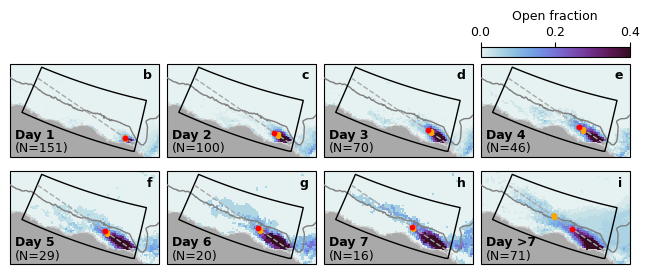

In [86]:
fig, axs = fn.makemap(view='wider_zoom2', contours = [-100], 
                      panels=(2,4), figsize=(8,2.75))
plt.subplots_adjust(hspace=0.025, wspace=0.05)


from pyproj import Geod
g = Geod(ellps='WGS84')
# startlon, startlat = -139, 69.5
startlon, startlat = -139.1, 69.6
# dists = np.array([31,64,79, 101,117,134,144,150])+10

tru_dists = np.array([31.41056723,  64.54320495,
                      79.37149842, 101.65035716, 117.79909441, 134.01560083,
                      144.42282603, 131.747859128])

wind_dists = np.array([31.69151215,  47.77875029,
        66.23453892,  83.33545515, 107.88820641, 124.87097074,
       138.03321063, 207.90784043896])


# for key, n, N in zip(['Dec', 'Jan', 'Feb', 'Mar',],
#                      [0,2,4,6], [1,3,5,7]):

FS = 9
for key, n in zip([f'd{m}' for m in range(1,8)]+[f'd>7'],
                     range(8)):

    axs[n].text(0.95,0.95,f'{chr(97+n+1)}', weight='bold', 
                ha='right', va='top', size=FS, transform=axs[n].transAxes)
    
    ax = axs[n]
    
    ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    ax.text(0.035,0.175,f'Day {key[1:]}', weight='bold', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    ax.text(0.035,0.025,f'(N={len(event_dates[key])})', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    
    mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.4, cmap=cmocean.cm.dense, transform=dsic['proj'])
    
#     ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#                   levels=[0.1,0.2,0.3,0.4,0.5], colors=['k'], linewidths=[0.5,], transform=dsic['proj'])
    
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
    ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
            c='darkgray', lw=1, zorder=100, ls='dashed')
    
    C = 'orange'
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, wind_dists[n]*1000)
#     ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
#             c=C, lw=1, zorder=100, ls='solid')
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), s=10, marker='s', c=C,  zorder=100)
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, tru_dists[n]*1000)
#     ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
#             c='r', lw=1, zorder=100, ls='solid')
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), s=10, marker='o', c='r',  zorder=100)

   
#     ax.scatter(startlon, startlat, transform=ccrs.PlateCarree())
    

plotter.add_colorbar(fig, axs[3], [mesh], cb_placement='top', cb_orientation='auto', 
                     cb_width=0.035, cb_length_fraction=[0, 1], cb_pad=0.025, cb_ticks=[0,0.2,0.4], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Open fraction', labelpad='auto', 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])


fig.savefig('../figures/results/dailyevent_maps.png', dpi=400, bbox_inches='tight', pad_inches=0)



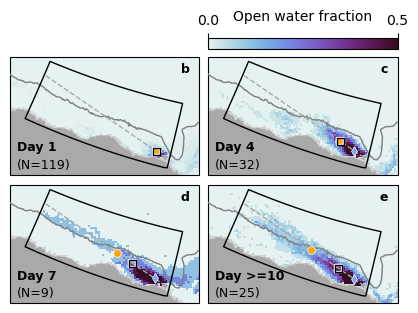

In [154]:
fig, axs = fn.makemap(view='wider_zoom2', contours = [-100], 
                      panels=(2,2), figsize=(5,3.25))
plt.subplots_adjust(hspace=0.05, wspace=0.05)


from pyproj import Geod
g = Geod(ellps='WGS84')
# startlon, startlat = -139, 69.5
startlon, startlat = -139.1, 69.6
# dists = np.array([31,64,79, 101,117,134,144,150])+10

# tru_dists = np.array([31.41056723,  64.54320495,
#                       79.37149842, 101.65035716, 117.79909441, 134.01560083,
#                       144.42282603, 131.747859128])

# wind_dists = np.array([31.69151215,  47.77875029,
#         66.23453892,  83.33545515, 107.88820641, 124.87097074,
#        138.03321063, 207.90784043896])

wind = np.array([29.67029984, 81.62365485, 159.8473894, 174.82151541])
latt = np.array([29.93782605, 33.22366475,  35.32942831, 33.74427032])
obss = np.array([29.38230774, 76.14685572, 107.23015109, 83.90562419])

# for key, n, N in zip(['Dec', 'Jan', 'Feb', 'Mar',],
#                      [0,2,4,6], [1,3,5,7]):

FS = 9
for key, n in zip([f'd{m}' for m in [1,4,7]]+[f'd>=10'],
                     range(6)):

    axs[n].text(0.95,0.95,f'{chr(97+n+1)}', weight='bold', 
                ha='right', va='top', size=FS, transform=axs[n].transAxes)
    
    ax = axs[n]
    
    ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    ax.text(0.035,0.175,f'Day {key[1:]}', weight='bold', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    ax.text(0.035,0.025,f'(N={len(event_dates[key])})', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    
    mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])
    
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
#               vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=dsic['proj'])
    
#     ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#                   levels=[0.25, 0.5], colors=['gold'], linewidths=[0.5,], transform=dsic['proj'])
    
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
    ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
            c='darkgray', lw=1, zorder=100, ls='dashed')
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, latt[n]*1000)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=25, marker='d', facecolor=[111/255,171/255,255/255], edgecolor='white',lw=0.5, zorder=100)
    
   
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, wind[n]*1000)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=30, marker='o', facecolor='orange', edgecolor='white', lw=0.5, zorder=100)
    
    
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, obss[n]*1000)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=25, marker='s', edgecolor='white', facecolor='None',lw=1.75, 
               zorder=100)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=25, marker='s', edgecolor='k', facecolor='None', zorder=100)

#     ax.scatter(startlon, startlat, transform=ccrs.PlateCarree())
    
plotter.add_colorbar(fig, axs[1], [mesh], cb_placement='top', cb_orientation='auto', 
                     cb_width=0.035, cb_length_fraction=[0, 1], cb_pad=0.025, cb_ticks=[0,0.5], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Open water fraction', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS+1, draw_edges=False, edge_params=['k', 2])


# fig.savefig('../figures/results/dailyevent_maps_v1.png', dpi=400, bbox_inches='tight', pad_inches=0)



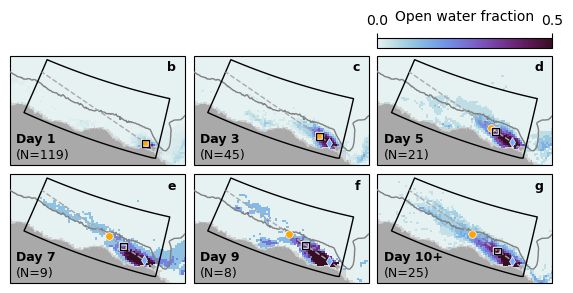

In [ ]:
65/255, 105/255, 225/255

In [51]:
map_sic.keys()

dict_keys(['all', 'b1', 'a1', 'comp', 'd1', 'd3', 'd5', 'd7', 'd9', 'd>=10'])

In [62]:

plt.show()

In [450]:
drift_map.keys()

dict_keys(['all', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd>=8'])

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/996813137.py:46: RuntimeWarning: Mean of empty slice
  sb = np.nanmean(np.sqrt(drift_map[keyb]['u']**2+drift_map[keyb]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/996813137.py:47: RuntimeWarning: Mean of empty slice
  s1 = np.nanmean(np.sqrt(drift_map[key]['u']**2+drift_map[key]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/996813137.py:48: RuntimeWarning: Mean of empty slice
  u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/996813137.py:49: RuntimeWarning: Mean of empty slice
  v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude


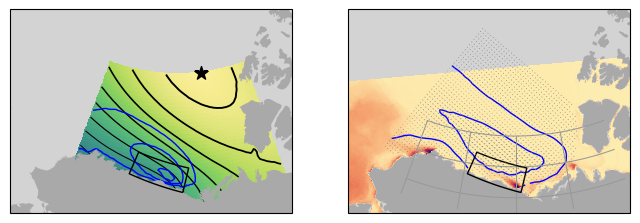

In [854]:
fig, axs = fn.makemap(view='large_view', panels=(1,2), contours = [])

for ax in axs:
    ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69,71,73]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-160,-150,-140,-130]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
    
    
key = 'all'
keyb = 'comp'

ax = axs[0]

LEVELS = np.arange(1001,1040,2)
LW = 2*(LEVELS-LEVELS.min())/(LEVELS.max()-LEVELS.min())
ax.contour(era_map[key]['lon'], era_map[key]['lat'],
           (np.nanmean(era_map[key]['msl'], axis=0))/100, 
            levels=LEVELS, colors=['k'],  linewidths = LW,
           transform=ccrs.PlateCarree(), zorder=-99)

ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
            (np.nanmean(era_map[key]['msl'], axis=0))/100, 
              vmin=1000,vmax=1028,
              cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-101)

sw1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)
ax.contour(era_map[key]['lon'], era_map[key]['lat'],sw1,
            levels=[8,9,10], colors=['b'],  linewidths = 1,
           transform=ccrs.PlateCarree(), zorder=0)


max_msl = np.nanmax(np.nanmean(era_map[key]['msl'], axis=0))

ax.scatter(era_map[key]['lon'][np.where(np.nanmean(era_map[key]['msl'], axis=0)==max_msl)], 
           era_map[key]['lat'][np.where(np.nanmean(era_map[key]['msl'], axis=0)==max_msl)],
           transform=ccrs.PlateCarree(), zorder=100, marker='*', c='k', s=100)


ax = axs[1]

sb = np.nanmean(np.sqrt(drift_map[keyb]['u']**2+drift_map[keyb]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
s1 = np.nanmean(np.sqrt(drift_map[key]['u']**2+drift_map[key]['v']**2), axis=0)*units('cm/s').to('km/day').magnitude
u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude

ax.quiver(drift_map[key]['xx'], drift_map[key]['yy'], 
          u1, v1, 
          angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
          scale=1, width=0.0035, color='gray', pivot='tail', zorder=100)

ax.contour(drift_map[key]['xx'], drift_map[key]['yy'], s1, 
            levels=[10,15,20], colors=['b'],  linewidths = 1,
           transform=drift_map[key]['proj'], zorder=0)


ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'], zorder=-1000)

# ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean']-map_sic['comp']['sic_mean'], 
#               vmin=-50, vmax=50, cmap=cmocean.cm.balance, transform=dsic['proj'], zorder=-1000)

# newcmap = cmocean.tools.crop_by_percent(cmocean.cm.balance, 50, which='max', N=None)
# ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
#               vmin=10, vmax=100, cmap=newcmap, transform=dsic['proj'], zorder=-1000)


# ax.pcolormesh(drift_map[key]['xx'], drift_map[key]['yy'], s1,
#               vmin=5,vmax=20, cmap=cmocean.cm.speed, transform=drift_map[key]['proj'], zorder=-100)

# sw1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)
# ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'], sw1, 
#               vmin=0,vmax=10, cmap=cmocean.cm.haline, zorder=-100, transform=ccrs.PlateCarree())


# ax.coastlines(zorder=101)

fig.savefig('../figures/results/comp_map_all.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [574]:
import matplotlib.path as mpath

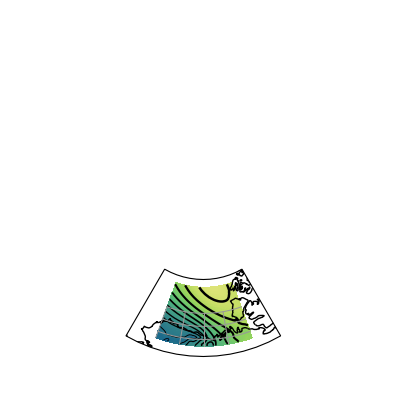

In [828]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-140)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(5,5))
line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69,71,73]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-160,-150,-140,-130]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    
# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
# theta = np.linspace(0, 2*np.pi, 72)
theta = np.arange(0, 361, 5) * np.pi/180

IND = 30
# circle 1
center, radius = [0.5, 0.5], 0.4
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
vals = (verts * radius) + center

# circle2
vals2 = np.copy(vals[IND:-IND])
vals2[0] = center
vals2[-1] = center

# circle3
center, radius = [0.5, 0.5], 0.2
vertsn = np.vstack([np.sin(theta), np.cos(theta)]).T
valsn = (vertsn * radius) + center

# stitch together
VALS = np.copy(vals[IND:-IND])
VALS = np.concatenate((VALS, valsn[IND:-IND,:][::-1]), axis=0)


circle = mpath.Path(VALS)
ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines()

ax.pcolormesh(era_map[key]['lon'], era_map[key]['lat'],
            (np.nanmean(era_map[key]['msl'], axis=0))/100, 
              vmin=1000,vmax=1030,
              cmap=cmocean.cm.haline, transform=ccrs.PlateCarree(), zorder=-101)

ax.contour(era_map[key]['lon'], era_map[key]['lat'],
           (np.nanmean(era_map[key]['msl'], axis=0))/100, 
            levels=LEVELS, colors=['k'],  linewidths = LW,
           transform=ccrs.PlateCarree(), zorder=-99)

# ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#               vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'], zorder=-1000)

# plt.subplots_adjust(top=0.1, bottom=-0.2, left=-0.3, right=1.3)

fig.savefig('/Users/mackenziejewell/Desktop/testimg.png', dpi=330, bbox_inches='tight', pad_inches=0)

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/3268696089.py:36: RuntimeWarning: Mean of empty slice
  u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_99890/3268696089.py:37: RuntimeWarning: Mean of empty slice
  v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude


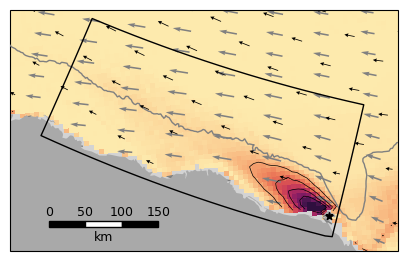

In [708]:
sys.path.append('../')
import functions as fn
fig, ax = fn.makemap(view='wider_zoom2', contours = [-100,], figsize=(5,5))

geomap.scalebar(ax, loc=(0.1, 0.1), steps=[50,100,150],unit='km', 
                label=None, colors=['k', 'w'], edgecolor=None, textsize=9, lw=1, 
                bar_width=0.025, labelpad=0.015, ticklabelpad=0.01, zorder=100, clip_on=True)

from pyproj import Geod
g = Geod(ellps='WGS84')
startlon, startlat = -139.1, 69.6
ax.scatter(startlon, startlat, zorder=100, s= 30, marker='*', c='k', transform=ccrs.PlateCarree())

ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())

# around_HI = {}
# around_HI['lon'] = []
# around_HI['lat'] = []
# for dist in [50]:
#     for az in np.linspace(-90,140,30):
#         endlon, endlat, backaz = g.fwd(startlon, startlat, az, dist*1000)
#         around_HI['lon'].append(endlon)
#         around_HI['lat'].append(endlat)
        
# ax.plot(around_HI['lon'], around_HI['lat'], c='k', 
#         ls='dashed', transform=ccrs.PlateCarree(), zorder=1000)


key = 'all'
ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'])
ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
            levels=[0.1,0.2,0.3,0.4], colors=['k'], linewidths=0.5, transform=dsic['proj'])
    

u1 = np.nanmean(drift_map[key]['u'], axis=0)*units('cm/s').to('m/day').magnitude
v1 = np.nanmean(drift_map[key]['v'], axis=0)*units('cm/s').to('m/day').magnitude
sp = 2
ax.quiver(drift_map[key]['xx'][::sp,::sp], drift_map[key]['yy'][::sp,::sp], 
          u1[::sp,::sp], v1[::sp,::sp], angles='xy', scale_units='xy', transform=drift_map[key]['proj'],
          scale=1, width=0.002, headwidth=5,  color='k', pivot='tail', zorder=100)


    
uw1 = np.nanmean(era_map[key]['u10'], axis=0)
vw1 = np.nanmean(era_map[key]['v10'], axis=0)
sw1 = np.nanmean(np.sqrt(era_map[key]['u10']**2+era_map[key]['v10']**2), axis=0)

sp1 = 1
sp2 = 7
ax.quiver(era_map[key]['lon'][::sp1,::sp2], era_map[key]['lat'][::sp1,::sp2], 
         *geomap.fix_cartopy_vectors((uw1)[::sp1,::sp2], 
                                     (vw1)[::sp1,::sp2], 
                                     era_map[key]['lat'][::sp1,::sp2]), 
          scale = 180, width = 0.004,color='gray',
          transform=ccrs.PlateCarree())

# ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#               vmin=0, vmax=0.5, cmap=cmocean.cm.matter, transform=dsic['proj'])

In [702]:
era_map.keys()

dict_keys(['all', 'b1', 'a1', 'comp', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd>=8'])

In [289]:
dates = pd.to_datetime(DF.time[(DF['event_day']==5)&(shoulder==False)].values)

SIC = unisic.open_local_file(dates[21], res = '6250', hem ='n', 
                    main_path = '/Volumes/Seagate_Jewell/KenzieStuff/',
                    crop = crop,
                     coordinates = False, area = False,
                     include_units = False, quiet = True,)

In [291]:
dates[21]

Timestamp('2022-03-02 00:00:00')

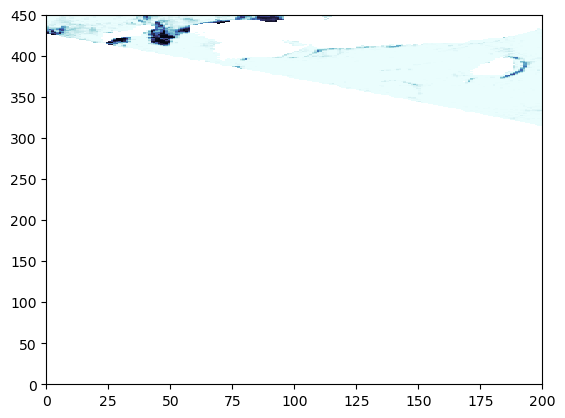

In [290]:
plt.pcolormesh(SIC['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice)

In [527]:
np.sum(flag_dates == False)

87

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


2019-12-12 00:00:00


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


2024-01-14 00:00:00


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


2022-02-28 00:00:00


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


2025-03-11 00:00:00


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


2016-04-12 00:00:00


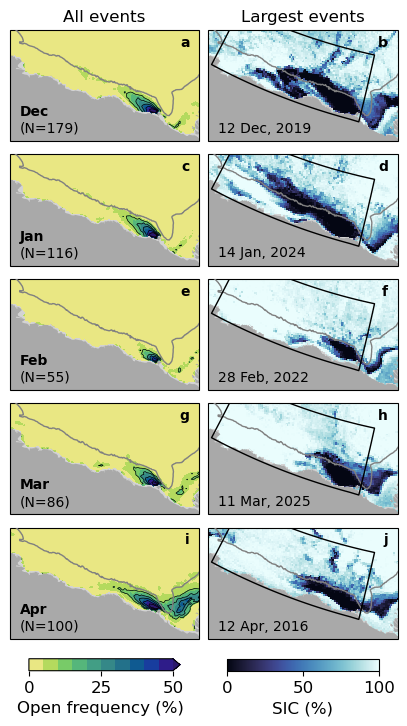

In [569]:
fig, axs = fn.makemap(view='wider_zoom', contours = [-100], 
                      panels=(5,2), figsize=(5,8))
plt.subplots_adjust(hspace=0.05, wspace=0.05)



for key, n, N in zip(['Dec', 'Jan', 'Feb', 'Mar', 'Apr'],
                     [0,2,4,6,8], [1,3,5,7,9]):

    
    axs[n].text(0.95,0.95,f'{chr(97+n)}', weight='bold', 
                ha='right', va='top', transform=axs[n].transAxes)
    axs[N].text(0.95,0.95,f'{chr(97+N)}', weight='bold', 
                ha='right', va='top', transform=axs[N].transAxes)

    
    
    ax = axs[n]
    
    ax.text(0.05,0.2,key, weight='bold', ha='left', va='bottom', transform=ax.transAxes)
    ax.text(0.05,0.05,f'(N={len(event_dates[key])})', ha='left', va='bottom', transform=ax.transAxes)
    
#     ax.add_geometries ([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    
#     mesh1 = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], 
#                           100*map_sic[key]['open_freq'], 
#                   vmin=0, vmax=50, cmap=cmocean.cm.haline_r, transform=dsic['proj'])
    
    mesh1 = ax.contourf(map_sic[key]['xx'], map_sic[key]['yy'],  100*map_sic[key]['open_freq'], 
                  levels=np.arange(0,51,5), vmin=0, vmax=50, extend='max',  cmap=cmocean.cm.haline_r, 
                linewidths=0.5,  transform=dsic['proj'])
    

#     ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['sic_mean'], 
#                   vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=dsic['proj'])
    
    ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], 
               ma.masked_where(np.isnan(map_sic[key]['sic_mean']), 100*map_sic[key]['open_freq']), 
                  levels=[10,20,30,40,50], colors=['k'], linewidths=0.5,  transform=dsic['proj'])



#     ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], 
#            ma.masked_where(np.isnan(map_sic[key]['sic_mean']), 100*map_sic[key]['open_freq']), 
#               levels=[10,20,30,40,50], colors=['k'], linewidths=0.5,  transform=dsic['proj'])




    
    
    
    
    # SPECIFIC EVENTS
    #------------------------------
    # flag dates in three years during freezeup/breakup
    current_dates = pd.to_datetime(event_dates[key])
    flag_dates = np.full(len(current_dates), False)
    flag_dates[(current_dates >= datetime(2007,12,1)) & (current_dates <= datetime(2007,12,15))] = True
    flag_dates[(current_dates >= datetime(2016,4,19)) & (current_dates <= datetime(2016,4,30))] = True
    flag_dates[(current_dates >= datetime(2018,4,30)) & (current_dates <= datetime(2018,4,30))] = True
    
    
    spec_ind = np.where(event_sizes[key] == np.max(event_sizes[key][flag_dates==False]))[0][0]
    spec_date = current_dates[spec_ind]
    print(spec_date)
    spec_sic = unisic.open_local_file(spec_date, res=RES, crop=crop, 
                                      coordinates=False, area=False, include_units=False, quiet=True)
    ax = axs[N]
    ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    mesh2 = ax.pcolormesh(spec_sic['xx'], spec_sic['yy'], spec_sic['sic'], 
                      vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=spec_sic['proj'])

    
    ax.text(0.05,0.05,spec_date.strftime('%d %b, %Y'), 
            ha='left', va='bottom', transform=ax.transAxes)

    
    

plotter.add_colorbar(fig, axs[8], [mesh1], cb_placement='bottom', cb_orientation='auto', 
             cb_width=0.015, cb_length_fraction=[0.1, 0.9], cb_pad=0.025, cb_ticks=[0,25,50], 
             cb_ticklabels='auto', cb_extend='neither', cb_label='Open frequency (%)', labelpad='auto', 
             cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
             cb_labelsize=12, draw_edges=False, edge_params=['k', 2])

plotter.add_colorbar(fig, axs[9], [mesh2], cb_placement='bottom', cb_orientation='auto', 
             cb_width=0.015, cb_length_fraction=[0.1, 0.9], cb_pad=0.025, cb_ticks='auto', 
             cb_ticklabels='auto', cb_extend='neither', cb_label='SIC (%)', labelpad='auto', 
             cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
             cb_labelsize=12, draw_edges=False, edge_params=['k', 2])

axs[0].set_title('All events')
axs[1].set_title('Largest events')

fig.savefig('../figures/results/monthly_maps_cf.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [558]:
n

0

In [531]:
np.sum(np.isnan(map_sic[key]['open_freq']))

168819

In [532]:
np.sum(np.isnan(map_sic[key]['sic_mean']))



168819

In [524]:
help(plotter.add_colorbar)

Help on function add_colorbar in module plot_simply.general:

add_colorbar(fig, ax, colorbar_input, cb_placement='left', cb_orientation='auto', cb_width='auto', cb_length_fraction=[0, 1], cb_pad=0, cb_ticks='auto', cb_ticklabels='auto', cb_extend='neither', cb_label=' ', labelpad='auto', cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, cb_labelsize=12, draw_edges=False, edge_params=['k', 2])
    Function for plotting colorbar along edge of figure axis.

    INPUT:
    - fig: figure to which colorbar will be added
    - ax: figure axis to which colorbar will be added
    - colorbar_input: either specify [matplotlib.collections.QuadMesh], pmatplotlib.cm.ScalarMappable] (from pcolormesh plot output),
                        [cartopy.mpl.contour.GeoContourSet] (from countourf output),
                      or specify [cmap, norm]
                       where cmap is matplotlib cmap (e.g. 'RdBu')
                       where norm is matplotlib.colors normlalization ins

In [520]:
spec_date.strftime('%d %b, %Y')

'12 Apr, 2016'

In [ ]:
uwt = np.fulle
vwt = np.nanmean(era_map[key]['v10'], axis=0)

In [81]:
era_map[key].keys()

dict_keys(['u10', 'v10', 'msl', 'lon', 'lat'])

# Reference vectors

In [1615]:
upslope = {}

upslope['m1'] = {}
upslope['m1']['angle'] = 145 * units('degree')

upslope['m2'] = {}
upslope['m2']['angle'] = -150 * units('degree')

upslope['m3'] = {}
upslope['m3']['angle'] = -115 * units('degree')

upslope['m4'] = {}
upslope['m4']['angle'] = -90 * units('degree')


for m, M in zip([m1, m2, m3, m4], upslope.keys()):
    
    mag = 0.1
    cu = mag*np.cos(upslope[M]['angle'].to('rad'))
    cv = mag*np.sin(upslope[M]['angle'].to('rad'))

    map_proj = ccrs.NorthPolarStereo(central_longitude=-140)
    tail, tip, vec = vectors.project_vectors(map_proj, m.attrs['lon'], m.attrs['lat'], 
                    eastward=cu*units('m/s'), 
                    northward=cv*units('m/s'), final_units='m/day')
    
    upslope[M]['tail'] = tail
    upslope[M]['tip'] = tip
    upslope[M]['vec'] = vec


# find 2016-2018 dates

In [59]:
all_spec_dates = np.array([], dtype=np.datetime64)

all_spec_dates = pd.to_datetime(DF.time[ (DF.extent > 0) & ((DF.year == 2017) + (DF.year == 2018))].values)
all_other_dates = pd.to_datetime(DF.time[ (DF.extent == 0) & ((DF.year == 2017) + (DF.year == 2018))].values)
# for ss in all_seqs.keys():
#     if (all_seqs[ss][0] >= datetime(2016,12,1)) & (all_seqs[ss][-1] <= datetime(2018,4,30)):
#         all_spec_dates = np.append(all_spec_dates, all_seqs[ss])
# print(all_spec_dates[0], all_spec_dates[-1])

# all_other_dates = np.array([], dtype=np.datetime64)
# for date in pd.date_range(all_spec_dates[0], all_spec_dates[-1]):
#     if date not in all_spec_dates:
#         if date.month not in [5,6,7,8,9,10,11]:
#             all_other_dates = np.append(all_other_dates,date)

In [60]:
spec_y1 = all_spec_dates[all_spec_dates < datetime(2017,11,1)]
spec_y2 = all_spec_dates[all_spec_dates > datetime(2017,11,1)]

other_y1 = all_other_dates[all_other_dates < datetime(2017,11,1)]
other_y2 = all_other_dates[all_other_dates > datetime(2017,11,1)]



## Calc mean flows

In [65]:
mvec = {}
mvec['m1'] = {}
mvec['m1']['depth_range'] = (-50,0)

mvec['m2'] = {}
mvec['m2']['depth_range'] = (-150,-50)

mvec['m3'] = {}
mvec['m3']['depth_range'] = (-150,-50)

mvec['m4'] = {}
mvec['m4']['depth_range'] = (-150,-50)


groups = ['open', 'comp']

for M in mvec.keys():
    
    for group in groups:
        
        mvec[M][group] = {}

        mvec[M][group]['tip_x'] = np.array([])
        mvec[M][group]['tip_y'] = np.array([])

        mvec[M][group]['vec_x'] = np.array([])
        mvec[M][group]['vec_y'] = np.array([])
        
        mvec[M][group]['itip_x'] = np.array([])
        mvec[M][group]['itip_y'] = np.array([])

        mvec[M][group]['ivec_x'] = np.array([])
        mvec[M][group]['ivec_y'] = np.array([])



In [66]:

for spec_y_dates, other_y_dates, open_years in zip([spec_y1, spec_y2], 
                                                   [other_y1, other_y2],
                                                   ['2016_2017', '2017_2018']):
    
    # open_years = '2017_2018'
    m1 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_{open_years}.nc')
    m2 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_ocean_currents_{open_years}.nc')
    m3 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_ocean_currents_{open_years}.nc')
    m4 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_ocean_currents_{open_years}.nc')

    m1i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_seaice_velocity_{open_years}.nc')
    m2i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_seaice_velocity_{open_years}.nc')
    m3i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_seaice_velocity_{open_years}.nc')
    m4i = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_seaice_velocity_{open_years}.nc')

    m1t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_{open_years}.nc')
    m2t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_tempsalinity_{open_years}.nc')
    m3t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/M3_hourly_tempsalinity_{open_years}.nc')
    m4t = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/M4_hourly_tempsalinity_{open_years}.nc')

    print(open_years)
    
    for m, mi, M in zip([m1, m2, m3, m4], [m1i, m2i, m3i, m4i], mvec.keys()):
        
        print(M)
        
        for group, dates in zip(['open', 'comp'], [spec_y_dates, other_y_dates]):
            
            cdata = mvec[M][group]

            tails, tips, vecs = grab_vector_range(m, dates, depth_range = mvec[M]['depth_range'], daily_means=True)

            # grab tips
            cdata['tip_x'] = np.append(cdata['tip_x'], np.array([tip[0] for tip in tips]))
            cdata['tip_y'] = np.append(cdata['tip_y'], np.array([tip[1] for tip in tips]))

            # grab tails
            cdata['tail_x'] = np.nanmean(np.array([tail[0] for tail in tails]))
            cdata['tail_y'] = np.nanmean(np.array([tail[1] for tail in tails]))


            # grab vectors
            cdata['vec_x'] = np.append(cdata['vec_x'], np.array([vec[0].magnitude for vec in vecs]))
            cdata['vec_y'] = np.append(cdata['vec_y'], np.array([vec[1].magnitude for vec in vecs]))

            
            
            # ICE VELOCITIES
            tails, tips, vecs = grab_icevector_range(mi, dates)

            # grab tips
            cdata['itip_x'] = np.append(cdata['itip_x'], np.array([tip[0] for tip in tips]))
            cdata['itip_y'] = np.append(cdata['itip_y'], np.array([tip[1] for tip in tips]))

            # grab tails
            cdata['itail_x'] = np.nanmean(np.array([tail[0] for tail in tails]))
            cdata['itail_y'] = np.nanmean(np.array([tail[1] for tail in tails]))


            # grab vectors
            cdata['ivec_x'] = np.append(cdata['ivec_x'], np.array([vec[0].magnitude for vec in vecs]))
            cdata['ivec_y'] = np.append(cdata['ivec_y'], np.array([vec[1].magnitude for vec in vecs]))

    
    
for M in mvec.keys():
    
    for group in ['open', 'comp']:

        cdata = mvec[M][group]
        
        x = cdata['vec_x']
        y = cdata['vec_y']

        cdata['mean_x'] = np.nanmean(cdata['vec_x'])
        cdata['mean_y'] = np.nanmean(cdata['vec_y'])

        xp = x[np.isfinite(x)&np.isfinite(y)]
        yp = y[np.isfinite(x)&np.isfinite(y)]

        # find variance ellipses
        varell = tanalyze.variance_ellipses(xp,yp)
        xm = vectors.comp_along_theta(xp, yp, varell['theta_m'] * units('rad'))
        ym = vectors.comp_along_theta(xp, yp, (varell['theta_m']+np.pi/2) * units('rad'))


        cdata['varell_x'] = varell['xe']
        cdata['varell_y'] = varell['ye']
        
        
        # ice velocities
        #----------------
        x = cdata['ivec_x']
        y = cdata['ivec_y']

        cdata['imean_x'] = np.nanmean(cdata['ivec_x'])
        cdata['imean_y'] = np.nanmean(cdata['ivec_y'])

        xp = x[np.isfinite(x)&np.isfinite(y)]
        yp = y[np.isfinite(x)&np.isfinite(y)]

        # find variance ellipses
        varell = tanalyze.variance_ellipses(xp,yp)
        xm = vectors.comp_along_theta(xp, yp, varell['theta_m'] * units('rad'))
        ym = vectors.comp_along_theta(xp, yp, (varell['theta_m']+np.pi/2) * units('rad'))


        cdata['ivarell_x'] = varell['xe']
        cdata['ivarell_y'] = varell['ye']
    

2016_2017
m1
m2
m3
m4
2017_2018
m1
m2
m3
m4


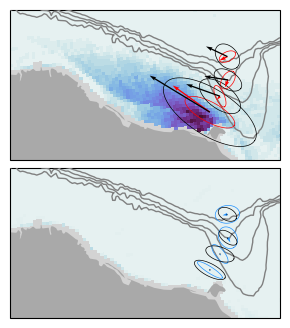

In [78]:
fig, axs = fn.makemap(view='narrowzoom', contours = [-400,-300,-200,-100], figsize=(6,4), panels=(2,1))



# for ax in axs:
#     line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
#     for lat in [69,71,73]:
#         ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
#     for lon in [-160,-150,-140,-130]:
#         ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)


#     for m in ['M1', 'M2', 'M3', 'M4']: 

#         ax.scatter(M[m]['lon'], M[m]['lat'], transform=ccrs.PlateCarree(), c='k')

    

key = 'all'
axs[0].pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])

key = 'comp'
axs[1].pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])


aw = 0.004

for M in mvec.keys():

    for group, color, ax in zip(['open', 'comp'], ['r', 'dodgerblue'], [axs[0], axs[1]]):

        cdata = mvec[M][group]

        ax.quiver(cdata['tail_x'], cdata['tail_y'], 
                  cdata['mean_x'], cdata['mean_y'], 
                  angles='xy', scale_units='xy', scale=1, color=color, width=1.2*aw, zorder=100)

        ax.plot(cdata['varell_x']+cdata['tail_x'], 
                cdata['varell_y']+cdata['tail_y'], c=color, zorder=100, lw=0.5, alpha=1)

        
        ax.quiver(cdata['itail_x'], cdata['itail_y'], 
                  cdata['imean_x'], cdata['imean_y'], 
                  angles='xy', scale_units='xy', scale=1, color='k', width=1.2*aw, zorder=100)

        ax.plot(cdata['ivarell_x']+cdata['itail_x'], 
                cdata['ivarell_y']+cdata['itail_y'], c='k', zorder=100, lw=0.5, alpha=1)

plt.subplots_adjust(hspace=0.05)

# fig.savefig('../figures/results/canyon_flow_topdown.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [ ]:

# sys.path.append('../../Libraries_functions/')
# from LIB_MODIS_IST_N1kmNIGHT import grab_MODIS_IST

# date1 = datetime(2017,12,16)
# # date2 = datetime(2024,1,8)

# date3 = datetime(2019,12,13)

# # date2 = datetime(2024,1,8)

# # date2 = datetime(2016,4,10)

# date2 = datetime(2024,1,14)
# file_path = f'/Volumes/Seagate_Jewell/KenzieStuff/MODIS_IST_1km_night/{date1.strftime("%Y.%m")}/'
# # IST1 = grab_MODIS_IST(date1, file_path = file_path)
# file_path = f'/Volumes/Seagate_Jewell/KenzieStuff/MODIS_IST_1km_night/{date2.strftime("%Y.%m")}/'
# # IST2 = grab_MODIS_IST(date2, file_path = file_path)

# file_path = f'/Volumes/Seagate_Jewell/KenzieStuff/MODIS_IST_1km_night/{date3.strftime("%Y.%m")}/'
# # IST3 = grab_MODIS_IST(date3, file_path = file_path)

# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'

# # sicsic = unisic.open_local_file(datetime(2019,1,16), res='1000ma2', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
# #                             crop=[2100, 3400, 340, 800], coordinates=False, area=False, include_units=False, quiet=True)

# sic1 = unisic.open_local_file(date1, res=RES, hem='n', 
#                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
#                              crop=crop, coordinates=False, area=False, include_units=False, quiet=True)

# sic2 = unisic.open_local_file(date2, res=RES, hem='n', 
#                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
#                              crop=crop, coordinates=False, area=False, include_units=False, quiet=True)



# sic3 = unisic.open_local_file(date3, res=RES, hem='n', 
#                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
#                              crop=crop, coordinates=False, area=False, include_units=False, quiet=True)

# fig, axs = fn.makemap(view='wider_zoom3', contours = [-100], 
#                       panels=(1,3), figsize=(9,3))


# # fig, ax = fn.makemap(view='wider_zoom2', contours = [], 
# #                       panels=(1,1), figsize=(4,4))

# for ax in axs:
#     ax.add_geometries ([reg_poly], lw=2, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


#     line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
#     for lat in [70]:
#         ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
#     for lon in [-140,]:
#         ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)

        
# cmap = cmocean.cm.balance
        
# ax = axs[0]
# # ax.pcolormesh(IST1['xx'], IST1['yy'], IST1['ist']-273.15, 
# #               vmin=-30, vmax=0, cmap=cmap, transform=IST1['proj'])
# # ax.pcolormesh(sic1['xx'], sic1['yy'], sic1['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=sic1['proj'])
# ax.contour(sic1['xx'], sic1['yy'], sic1['sic'], levels=[10], colors=['k'],linewidths=[0.5], transform=sic1['proj'])


# ax = axs[2]
# # ax.pcolormesh(sic2['xx'], sic2['yy'], sic2['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=sic1['proj'])
# # ax.contour(sic2['xx'], sic2['yy'], sic2['sic'], levels=[10], colors=['gold'],linewidths=[0.5], transform=sic1['proj'])
# # ax.pcolormesh(IST2['xx'], IST2['yy'], IST2['ist']-273.15, 
# #               vmin=-30, vmax=0, cmap=cmap, transform=IST2['proj'])
# ax.contour(sic2['xx'], sic2['yy'], sic2['sic'], levels=[10], colors=['k'],linewidths=[0.5], transform=sic1['proj'])

# ax = axs[1]
# # ax.pcolormesh(sic2['xx'], sic2['yy'], sic2['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=sic1['proj'])
# # ax.contour(sic2['xx'], sic2['yy'], sic2['sic'], levels=[10], colors=['gold'],linewidths=[0.5], transform=sic1['proj'])
# # ax.pcolormesh(IST3['xx'], IST3['yy'], IST3['ist']-273.15, 
# #               vmin=-30, vmax=0, cmap=cmap, transform=IST3['proj'])
# ax.contour(sic3['xx'], sic3['yy'], sic3['sic'], levels=[10], colors=['k'],linewidths=[0.5], transform=sic1['proj'])

# plt.subplots_adjust(wspace=0.025)

# # fig.savefig('../figures/results/thermal_maps.png', dpi=400, bbox_inches='tight', pad_inches=0)